##### Copyright 2020 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 애드온 레이어: WeightNormalization

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/addons/tutorials/layers_weightnormalization"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/addons/tutorials/layers_weightnormalization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/addons/tutorials/layers_weightnormalization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/addons/tutorials/layers_weightnormalization.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 개요

이 노트북은 가중치 정규화 레이어를 사용하는 방법과 수렴을 향상할 수 있는 방법을 보여줍니다.


# WeightNormalization

심층 신경망의 훈련을 가속하기 위한 간단한 재매개변수화:

Tim Salimans, Diederik P. Kingma (2016)

> 이러한 방식으로 가중치를 재매개변수화함으로써 최적화 문제의 처리를 개선하고 확률적 경사 하강의 수렴을 가속합니다. 재매개변수화는 배치 정규화에서 영감을 얻었지만, 미니 배치의 예제 간에 종속성을 도입하지는 않습니다. 이는 이 방법이 배치 정규화가 덜 적합한 LSTM과 같은 반복 모델과 심층 강화 학습 또는 생성 모델과 같은 노이즈에 민감한 애플리케이션에 성공적으로 적용될 수 있음을 의미합니다. 이 방법은 훨씬 간단하지만, 전체 배치 정규화의 속도를 크게 향상합니다. 또한, 이 방법의 계산 오버헤드가 더 적으므로 같은 시간에 더 많은 최적화 단계를 수행할 수 있습니다.

> https://arxiv.org/abs/1602.07868

<img src="https://raw.githubusercontent.com/seanpmorgan/tf-weightnorm/master/static/wrapped-graph.png" width="80%"><br><br>


## 설정

In [2]:
!pip install -q -U tensorflow-addons

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa

In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# Hyper Parameters
batch_size = 32
epochs = 10
num_classes=10

## 모델 빌드하기

In [6]:
# Standard ConvNet
reg_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [7]:
# WeightNorm ConvNet
wn_model = tf.keras.Sequential([
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(6, 5, activation='relu')),
    tf.keras.layers.MaxPooling2D(2, 2),
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(16, 5, activation='relu')),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(120, activation='relu')),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(84, activation='relu')),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(num_classes, activation='softmax')),
])

## 데이터 로드하기

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

     8192/170498071 [..............................] - ETA: 59:37

    40960/170498071 [..............................] - ETA: 24:06

    90112/170498071 [..............................] - ETA: 16:23

   204800/170498071 [..............................] - ETA: 9:37 

   434176/170498071 [..............................] - ETA: 5:40

   876544/170498071 [..............................] - ETA: 3:21

  1777664/170498071 [..............................] - ETA: 1:55

  3563520/170498071 [..............................] - ETA: 1:03

  4071424/170498071 [..............................] - ETA: 57s 

  6660096/170498071 [>.............................] - ETA: 36s

  6709248/170498071 [>.............................] - ETA: 38s

  9773056/170498071 [>.............................] - ETA: 27s

  9838592/170498071 [>.............................] - ETA: 28s

 12820480/170498071 [=>............................] - ETA: 22s

 12918784/170498071 [=>............................] - ETA: 22s

 13230080/170498071 [=>............................] - ETA: 22s

 15933440/170498071 [=>............................] - ETA: 19s

 16064512/170498071 [=>............................] - ETA: 20s

 18604032/170498071 [==>...........................] - ETA: 17s

 19095552/170498071 [==>...........................] - ETA: 17s

 19324928/170498071 [==>...........................] - ETA: 17s

 21848064/170498071 [==>...........................] - ETA: 16s

 22470656/170498071 [==>...........................] - ETA: 16s

 24911872/170498071 [===>..........................] - ETA: 15s

 25583616/170498071 [===>..........................] - ETA: 14s

 27959296/170498071 [===>..........................] - ETA: 13s

 28024832/170498071 [===>..........................] - ETA: 13s

 28303360/170498071 [===>..........................] - ETA: 14s

 30580736/170498071 [====>.........................] - ETA: 13s

 31088640/170498071 [====>.........................] - ETA: 13s

 31350784/170498071 [====>.........................] - ETA: 13s

 33726464/170498071 [====>.........................] - ETA: 12s

 34217984/170498071 [=====>........................] - ETA: 12s

 34430976/170498071 [=====>........................] - ETA: 12s

 36544512/170498071 [=====>........................] - ETA: 11s

 37330944/170498071 [=====>........................] - ETA: 11s

 37543936/170498071 [=====>........................] - ETA: 11s

 39657472/170498071 [=====>........................] - ETA: 11s

 40443904/170498071 [======>.......................] - ETA: 11s

 40673280/170498071 [======>.......................] - ETA: 11s

 42786816/170498071 [======>.......................] - ETA: 10s

 43556864/170498071 [======>.......................] - ETA: 10s

 43786240/170498071 [======>.......................] - ETA: 10s

 45752320/170498071 [=======>......................] - ETA: 10s

 46653440/170498071 [=======>......................] - ETA: 10s

 46915584/170498071 [=======>......................] - ETA: 10s

 48848896/170498071 [=======>......................] - ETA: 9s 

 49733632/170498071 [=======>......................] - ETA: 9s

 49995776/170498071 [=======>......................] - ETA: 9s

 51929088/170498071 [========>.....................] - ETA: 9s

 52502528/170498071 [========>.....................] - ETA: 9s

 53092352/170498071 [========>.....................] - ETA: 9s

 54632448/170498071 [========>.....................] - ETA: 8s

 55599104/170498071 [========>.....................] - ETA: 8s

 56205312/170498071 [========>.....................] - ETA: 8s

 57335808/170498071 [=========>....................] - ETA: 8s

 58712064/170498071 [=========>....................] - ETA: 8s

 59334656/170498071 [=========>....................] - ETA: 8s

 60301312/170498071 [=========>....................] - ETA: 8s

 61792256/170498071 [=========>....................] - ETA: 8s

 62398464/170498071 [=========>....................] - ETA: 8s

 63414272/170498071 [==========>...................] - ETA: 8s

 64905216/170498071 [==========>...................] - ETA: 7s

 65183744/170498071 [==========>...................] - ETA: 7s

 66527232/170498071 [==========>...................] - ETA: 7s

 67969024/170498071 [==========>...................] - ETA: 7s

 68263936/170498071 [===========>..................] - ETA: 7s

 69672960/170498071 [===========>..................] - ETA: 7s

 71098368/170498071 [===========>..................] - ETA: 7s

 71376896/170498071 [===========>..................] - ETA: 7s

 72769536/170498071 [===========>..................] - ETA: 7s

 74194944/170498071 [============>.................] - ETA: 6s

 74506240/170498071 [============>.................] - ETA: 6s

 75882496/170498071 [============>.................] - ETA: 6s

 77291520/170498071 [============>.................] - ETA: 6s

 77619200/170498071 [============>.................] - ETA: 6s

 78995456/170498071 [============>.................] - ETA: 6s

 80388096/170498071 [=============>................] - ETA: 6s

 80748544/170498071 [=============>................] - ETA: 6s

 82092032/170498071 [=============>................] - ETA: 6s

 83468288/170498071 [=============>................] - ETA: 6s

 83861504/170498071 [=============>................] - ETA: 6s

 85221376/170498071 [=============>................] - ETA: 5s

 86564864/170498071 [==============>...............] - ETA: 5s

 86990848/170498071 [==============>...............] - ETA: 5s

 88317952/170498071 [==============>...............] - ETA: 5s

 89284608/170498071 [==============>...............] - ETA: 5s

 90136576/170498071 [==============>...............] - ETA: 5s

 91430912/170498071 [===============>..............] - ETA: 5s

 92397568/170498071 [===============>..............] - ETA: 5s

 93265920/170498071 [===============>..............] - ETA: 5s

 94527488/170498071 [===============>..............] - ETA: 5s

 95494144/170498071 [===============>..............] - ETA: 5s

 96378880/170498071 [===============>..............] - ETA: 5s

 97411072/170498071 [================>.............] - ETA: 5s

 98574336/170498071 [================>.............] - ETA: 4s

 99475456/170498071 [================>.............] - ETA: 4s

100196352/170498071 [================>.............] - ETA: 4s

101687296/170498071 [================>.............] - ETA: 4s

102621184/170498071 [=================>............] - ETA: 4s

103260160/170498071 [=================>............] - ETA: 4s

104751104/170498071 [=================>............] - ETA: 4s

105750528/170498071 [=================>............] - ETA: 4s

106405888/170498071 [=================>............] - ETA: 4s

107864064/170498071 [=================>............] - ETA: 4s

108830720/170498071 [==================>...........] - ETA: 4s

109486080/170498071 [==================>...........] - ETA: 4s

110993408/170498071 [==================>...........] - ETA: 3s

111599616/170498071 [==================>...........] - ETA: 3s

112566272/170498071 [==================>...........] - ETA: 3s

114106368/170498071 [===================>..........] - ETA: 3s

114712576/170498071 [===================>..........] - ETA: 3s

115695616/170498071 [===================>..........] - ETA: 3s

117219328/170498071 [===================>..........] - ETA: 3s

117841920/170498071 [===================>..........] - ETA: 3s

118808576/170498071 [===================>..........] - ETA: 3s

120315904/170498071 [====================>.........] - ETA: 3s

120954880/170498071 [====================>.........] - ETA: 3s

121921536/170498071 [====================>.........] - ETA: 3s

123396096/170498071 [====================>.........] - ETA: 3s

124051456/170498071 [====================>.........] - ETA: 3s

125018112/170498071 [====================>.........] - ETA: 3s

126476288/170498071 [=====================>........] - ETA: 2s

127131648/170498071 [=====================>........] - ETA: 2s

128098304/170498071 [=====================>........] - ETA: 2s

129507328/170498071 [=====================>........] - ETA: 2s

129835008/170498071 [=====================>........] - ETA: 2s

130899968/170498071 [======================>.......] - ETA: 2s

131964928/170498071 [======================>.......] - ETA: 2s

132931584/170498071 [======================>.......] - ETA: 2s

133701632/170498071 [======================>.......] - ETA: 2s

135061504/170498071 [======================>.......] - ETA: 2s

136044544/170498071 [======================>.......] - ETA: 2s

136683520/170498071 [=======================>......] - ETA: 2s

138199040/170498071 [=======================>......] - ETA: 2s

139173888/170498071 [=======================>......] - ETA: 2s

139812864/170498071 [=======================>......] - ETA: 1s

141369344/170498071 [=======================>......] - ETA: 1s

142286848/170498071 [========================>.....] - ETA: 1s

142909440/170498071 [========================>.....] - ETA: 1s

144384000/170498071 [========================>.....] - ETA: 1s

145399808/170498071 [========================>.....] - ETA: 1s

146022400/170498071 [========================>.....] - ETA: 1s

147529728/170498071 [========================>.....] - ETA: 1s

148496384/170498071 [=========================>....] - ETA: 1s

149118976/170498071 [=========================>....] - ETA: 1s

150626304/170498071 [=========================>....] - ETA: 1s

151625728/170498071 [=========================>....] - ETA: 1s

152231936/170498071 [=========================>....] - ETA: 1s

153722880/170498071 [==========================>...] - ETA: 1s

154755072/170498071 [==========================>...] - ETA: 1s

155344896/170498071 [==========================>...] - ETA: 0s

156835840/170498071 [==========================>...] - ETA: 0s

157884416/170498071 [==========================>...] - ETA: 0s

158490624/170498071 [==========================>...] - ETA: 0s

159916032/170498071 [===========================>..] - ETA: 0s

160997376/170498071 [===========================>..] - ETA: 0s

161603584/170498071 [===========================>..] - ETA: 0s

163012608/170498071 [===========================>..] - ETA: 0s

164110336/170498071 [===========================>..] - ETA: 0s

164700160/170498071 [===========================>..] - ETA: 0s

166141952/170498071 [============================>.] - ETA: 0s

166846464/170498071 [============================>.] - ETA: 0s

167829504/170498071 [============================>.] - ETA: 0s

169123840/170498071 [============================>.] - ETA: 0s

169828352/170498071 [============================>.] - ETA: 0s

170500096/170498071 [==============================] - 11s 0us/step


## 모델 훈련하기

In [9]:
reg_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

reg_history = reg_model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            shuffle=True)

Epoch 1/10


   1/1563 [..............................] - ETA: 1s - loss: 2.2944 - accuracy: 0.1250

  20/1563 [..............................] - ETA: 4s - loss: 2.2995 - accuracy: 0.1047

  41/1563 [..............................] - ETA: 3s - loss: 2.2916 - accuracy: 0.1143

  62/1563 [>.............................] - ETA: 3s - loss: 2.2770 - accuracy: 0.1316

  82/1563 [>.............................] - ETA: 3s - loss: 2.2465 - accuracy: 0.1486

 102/1563 [>.............................] - ETA: 3s - loss: 2.2021 - accuracy: 0.1667

 123/1563 [=>............................] - ETA: 3s - loss: 2.1610 - accuracy: 0.1827

 144/1563 [=>............................] - ETA: 3s - loss: 2.1237 - accuracy: 0.2029

 165/1563 [==>...........................] - ETA: 3s - loss: 2.0945 - accuracy: 0.2180

 185/1563 [==>...........................] - ETA: 3s - loss: 2.0630 - accuracy: 0.2314

 206/1563 [==>...........................] - ETA: 3s - loss: 2.0435 - accuracy: 0.2368

 227/1563 [===>..........................] - ETA: 3s - loss: 2.0219 - accuracy: 0.2475

 247/1563 [===>..........................] - ETA: 3s - loss: 2.0043 - accuracy: 0.2546

 268/1563 [====>.........................] - ETA: 3s - loss: 1.9886 - accuracy: 0.2613

 289/1563 [====>.........................] - ETA: 3s - loss: 1.9729 - accuracy: 0.2687

 309/1563 [====>.........................] - ETA: 3s - loss: 1.9591 - accuracy: 0.2741

 330/1563 [=====>........................] - ETA: 3s - loss: 1.9441 - accuracy: 0.2791

 351/1563 [=====>........................] - ETA: 3s - loss: 1.9275 - accuracy: 0.2859

 372/1563 [======>.......................] - ETA: 2s - loss: 1.9136 - accuracy: 0.2920

 393/1563 [======>.......................] - ETA: 2s - loss: 1.9041 - accuracy: 0.2959

 413/1563 [======>.......................] - ETA: 2s - loss: 1.8946 - accuracy: 0.2993

 433/1563 [=======>......................] - ETA: 2s - loss: 1.8839 - accuracy: 0.3034

 453/1563 [=======>......................] - ETA: 2s - loss: 1.8741 - accuracy: 0.3072

 472/1563 [========>.....................] - ETA: 2s - loss: 1.8661 - accuracy: 0.3091

 492/1563 [========>.....................] - ETA: 2s - loss: 1.8585 - accuracy: 0.3109

 513/1563 [========>.....................] - ETA: 2s - loss: 1.8500 - accuracy: 0.3136

 533/1563 [=========>....................] - ETA: 2s - loss: 1.8428 - accuracy: 0.3174

 554/1563 [=========>....................] - ETA: 2s - loss: 1.8364 - accuracy: 0.3199

 575/1563 [==========>...................] - ETA: 2s - loss: 1.8294 - accuracy: 0.3236

 596/1563 [==========>...................] - ETA: 2s - loss: 1.8229 - accuracy: 0.3262

 617/1563 [==========>...................] - ETA: 2s - loss: 1.8162 - accuracy: 0.3284

 638/1563 [===========>..................] - ETA: 2s - loss: 1.8103 - accuracy: 0.3306

 659/1563 [===========>..................] - ETA: 2s - loss: 1.8046 - accuracy: 0.3323

 680/1563 [============>.................] - ETA: 2s - loss: 1.7968 - accuracy: 0.3348

 701/1563 [============>.................] - ETA: 2s - loss: 1.7908 - accuracy: 0.3372

 721/1563 [============>.................] - ETA: 2s - loss: 1.7861 - accuracy: 0.3398

 742/1563 [=============>................] - ETA: 2s - loss: 1.7794 - accuracy: 0.3427

 763/1563 [=============>................] - ETA: 1s - loss: 1.7736 - accuracy: 0.3446

 784/1563 [==============>...............] - ETA: 1s - loss: 1.7705 - accuracy: 0.3462

 805/1563 [==============>...............] - ETA: 1s - loss: 1.7659 - accuracy: 0.3488

 825/1563 [==============>...............] - ETA: 1s - loss: 1.7634 - accuracy: 0.3506

 845/1563 [===============>..............] - ETA: 1s - loss: 1.7586 - accuracy: 0.3522

 865/1563 [===============>..............] - ETA: 1s - loss: 1.7543 - accuracy: 0.3538

 885/1563 [===============>..............] - ETA: 1s - loss: 1.7496 - accuracy: 0.3553

 906/1563 [================>.............] - ETA: 1s - loss: 1.7436 - accuracy: 0.3575

 926/1563 [================>.............] - ETA: 1s - loss: 1.7397 - accuracy: 0.3593

 946/1563 [=================>............] - ETA: 1s - loss: 1.7359 - accuracy: 0.3608

 966/1563 [=================>............] - ETA: 1s - loss: 1.7325 - accuracy: 0.3623

 987/1563 [=================>............] - ETA: 1s - loss: 1.7292 - accuracy: 0.3637

1008/1563 [==================>...........] - ETA: 1s - loss: 1.7252 - accuracy: 0.3650

1029/1563 [==================>...........] - ETA: 1s - loss: 1.7202 - accuracy: 0.3671

1050/1563 [===================>..........] - ETA: 1s - loss: 1.7155 - accuracy: 0.3691

1070/1563 [===================>..........] - ETA: 1s - loss: 1.7112 - accuracy: 0.3704

1090/1563 [===================>..........] - ETA: 1s - loss: 1.7067 - accuracy: 0.3720

1110/1563 [====================>.........] - ETA: 1s - loss: 1.7034 - accuracy: 0.3733

1131/1563 [====================>.........] - ETA: 1s - loss: 1.6992 - accuracy: 0.3755

1152/1563 [=====================>........] - ETA: 1s - loss: 1.6954 - accuracy: 0.3775

1173/1563 [=====================>........] - ETA: 0s - loss: 1.6925 - accuracy: 0.3785

1194/1563 [=====================>........] - ETA: 0s - loss: 1.6886 - accuracy: 0.3799

1215/1563 [======================>.......] - ETA: 0s - loss: 1.6862 - accuracy: 0.3812

1235/1563 [======================>.......] - ETA: 0s - loss: 1.6834 - accuracy: 0.3823

1255/1563 [=======================>......] - ETA: 0s - loss: 1.6800 - accuracy: 0.3836

1275/1563 [=======================>......] - ETA: 0s - loss: 1.6758 - accuracy: 0.3852

1295/1563 [=======================>......] - ETA: 0s - loss: 1.6725 - accuracy: 0.3866

1314/1563 [========================>.....] - ETA: 0s - loss: 1.6702 - accuracy: 0.3875

1332/1563 [========================>.....] - ETA: 0s - loss: 1.6678 - accuracy: 0.3890

1351/1563 [========================>.....] - ETA: 0s - loss: 1.6660 - accuracy: 0.3896

1371/1563 [=========================>....] - ETA: 0s - loss: 1.6630 - accuracy: 0.3909

1391/1563 [=========================>....] - ETA: 0s - loss: 1.6598 - accuracy: 0.3919

1411/1563 [==========================>...] - ETA: 0s - loss: 1.6566 - accuracy: 0.3934

1431/1563 [==========================>...] - ETA: 0s - loss: 1.6552 - accuracy: 0.3942

1451/1563 [==========================>...] - ETA: 0s - loss: 1.6520 - accuracy: 0.3958

1470/1563 [===========================>..] - ETA: 0s - loss: 1.6492 - accuracy: 0.3965

1490/1563 [===========================>..] - ETA: 0s - loss: 1.6463 - accuracy: 0.3975

1510/1563 [===========================>..] - ETA: 0s - loss: 1.6441 - accuracy: 0.3984

1530/1563 [============================>.] - ETA: 0s - loss: 1.6416 - accuracy: 0.3998

1550/1563 [============================>.] - ETA: 0s - loss: 1.6385 - accuracy: 0.4010

1563/1563 [==============================] - 5s 3ms/step - loss: 1.6373 - accuracy: 0.4014 - val_loss: 1.4192 - val_accuracy: 0.4774


Epoch 2/10
   1/1563 [..............................] - ETA: 0s - loss: 1.5111 - accuracy: 0.4688

  22/1563 [..............................] - ETA: 3s - loss: 1.4106 - accuracy: 0.5000

  42/1563 [..............................] - ETA: 3s - loss: 1.4173 - accuracy: 0.4926

  63/1563 [>.............................] - ETA: 3s - loss: 1.4257 - accuracy: 0.4812

  84/1563 [>.............................] - ETA: 3s - loss: 1.4238 - accuracy: 0.4814

 105/1563 [=>............................] - ETA: 3s - loss: 1.4381 - accuracy: 0.4705

 125/1563 [=>............................] - ETA: 3s - loss: 1.4360 - accuracy: 0.4735

 145/1563 [=>............................] - ETA: 3s - loss: 1.4370 - accuracy: 0.4765

 164/1563 [==>...........................] - ETA: 3s - loss: 1.4365 - accuracy: 0.4779

 185/1563 [==>...........................] - ETA: 3s - loss: 1.4303 - accuracy: 0.4802

 205/1563 [==>...........................] - ETA: 3s - loss: 1.4294 - accuracy: 0.4802

 225/1563 [===>..........................] - ETA: 3s - loss: 1.4290 - accuracy: 0.4799

 245/1563 [===>..........................] - ETA: 3s - loss: 1.4267 - accuracy: 0.4807

 266/1563 [====>.........................] - ETA: 3s - loss: 1.4146 - accuracy: 0.4861

 286/1563 [====>.........................] - ETA: 3s - loss: 1.4152 - accuracy: 0.4850

 306/1563 [====>.........................] - ETA: 3s - loss: 1.4115 - accuracy: 0.4862

 326/1563 [=====>........................] - ETA: 3s - loss: 1.4103 - accuracy: 0.4884

 346/1563 [=====>........................] - ETA: 3s - loss: 1.4081 - accuracy: 0.4894

 367/1563 [======>.......................] - ETA: 3s - loss: 1.4044 - accuracy: 0.4916

 388/1563 [======>.......................] - ETA: 2s - loss: 1.4066 - accuracy: 0.4911

 409/1563 [======>.......................] - ETA: 2s - loss: 1.4102 - accuracy: 0.4907

 430/1563 [=======>......................] - ETA: 2s - loss: 1.4091 - accuracy: 0.4902

 451/1563 [=======>......................] - ETA: 2s - loss: 1.4079 - accuracy: 0.4913

 472/1563 [========>.....................] - ETA: 2s - loss: 1.4088 - accuracy: 0.4913

 492/1563 [========>.....................] - ETA: 2s - loss: 1.4082 - accuracy: 0.4918

 511/1563 [========>.....................] - ETA: 2s - loss: 1.4069 - accuracy: 0.4928

 531/1563 [=========>....................] - ETA: 2s - loss: 1.4066 - accuracy: 0.4929

 551/1563 [=========>....................] - ETA: 2s - loss: 1.4056 - accuracy: 0.4938

 572/1563 [=========>....................] - ETA: 2s - loss: 1.4042 - accuracy: 0.4951

 593/1563 [==========>...................] - ETA: 2s - loss: 1.4022 - accuracy: 0.4958

 614/1563 [==========>...................] - ETA: 2s - loss: 1.4006 - accuracy: 0.4966

 636/1563 [===========>..................] - ETA: 2s - loss: 1.4019 - accuracy: 0.4960

 657/1563 [===========>..................] - ETA: 2s - loss: 1.4018 - accuracy: 0.4967

 678/1563 [============>.................] - ETA: 2s - loss: 1.4021 - accuracy: 0.4969

 699/1563 [============>.................] - ETA: 2s - loss: 1.4013 - accuracy: 0.4971

 720/1563 [============>.................] - ETA: 2s - loss: 1.3989 - accuracy: 0.4979

 741/1563 [=============>................] - ETA: 2s - loss: 1.3984 - accuracy: 0.4978

 762/1563 [=============>................] - ETA: 1s - loss: 1.3972 - accuracy: 0.4986

 783/1563 [==============>...............] - ETA: 1s - loss: 1.3955 - accuracy: 0.4993

 804/1563 [==============>...............] - ETA: 1s - loss: 1.3959 - accuracy: 0.4996

 825/1563 [==============>...............] - ETA: 1s - loss: 1.3950 - accuracy: 0.5000

 847/1563 [===============>..............] - ETA: 1s - loss: 1.3941 - accuracy: 0.5001

 869/1563 [===============>..............] - ETA: 1s - loss: 1.3925 - accuracy: 0.5006

 890/1563 [================>.............] - ETA: 1s - loss: 1.3920 - accuracy: 0.5004

 911/1563 [================>.............] - ETA: 1s - loss: 1.3919 - accuracy: 0.5006

 932/1563 [================>.............] - ETA: 1s - loss: 1.3895 - accuracy: 0.5012

 953/1563 [=================>............] - ETA: 1s - loss: 1.3876 - accuracy: 0.5016

 974/1563 [=================>............] - ETA: 1s - loss: 1.3880 - accuracy: 0.5013

 995/1563 [==================>...........] - ETA: 1s - loss: 1.3878 - accuracy: 0.5016

1015/1563 [==================>...........] - ETA: 1s - loss: 1.3874 - accuracy: 0.5014

1036/1563 [==================>...........] - ETA: 1s - loss: 1.3868 - accuracy: 0.5019

1056/1563 [===================>..........] - ETA: 1s - loss: 1.3864 - accuracy: 0.5025

1077/1563 [===================>..........] - ETA: 1s - loss: 1.3844 - accuracy: 0.5031

1097/1563 [====================>.........] - ETA: 1s - loss: 1.3829 - accuracy: 0.5039

1118/1563 [====================>.........] - ETA: 1s - loss: 1.3817 - accuracy: 0.5043

1139/1563 [====================>.........] - ETA: 1s - loss: 1.3803 - accuracy: 0.5046

1160/1563 [=====================>........] - ETA: 0s - loss: 1.3794 - accuracy: 0.5049

1181/1563 [=====================>........] - ETA: 0s - loss: 1.3797 - accuracy: 0.5044

1201/1563 [======================>.......] - ETA: 0s - loss: 1.3798 - accuracy: 0.5048

1221/1563 [======================>.......] - ETA: 0s - loss: 1.3788 - accuracy: 0.5053

1242/1563 [======================>.......] - ETA: 0s - loss: 1.3782 - accuracy: 0.5057

1263/1563 [=======================>......] - ETA: 0s - loss: 1.3783 - accuracy: 0.5057

1283/1563 [=======================>......] - ETA: 0s - loss: 1.3770 - accuracy: 0.5058

1304/1563 [========================>.....] - ETA: 0s - loss: 1.3760 - accuracy: 0.5066

1324/1563 [========================>.....] - ETA: 0s - loss: 1.3756 - accuracy: 0.5067

1344/1563 [========================>.....] - ETA: 0s - loss: 1.3753 - accuracy: 0.5067

1365/1563 [=========================>....] - ETA: 0s - loss: 1.3751 - accuracy: 0.5070

1386/1563 [=========================>....] - ETA: 0s - loss: 1.3746 - accuracy: 0.5074

1407/1563 [==========================>...] - ETA: 0s - loss: 1.3737 - accuracy: 0.5077

1427/1563 [==========================>...] - ETA: 0s - loss: 1.3729 - accuracy: 0.5081

1448/1563 [==========================>...] - ETA: 0s - loss: 1.3717 - accuracy: 0.5083

1469/1563 [===========================>..] - ETA: 0s - loss: 1.3705 - accuracy: 0.5088

1489/1563 [===========================>..] - ETA: 0s - loss: 1.3707 - accuracy: 0.5090

1509/1563 [===========================>..] - ETA: 0s - loss: 1.3698 - accuracy: 0.5094

1530/1563 [============================>.] - ETA: 0s - loss: 1.3691 - accuracy: 0.5099

1551/1563 [============================>.] - ETA: 0s - loss: 1.3677 - accuracy: 0.5103

1563/1563 [==============================] - 4s 3ms/step - loss: 1.3673 - accuracy: 0.5106 - val_loss: 1.3043 - val_accuracy: 0.5369


Epoch 3/10
   1/1563 [..............................] - ETA: 0s - loss: 1.2936 - accuracy: 0.5938

  22/1563 [..............................] - ETA: 3s - loss: 1.3158 - accuracy: 0.5398

  43/1563 [..............................] - ETA: 3s - loss: 1.2771 - accuracy: 0.5531

  63/1563 [>.............................] - ETA: 3s - loss: 1.2656 - accuracy: 0.5456

  83/1563 [>.............................] - ETA: 3s - loss: 1.2595 - accuracy: 0.5444

 103/1563 [>.............................] - ETA: 3s - loss: 1.2551 - accuracy: 0.5498

 124/1563 [=>............................] - ETA: 3s - loss: 1.2555 - accuracy: 0.5509

 146/1563 [=>............................] - ETA: 3s - loss: 1.2609 - accuracy: 0.5484

 167/1563 [==>...........................] - ETA: 3s - loss: 1.2585 - accuracy: 0.5492

 189/1563 [==>...........................] - ETA: 3s - loss: 1.2556 - accuracy: 0.5504

 210/1563 [===>..........................] - ETA: 3s - loss: 1.2586 - accuracy: 0.5482

 231/1563 [===>..........................] - ETA: 3s - loss: 1.2603 - accuracy: 0.5478

 251/1563 [===>..........................] - ETA: 3s - loss: 1.2629 - accuracy: 0.5463

 271/1563 [====>.........................] - ETA: 3s - loss: 1.2598 - accuracy: 0.5492

 292/1563 [====>.........................] - ETA: 3s - loss: 1.2507 - accuracy: 0.5520

 313/1563 [=====>........................] - ETA: 3s - loss: 1.2503 - accuracy: 0.5531

 333/1563 [=====>........................] - ETA: 3s - loss: 1.2523 - accuracy: 0.5534

 353/1563 [=====>........................] - ETA: 2s - loss: 1.2540 - accuracy: 0.5531

 374/1563 [======>.......................] - ETA: 2s - loss: 1.2484 - accuracy: 0.5560

 394/1563 [======>.......................] - ETA: 2s - loss: 1.2492 - accuracy: 0.5550

 415/1563 [======>.......................] - ETA: 2s - loss: 1.2476 - accuracy: 0.5548

 435/1563 [=======>......................] - ETA: 2s - loss: 1.2488 - accuracy: 0.5539

 456/1563 [=======>......................] - ETA: 2s - loss: 1.2478 - accuracy: 0.5535

 477/1563 [========>.....................] - ETA: 2s - loss: 1.2460 - accuracy: 0.5546

 498/1563 [========>.....................] - ETA: 2s - loss: 1.2455 - accuracy: 0.5555

 519/1563 [========>.....................] - ETA: 2s - loss: 1.2460 - accuracy: 0.5558

 540/1563 [=========>....................] - ETA: 2s - loss: 1.2433 - accuracy: 0.5561

 561/1563 [=========>....................] - ETA: 2s - loss: 1.2430 - accuracy: 0.5561

 582/1563 [==========>...................] - ETA: 2s - loss: 1.2437 - accuracy: 0.5557

 603/1563 [==========>...................] - ETA: 2s - loss: 1.2459 - accuracy: 0.5549

 624/1563 [==========>...................] - ETA: 2s - loss: 1.2464 - accuracy: 0.5550

 644/1563 [===========>..................] - ETA: 2s - loss: 1.2485 - accuracy: 0.5543

 664/1563 [===========>..................] - ETA: 2s - loss: 1.2491 - accuracy: 0.5537

 684/1563 [============>.................] - ETA: 2s - loss: 1.2490 - accuracy: 0.5540

 704/1563 [============>.................] - ETA: 2s - loss: 1.2505 - accuracy: 0.5535

 724/1563 [============>.................] - ETA: 2s - loss: 1.2517 - accuracy: 0.5523

 744/1563 [=============>................] - ETA: 2s - loss: 1.2508 - accuracy: 0.5526

 764/1563 [=============>................] - ETA: 1s - loss: 1.2509 - accuracy: 0.5528

 783/1563 [==============>...............] - ETA: 1s - loss: 1.2510 - accuracy: 0.5533

 803/1563 [==============>...............] - ETA: 1s - loss: 1.2502 - accuracy: 0.5539

 823/1563 [==============>...............] - ETA: 1s - loss: 1.2510 - accuracy: 0.5538

 844/1563 [===============>..............] - ETA: 1s - loss: 1.2516 - accuracy: 0.5532

 865/1563 [===============>..............] - ETA: 1s - loss: 1.2518 - accuracy: 0.5533

 885/1563 [===============>..............] - ETA: 1s - loss: 1.2505 - accuracy: 0.5539

 906/1563 [================>.............] - ETA: 1s - loss: 1.2504 - accuracy: 0.5537

 926/1563 [================>.............] - ETA: 1s - loss: 1.2504 - accuracy: 0.5535

 946/1563 [=================>............] - ETA: 1s - loss: 1.2502 - accuracy: 0.5534

 967/1563 [=================>............] - ETA: 1s - loss: 1.2492 - accuracy: 0.5540

 989/1563 [=================>............] - ETA: 1s - loss: 1.2494 - accuracy: 0.5540

1009/1563 [==================>...........] - ETA: 1s - loss: 1.2493 - accuracy: 0.5537

1030/1563 [==================>...........] - ETA: 1s - loss: 1.2502 - accuracy: 0.5533

1051/1563 [===================>..........] - ETA: 1s - loss: 1.2512 - accuracy: 0.5527

1072/1563 [===================>..........] - ETA: 1s - loss: 1.2502 - accuracy: 0.5529

1093/1563 [===================>..........] - ETA: 1s - loss: 1.2495 - accuracy: 0.5534

1114/1563 [====================>.........] - ETA: 1s - loss: 1.2485 - accuracy: 0.5537

1135/1563 [====================>.........] - ETA: 1s - loss: 1.2479 - accuracy: 0.5539

1156/1563 [=====================>........] - ETA: 1s - loss: 1.2474 - accuracy: 0.5541

1177/1563 [=====================>........] - ETA: 0s - loss: 1.2474 - accuracy: 0.5543

1197/1563 [=====================>........] - ETA: 0s - loss: 1.2472 - accuracy: 0.5545

1217/1563 [======================>.......] - ETA: 0s - loss: 1.2470 - accuracy: 0.5543

1238/1563 [======================>.......] - ETA: 0s - loss: 1.2480 - accuracy: 0.5541

1259/1563 [=======================>......] - ETA: 0s - loss: 1.2477 - accuracy: 0.5540

1280/1563 [=======================>......] - ETA: 0s - loss: 1.2466 - accuracy: 0.5548

1300/1563 [=======================>......] - ETA: 0s - loss: 1.2470 - accuracy: 0.5550

1320/1563 [========================>.....] - ETA: 0s - loss: 1.2475 - accuracy: 0.5546

1341/1563 [========================>.....] - ETA: 0s - loss: 1.2479 - accuracy: 0.5545

1362/1563 [=========================>....] - ETA: 0s - loss: 1.2476 - accuracy: 0.5545

1382/1563 [=========================>....] - ETA: 0s - loss: 1.2471 - accuracy: 0.5551

1403/1563 [=========================>....] - ETA: 0s - loss: 1.2470 - accuracy: 0.5554

1423/1563 [==========================>...] - ETA: 0s - loss: 1.2471 - accuracy: 0.5554

1444/1563 [==========================>...] - ETA: 0s - loss: 1.2465 - accuracy: 0.5556

1465/1563 [===========================>..] - ETA: 0s - loss: 1.2454 - accuracy: 0.5560

1486/1563 [===========================>..] - ETA: 0s - loss: 1.2453 - accuracy: 0.5563

1505/1563 [===========================>..] - ETA: 0s - loss: 1.2445 - accuracy: 0.5568

1524/1563 [============================>.] - ETA: 0s - loss: 1.2448 - accuracy: 0.5571

1544/1563 [============================>.] - ETA: 0s - loss: 1.2439 - accuracy: 0.5570

1563/1563 [==============================] - 4s 3ms/step - loss: 1.2437 - accuracy: 0.5571 - val_loss: 1.2662 - val_accuracy: 0.5441


Epoch 4/10
   1/1563 [..............................] - ETA: 0s - loss: 1.0693 - accuracy: 0.6250

  21/1563 [..............................] - ETA: 3s - loss: 1.1372 - accuracy: 0.6101

  41/1563 [..............................] - ETA: 3s - loss: 1.1006 - accuracy: 0.6220

  62/1563 [>.............................] - ETA: 3s - loss: 1.1154 - accuracy: 0.6129

  84/1563 [>.............................] - ETA: 3s - loss: 1.1415 - accuracy: 0.6016

 105/1563 [=>............................] - ETA: 3s - loss: 1.1488 - accuracy: 0.5976

 125/1563 [=>............................] - ETA: 3s - loss: 1.1420 - accuracy: 0.6000

 145/1563 [=>............................] - ETA: 3s - loss: 1.1471 - accuracy: 0.5991

 166/1563 [==>...........................] - ETA: 3s - loss: 1.1527 - accuracy: 0.5958

 187/1563 [==>...........................] - ETA: 3s - loss: 1.1602 - accuracy: 0.5917

 207/1563 [==>...........................] - ETA: 3s - loss: 1.1696 - accuracy: 0.5882

 226/1563 [===>..........................] - ETA: 3s - loss: 1.1657 - accuracy: 0.5886

 246/1563 [===>..........................] - ETA: 3s - loss: 1.1572 - accuracy: 0.5913

 266/1563 [====>.........................] - ETA: 3s - loss: 1.1550 - accuracy: 0.5916

 287/1563 [====>.........................] - ETA: 3s - loss: 1.1586 - accuracy: 0.5916

 308/1563 [====>.........................] - ETA: 3s - loss: 1.1594 - accuracy: 0.5925

 328/1563 [=====>........................] - ETA: 3s - loss: 1.1599 - accuracy: 0.5911

 348/1563 [=====>........................] - ETA: 3s - loss: 1.1527 - accuracy: 0.5925

 368/1563 [======>.......................] - ETA: 2s - loss: 1.1512 - accuracy: 0.5920

 388/1563 [======>.......................] - ETA: 2s - loss: 1.1513 - accuracy: 0.5918

 408/1563 [======>.......................] - ETA: 2s - loss: 1.1517 - accuracy: 0.5908

 429/1563 [=======>......................] - ETA: 2s - loss: 1.1531 - accuracy: 0.5903

 450/1563 [=======>......................] - ETA: 2s - loss: 1.1572 - accuracy: 0.5894

 470/1563 [========>.....................] - ETA: 2s - loss: 1.1540 - accuracy: 0.5907

 491/1563 [========>.....................] - ETA: 2s - loss: 1.1528 - accuracy: 0.5912

 511/1563 [========>.....................] - ETA: 2s - loss: 1.1519 - accuracy: 0.5903

 532/1563 [=========>....................] - ETA: 2s - loss: 1.1525 - accuracy: 0.5896

 553/1563 [=========>....................] - ETA: 2s - loss: 1.1519 - accuracy: 0.5899

 573/1563 [=========>....................] - ETA: 2s - loss: 1.1522 - accuracy: 0.5894

 593/1563 [==========>...................] - ETA: 2s - loss: 1.1545 - accuracy: 0.5883

 613/1563 [==========>...................] - ETA: 2s - loss: 1.1542 - accuracy: 0.5882

 633/1563 [===========>..................] - ETA: 2s - loss: 1.1530 - accuracy: 0.5893

 653/1563 [===========>..................] - ETA: 2s - loss: 1.1565 - accuracy: 0.5881

 673/1563 [===========>..................] - ETA: 2s - loss: 1.1590 - accuracy: 0.5870

 694/1563 [============>.................] - ETA: 2s - loss: 1.1602 - accuracy: 0.5862

 714/1563 [============>.................] - ETA: 2s - loss: 1.1598 - accuracy: 0.5867

 735/1563 [=============>................] - ETA: 2s - loss: 1.1584 - accuracy: 0.5880

 755/1563 [=============>................] - ETA: 2s - loss: 1.1579 - accuracy: 0.5888

 775/1563 [=============>................] - ETA: 1s - loss: 1.1577 - accuracy: 0.5884

 796/1563 [==============>...............] - ETA: 1s - loss: 1.1574 - accuracy: 0.5886

 817/1563 [==============>...............] - ETA: 1s - loss: 1.1563 - accuracy: 0.5889

 838/1563 [===============>..............] - ETA: 1s - loss: 1.1560 - accuracy: 0.5892

 859/1563 [===============>..............] - ETA: 1s - loss: 1.1564 - accuracy: 0.5891

 880/1563 [===============>..............] - ETA: 1s - loss: 1.1551 - accuracy: 0.5898

 901/1563 [================>.............] - ETA: 1s - loss: 1.1546 - accuracy: 0.5901

 922/1563 [================>.............] - ETA: 1s - loss: 1.1541 - accuracy: 0.5900

 943/1563 [=================>............] - ETA: 1s - loss: 1.1530 - accuracy: 0.5908

 963/1563 [=================>............] - ETA: 1s - loss: 1.1535 - accuracy: 0.5910

 983/1563 [=================>............] - ETA: 1s - loss: 1.1546 - accuracy: 0.5907

1003/1563 [==================>...........] - ETA: 1s - loss: 1.1549 - accuracy: 0.5910

1023/1563 [==================>...........] - ETA: 1s - loss: 1.1539 - accuracy: 0.5917

1044/1563 [===================>..........] - ETA: 1s - loss: 1.1538 - accuracy: 0.5917

1065/1563 [===================>..........] - ETA: 1s - loss: 1.1540 - accuracy: 0.5920

1085/1563 [===================>..........] - ETA: 1s - loss: 1.1547 - accuracy: 0.5918

1106/1563 [====================>.........] - ETA: 1s - loss: 1.1539 - accuracy: 0.5926

1127/1563 [====================>.........] - ETA: 1s - loss: 1.1533 - accuracy: 0.5929

1148/1563 [=====================>........] - ETA: 1s - loss: 1.1541 - accuracy: 0.5927

1168/1563 [=====================>........] - ETA: 0s - loss: 1.1543 - accuracy: 0.5925

1189/1563 [=====================>........] - ETA: 0s - loss: 1.1542 - accuracy: 0.5921

1209/1563 [======================>.......] - ETA: 0s - loss: 1.1546 - accuracy: 0.5920

1229/1563 [======================>.......] - ETA: 0s - loss: 1.1546 - accuracy: 0.5921

1249/1563 [======================>.......] - ETA: 0s - loss: 1.1547 - accuracy: 0.5921

1269/1563 [=======================>......] - ETA: 0s - loss: 1.1544 - accuracy: 0.5925

1290/1563 [=======================>......] - ETA: 0s - loss: 1.1551 - accuracy: 0.5922

1310/1563 [========================>.....] - ETA: 0s - loss: 1.1548 - accuracy: 0.5920

1330/1563 [========================>.....] - ETA: 0s - loss: 1.1548 - accuracy: 0.5918

1351/1563 [========================>.....] - ETA: 0s - loss: 1.1547 - accuracy: 0.5922

1372/1563 [=========================>....] - ETA: 0s - loss: 1.1540 - accuracy: 0.5923

1392/1563 [=========================>....] - ETA: 0s - loss: 1.1549 - accuracy: 0.5921

1413/1563 [==========================>...] - ETA: 0s - loss: 1.1552 - accuracy: 0.5921

1434/1563 [==========================>...] - ETA: 0s - loss: 1.1550 - accuracy: 0.5921

1454/1563 [==========================>...] - ETA: 0s - loss: 1.1550 - accuracy: 0.5922

1474/1563 [===========================>..] - ETA: 0s - loss: 1.1556 - accuracy: 0.5920

1495/1563 [===========================>..] - ETA: 0s - loss: 1.1554 - accuracy: 0.5921

1516/1563 [============================>.] - ETA: 0s - loss: 1.1556 - accuracy: 0.5919

1537/1563 [============================>.] - ETA: 0s - loss: 1.1563 - accuracy: 0.5915

1557/1563 [============================>.] - ETA: 0s - loss: 1.1562 - accuracy: 0.5917

1563/1563 [==============================] - 4s 3ms/step - loss: 1.1561 - accuracy: 0.5916 - val_loss: 1.1837 - val_accuracy: 0.5858


Epoch 5/10
   1/1563 [..............................] - ETA: 0s - loss: 1.0137 - accuracy: 0.6875

  21/1563 [..............................] - ETA: 3s - loss: 1.0516 - accuracy: 0.6324

  41/1563 [..............................] - ETA: 3s - loss: 1.0583 - accuracy: 0.6258

  62/1563 [>.............................] - ETA: 3s - loss: 1.0616 - accuracy: 0.6326

  83/1563 [>.............................] - ETA: 3s - loss: 1.0569 - accuracy: 0.6363

 104/1563 [>.............................] - ETA: 3s - loss: 1.0743 - accuracy: 0.6301

 125/1563 [=>............................] - ETA: 3s - loss: 1.0710 - accuracy: 0.6285

 146/1563 [=>............................] - ETA: 3s - loss: 1.0627 - accuracy: 0.6280

 167/1563 [==>...........................] - ETA: 3s - loss: 1.0652 - accuracy: 0.6252

 187/1563 [==>...........................] - ETA: 3s - loss: 1.0683 - accuracy: 0.6243

 208/1563 [==>...........................] - ETA: 3s - loss: 1.0707 - accuracy: 0.6221

 228/1563 [===>..........................] - ETA: 3s - loss: 1.0719 - accuracy: 0.6216

 249/1563 [===>..........................] - ETA: 3s - loss: 1.0791 - accuracy: 0.6200

 270/1563 [====>.........................] - ETA: 3s - loss: 1.0809 - accuracy: 0.6203

 291/1563 [====>.........................] - ETA: 3s - loss: 1.0857 - accuracy: 0.6164

 311/1563 [====>.........................] - ETA: 3s - loss: 1.0806 - accuracy: 0.6180

 332/1563 [=====>........................] - ETA: 3s - loss: 1.0801 - accuracy: 0.6180

 353/1563 [=====>........................] - ETA: 2s - loss: 1.0825 - accuracy: 0.6175

 374/1563 [======>.......................] - ETA: 2s - loss: 1.0815 - accuracy: 0.6171

 394/1563 [======>.......................] - ETA: 2s - loss: 1.0837 - accuracy: 0.6156

 415/1563 [======>.......................] - ETA: 2s - loss: 1.0844 - accuracy: 0.6151

 435/1563 [=======>......................] - ETA: 2s - loss: 1.0836 - accuracy: 0.6154

 456/1563 [=======>......................] - ETA: 2s - loss: 1.0859 - accuracy: 0.6138

 477/1563 [========>.....................] - ETA: 2s - loss: 1.0872 - accuracy: 0.6138

 497/1563 [========>.....................] - ETA: 2s - loss: 1.0885 - accuracy: 0.6137

 518/1563 [========>.....................] - ETA: 2s - loss: 1.0866 - accuracy: 0.6143

 539/1563 [=========>....................] - ETA: 2s - loss: 1.0869 - accuracy: 0.6143

 559/1563 [=========>....................] - ETA: 2s - loss: 1.0882 - accuracy: 0.6135

 579/1563 [==========>...................] - ETA: 2s - loss: 1.0905 - accuracy: 0.6120

 599/1563 [==========>...................] - ETA: 2s - loss: 1.0918 - accuracy: 0.6117

 619/1563 [==========>...................] - ETA: 2s - loss: 1.0897 - accuracy: 0.6125

 639/1563 [===========>..................] - ETA: 2s - loss: 1.0883 - accuracy: 0.6125

 659/1563 [===========>..................] - ETA: 2s - loss: 1.0886 - accuracy: 0.6121

 680/1563 [============>.................] - ETA: 2s - loss: 1.0892 - accuracy: 0.6121

 700/1563 [============>.................] - ETA: 2s - loss: 1.0874 - accuracy: 0.6125

 720/1563 [============>.................] - ETA: 2s - loss: 1.0894 - accuracy: 0.6125

 741/1563 [=============>................] - ETA: 2s - loss: 1.0889 - accuracy: 0.6123

 761/1563 [=============>................] - ETA: 1s - loss: 1.0890 - accuracy: 0.6120

 782/1563 [==============>...............] - ETA: 1s - loss: 1.0908 - accuracy: 0.6119

 803/1563 [==============>...............] - ETA: 1s - loss: 1.0915 - accuracy: 0.6119

 824/1563 [==============>...............] - ETA: 1s - loss: 1.0922 - accuracy: 0.6119

 844/1563 [===============>..............] - ETA: 1s - loss: 1.0928 - accuracy: 0.6115

 864/1563 [===============>..............] - ETA: 1s - loss: 1.0937 - accuracy: 0.6110

 884/1563 [===============>..............] - ETA: 1s - loss: 1.0941 - accuracy: 0.6110

 905/1563 [================>.............] - ETA: 1s - loss: 1.0944 - accuracy: 0.6108

 926/1563 [================>.............] - ETA: 1s - loss: 1.0942 - accuracy: 0.6115

 947/1563 [=================>............] - ETA: 1s - loss: 1.0951 - accuracy: 0.6109

 967/1563 [=================>............] - ETA: 1s - loss: 1.0958 - accuracy: 0.6107

 987/1563 [=================>............] - ETA: 1s - loss: 1.0959 - accuracy: 0.6109

1007/1563 [==================>...........] - ETA: 1s - loss: 1.0956 - accuracy: 0.6109

1028/1563 [==================>...........] - ETA: 1s - loss: 1.0954 - accuracy: 0.6113

1049/1563 [===================>..........] - ETA: 1s - loss: 1.0954 - accuracy: 0.6113

1070/1563 [===================>..........] - ETA: 1s - loss: 1.0953 - accuracy: 0.6112

1091/1563 [===================>..........] - ETA: 1s - loss: 1.0950 - accuracy: 0.6113

1111/1563 [====================>.........] - ETA: 1s - loss: 1.0954 - accuracy: 0.6110

1131/1563 [====================>.........] - ETA: 1s - loss: 1.0954 - accuracy: 0.6107

1151/1563 [=====================>........] - ETA: 1s - loss: 1.0945 - accuracy: 0.6113

1172/1563 [=====================>........] - ETA: 0s - loss: 1.0943 - accuracy: 0.6117

1193/1563 [=====================>........] - ETA: 0s - loss: 1.0957 - accuracy: 0.6107

1213/1563 [======================>.......] - ETA: 0s - loss: 1.0969 - accuracy: 0.6101

1233/1563 [======================>.......] - ETA: 0s - loss: 1.0970 - accuracy: 0.6100

1253/1563 [=======================>......] - ETA: 0s - loss: 1.0964 - accuracy: 0.6102

1274/1563 [=======================>......] - ETA: 0s - loss: 1.0978 - accuracy: 0.6096

1295/1563 [=======================>......] - ETA: 0s - loss: 1.0971 - accuracy: 0.6104

1316/1563 [========================>.....] - ETA: 0s - loss: 1.0976 - accuracy: 0.6103

1338/1563 [========================>.....] - ETA: 0s - loss: 1.0980 - accuracy: 0.6104

1359/1563 [=========================>....] - ETA: 0s - loss: 1.0976 - accuracy: 0.6107

1380/1563 [=========================>....] - ETA: 0s - loss: 1.0979 - accuracy: 0.6106

1400/1563 [=========================>....] - ETA: 0s - loss: 1.0976 - accuracy: 0.6106

1420/1563 [==========================>...] - ETA: 0s - loss: 1.0967 - accuracy: 0.6111

1440/1563 [==========================>...] - ETA: 0s - loss: 1.0967 - accuracy: 0.6112

1461/1563 [===========================>..] - ETA: 0s - loss: 1.0965 - accuracy: 0.6112

1481/1563 [===========================>..] - ETA: 0s - loss: 1.0960 - accuracy: 0.6114

1502/1563 [===========================>..] - ETA: 0s - loss: 1.0962 - accuracy: 0.6118

1522/1563 [============================>.] - ETA: 0s - loss: 1.0955 - accuracy: 0.6120

1542/1563 [============================>.] - ETA: 0s - loss: 1.0961 - accuracy: 0.6119

1562/1563 [============================>.] - ETA: 0s - loss: 1.0963 - accuracy: 0.6118

1563/1563 [==============================] - 4s 3ms/step - loss: 1.0962 - accuracy: 0.6118 - val_loss: 1.1664 - val_accuracy: 0.5898


Epoch 6/10
   1/1563 [..............................] - ETA: 0s - loss: 1.0090 - accuracy: 0.6875

  22/1563 [..............................] - ETA: 3s - loss: 1.0403 - accuracy: 0.6364

  43/1563 [..............................] - ETA: 3s - loss: 1.0305 - accuracy: 0.6417

  65/1563 [>.............................] - ETA: 3s - loss: 1.0193 - accuracy: 0.6428

  86/1563 [>.............................] - ETA: 3s - loss: 1.0239 - accuracy: 0.6443

 106/1563 [=>............................] - ETA: 3s - loss: 1.0222 - accuracy: 0.6453

 127/1563 [=>............................] - ETA: 3s - loss: 1.0181 - accuracy: 0.6469

 148/1563 [=>............................] - ETA: 3s - loss: 1.0350 - accuracy: 0.6417

 169/1563 [==>...........................] - ETA: 3s - loss: 1.0428 - accuracy: 0.6378

 189/1563 [==>...........................] - ETA: 3s - loss: 1.0418 - accuracy: 0.6374

 208/1563 [==>...........................] - ETA: 3s - loss: 1.0412 - accuracy: 0.6373

 229/1563 [===>..........................] - ETA: 3s - loss: 1.0483 - accuracy: 0.6336

 249/1563 [===>..........................] - ETA: 3s - loss: 1.0517 - accuracy: 0.6325

 269/1563 [====>.........................] - ETA: 3s - loss: 1.0553 - accuracy: 0.6301

 290/1563 [====>.........................] - ETA: 3s - loss: 1.0530 - accuracy: 0.6301

 311/1563 [====>.........................] - ETA: 3s - loss: 1.0538 - accuracy: 0.6289

 332/1563 [=====>........................] - ETA: 3s - loss: 1.0474 - accuracy: 0.6308

 352/1563 [=====>........................] - ETA: 2s - loss: 1.0486 - accuracy: 0.6307

 373/1563 [======>.......................] - ETA: 2s - loss: 1.0444 - accuracy: 0.6316

 394/1563 [======>.......................] - ETA: 2s - loss: 1.0449 - accuracy: 0.6310

 415/1563 [======>.......................] - ETA: 2s - loss: 1.0449 - accuracy: 0.6309

 436/1563 [=======>......................] - ETA: 2s - loss: 1.0492 - accuracy: 0.6299

 457/1563 [=======>......................] - ETA: 2s - loss: 1.0453 - accuracy: 0.6320

 478/1563 [========>.....................] - ETA: 2s - loss: 1.0454 - accuracy: 0.6315

 499/1563 [========>.....................] - ETA: 2s - loss: 1.0464 - accuracy: 0.6303

 519/1563 [========>.....................] - ETA: 2s - loss: 1.0490 - accuracy: 0.6296

 539/1563 [=========>....................] - ETA: 2s - loss: 1.0464 - accuracy: 0.6297

 559/1563 [=========>....................] - ETA: 2s - loss: 1.0470 - accuracy: 0.6288

 579/1563 [==========>...................] - ETA: 2s - loss: 1.0470 - accuracy: 0.6287

 598/1563 [==========>...................] - ETA: 2s - loss: 1.0444 - accuracy: 0.6300

 619/1563 [==========>...................] - ETA: 2s - loss: 1.0456 - accuracy: 0.6300

 639/1563 [===========>..................] - ETA: 2s - loss: 1.0477 - accuracy: 0.6292

 659/1563 [===========>..................] - ETA: 2s - loss: 1.0492 - accuracy: 0.6283

 679/1563 [============>.................] - ETA: 2s - loss: 1.0481 - accuracy: 0.6287

 699/1563 [============>.................] - ETA: 2s - loss: 1.0475 - accuracy: 0.6291

 720/1563 [============>.................] - ETA: 2s - loss: 1.0501 - accuracy: 0.6280

 740/1563 [=============>................] - ETA: 2s - loss: 1.0488 - accuracy: 0.6288

 760/1563 [=============>................] - ETA: 2s - loss: 1.0471 - accuracy: 0.6294

 780/1563 [=============>................] - ETA: 1s - loss: 1.0444 - accuracy: 0.6304

 800/1563 [==============>...............] - ETA: 1s - loss: 1.0419 - accuracy: 0.6315

 821/1563 [==============>...............] - ETA: 1s - loss: 1.0434 - accuracy: 0.6312

 841/1563 [===============>..............] - ETA: 1s - loss: 1.0429 - accuracy: 0.6316

 861/1563 [===============>..............] - ETA: 1s - loss: 1.0435 - accuracy: 0.6311

 882/1563 [===============>..............] - ETA: 1s - loss: 1.0438 - accuracy: 0.6310

 903/1563 [================>.............] - ETA: 1s - loss: 1.0435 - accuracy: 0.6314

 924/1563 [================>.............] - ETA: 1s - loss: 1.0434 - accuracy: 0.6315

 945/1563 [=================>............] - ETA: 1s - loss: 1.0441 - accuracy: 0.6316

 966/1563 [=================>............] - ETA: 1s - loss: 1.0425 - accuracy: 0.6322

 987/1563 [=================>............] - ETA: 1s - loss: 1.0410 - accuracy: 0.6323

1008/1563 [==================>...........] - ETA: 1s - loss: 1.0407 - accuracy: 0.6327

1028/1563 [==================>...........] - ETA: 1s - loss: 1.0404 - accuracy: 0.6328

1048/1563 [===================>..........] - ETA: 1s - loss: 1.0398 - accuracy: 0.6328

1068/1563 [===================>..........] - ETA: 1s - loss: 1.0417 - accuracy: 0.6319

1087/1563 [===================>..........] - ETA: 1s - loss: 1.0401 - accuracy: 0.6323

1107/1563 [====================>.........] - ETA: 1s - loss: 1.0413 - accuracy: 0.6321

1127/1563 [====================>.........] - ETA: 1s - loss: 1.0415 - accuracy: 0.6317

1147/1563 [=====================>........] - ETA: 1s - loss: 1.0420 - accuracy: 0.6315

1166/1563 [=====================>........] - ETA: 0s - loss: 1.0426 - accuracy: 0.6311

1186/1563 [=====================>........] - ETA: 0s - loss: 1.0437 - accuracy: 0.6305

1207/1563 [======================>.......] - ETA: 0s - loss: 1.0438 - accuracy: 0.6304

1227/1563 [======================>.......] - ETA: 0s - loss: 1.0439 - accuracy: 0.6304

1248/1563 [======================>.......] - ETA: 0s - loss: 1.0438 - accuracy: 0.6307

1269/1563 [=======================>......] - ETA: 0s - loss: 1.0440 - accuracy: 0.6307

1289/1563 [=======================>......] - ETA: 0s - loss: 1.0440 - accuracy: 0.6304

1309/1563 [========================>.....] - ETA: 0s - loss: 1.0438 - accuracy: 0.6306

1330/1563 [========================>.....] - ETA: 0s - loss: 1.0445 - accuracy: 0.6303

1350/1563 [========================>.....] - ETA: 0s - loss: 1.0429 - accuracy: 0.6308

1372/1563 [=========================>....] - ETA: 0s - loss: 1.0435 - accuracy: 0.6306

1393/1563 [=========================>....] - ETA: 0s - loss: 1.0422 - accuracy: 0.6312

1414/1563 [==========================>...] - ETA: 0s - loss: 1.0418 - accuracy: 0.6312

1435/1563 [==========================>...] - ETA: 0s - loss: 1.0429 - accuracy: 0.6310

1455/1563 [==========================>...] - ETA: 0s - loss: 1.0429 - accuracy: 0.6312

1475/1563 [===========================>..] - ETA: 0s - loss: 1.0444 - accuracy: 0.6306

1495/1563 [===========================>..] - ETA: 0s - loss: 1.0445 - accuracy: 0.6308

1516/1563 [============================>.] - ETA: 0s - loss: 1.0453 - accuracy: 0.6305

1536/1563 [============================>.] - ETA: 0s - loss: 1.0445 - accuracy: 0.6310

1557/1563 [============================>.] - ETA: 0s - loss: 1.0441 - accuracy: 0.6312

1563/1563 [==============================] - 4s 3ms/step - loss: 1.0444 - accuracy: 0.6311 - val_loss: 1.1396 - val_accuracy: 0.6047


Epoch 7/10
   1/1563 [..............................] - ETA: 0s - loss: 1.0721 - accuracy: 0.5625

  21/1563 [..............................] - ETA: 3s - loss: 1.0377 - accuracy: 0.6146

  42/1563 [..............................] - ETA: 3s - loss: 1.0101 - accuracy: 0.6280

  62/1563 [>.............................] - ETA: 3s - loss: 0.9751 - accuracy: 0.6482

  82/1563 [>.............................] - ETA: 3s - loss: 0.9667 - accuracy: 0.6559

 103/1563 [>.............................] - ETA: 3s - loss: 0.9575 - accuracy: 0.6587

 123/1563 [=>............................] - ETA: 3s - loss: 0.9580 - accuracy: 0.6603

 143/1563 [=>............................] - ETA: 3s - loss: 0.9696 - accuracy: 0.6593

 164/1563 [==>...........................] - ETA: 3s - loss: 0.9820 - accuracy: 0.6564

 185/1563 [==>...........................] - ETA: 3s - loss: 0.9816 - accuracy: 0.6549

 206/1563 [==>...........................] - ETA: 3s - loss: 0.9811 - accuracy: 0.6541

 227/1563 [===>..........................] - ETA: 3s - loss: 0.9821 - accuracy: 0.6532

 247/1563 [===>..........................] - ETA: 3s - loss: 0.9845 - accuracy: 0.6532

 268/1563 [====>.........................] - ETA: 3s - loss: 0.9868 - accuracy: 0.6524

 288/1563 [====>.........................] - ETA: 3s - loss: 0.9848 - accuracy: 0.6536

 309/1563 [====>.........................] - ETA: 3s - loss: 0.9841 - accuracy: 0.6528

 331/1563 [=====>........................] - ETA: 3s - loss: 0.9833 - accuracy: 0.6542

 352/1563 [=====>........................] - ETA: 3s - loss: 0.9817 - accuracy: 0.6542

 372/1563 [======>.......................] - ETA: 2s - loss: 0.9820 - accuracy: 0.6541

 392/1563 [======>.......................] - ETA: 2s - loss: 0.9821 - accuracy: 0.6544

 413/1563 [======>.......................] - ETA: 2s - loss: 0.9800 - accuracy: 0.6547

 433/1563 [=======>......................] - ETA: 2s - loss: 0.9819 - accuracy: 0.6545

 454/1563 [=======>......................] - ETA: 2s - loss: 0.9817 - accuracy: 0.6548

 475/1563 [========>.....................] - ETA: 2s - loss: 0.9825 - accuracy: 0.6534

 496/1563 [========>.....................] - ETA: 2s - loss: 0.9858 - accuracy: 0.6528

 516/1563 [========>.....................] - ETA: 2s - loss: 0.9849 - accuracy: 0.6533

 537/1563 [=========>....................] - ETA: 2s - loss: 0.9845 - accuracy: 0.6544

 557/1563 [=========>....................] - ETA: 2s - loss: 0.9840 - accuracy: 0.6547

 577/1563 [==========>...................] - ETA: 2s - loss: 0.9848 - accuracy: 0.6547

 597/1563 [==========>...................] - ETA: 2s - loss: 0.9852 - accuracy: 0.6546

 617/1563 [==========>...................] - ETA: 2s - loss: 0.9864 - accuracy: 0.6537

 638/1563 [===========>..................] - ETA: 2s - loss: 0.9867 - accuracy: 0.6534

 660/1563 [===========>..................] - ETA: 2s - loss: 0.9865 - accuracy: 0.6534

 680/1563 [============>.................] - ETA: 2s - loss: 0.9856 - accuracy: 0.6536

 701/1563 [============>.................] - ETA: 2s - loss: 0.9851 - accuracy: 0.6538

 721/1563 [============>.................] - ETA: 2s - loss: 0.9869 - accuracy: 0.6527

 741/1563 [=============>................] - ETA: 2s - loss: 0.9881 - accuracy: 0.6526

 762/1563 [=============>................] - ETA: 1s - loss: 0.9880 - accuracy: 0.6526

 782/1563 [==============>...............] - ETA: 1s - loss: 0.9865 - accuracy: 0.6524

 802/1563 [==============>...............] - ETA: 1s - loss: 0.9857 - accuracy: 0.6524

 823/1563 [==============>...............] - ETA: 1s - loss: 0.9872 - accuracy: 0.6524

 842/1563 [===============>..............] - ETA: 1s - loss: 0.9872 - accuracy: 0.6524

 863/1563 [===============>..............] - ETA: 1s - loss: 0.9906 - accuracy: 0.6514

 883/1563 [===============>..............] - ETA: 1s - loss: 0.9922 - accuracy: 0.6509

 903/1563 [================>.............] - ETA: 1s - loss: 0.9934 - accuracy: 0.6505

 923/1563 [================>.............] - ETA: 1s - loss: 0.9923 - accuracy: 0.6512

 943/1563 [=================>............] - ETA: 1s - loss: 0.9927 - accuracy: 0.6509

 963/1563 [=================>............] - ETA: 1s - loss: 0.9948 - accuracy: 0.6501

 983/1563 [=================>............] - ETA: 1s - loss: 0.9941 - accuracy: 0.6509

1003/1563 [==================>...........] - ETA: 1s - loss: 0.9942 - accuracy: 0.6509

1023/1563 [==================>...........] - ETA: 1s - loss: 0.9939 - accuracy: 0.6509

1043/1563 [===================>..........] - ETA: 1s - loss: 0.9945 - accuracy: 0.6507

1063/1563 [===================>..........] - ETA: 1s - loss: 0.9937 - accuracy: 0.6515

1084/1563 [===================>..........] - ETA: 1s - loss: 0.9925 - accuracy: 0.6517

1105/1563 [====================>.........] - ETA: 1s - loss: 0.9919 - accuracy: 0.6513

1126/1563 [====================>.........] - ETA: 1s - loss: 0.9928 - accuracy: 0.6511

1146/1563 [====================>.........] - ETA: 1s - loss: 0.9934 - accuracy: 0.6507

1167/1563 [=====================>........] - ETA: 0s - loss: 0.9935 - accuracy: 0.6508

1188/1563 [=====================>........] - ETA: 0s - loss: 0.9925 - accuracy: 0.6512

1209/1563 [======================>.......] - ETA: 0s - loss: 0.9929 - accuracy: 0.6508

1229/1563 [======================>.......] - ETA: 0s - loss: 0.9938 - accuracy: 0.6507

1249/1563 [======================>.......] - ETA: 0s - loss: 0.9938 - accuracy: 0.6509

1269/1563 [=======================>......] - ETA: 0s - loss: 0.9938 - accuracy: 0.6510

1290/1563 [=======================>......] - ETA: 0s - loss: 0.9926 - accuracy: 0.6515

1310/1563 [========================>.....] - ETA: 0s - loss: 0.9927 - accuracy: 0.6518

1331/1563 [========================>.....] - ETA: 0s - loss: 0.9937 - accuracy: 0.6515

1351/1563 [========================>.....] - ETA: 0s - loss: 0.9936 - accuracy: 0.6515

1372/1563 [=========================>....] - ETA: 0s - loss: 0.9945 - accuracy: 0.6511

1393/1563 [=========================>....] - ETA: 0s - loss: 0.9939 - accuracy: 0.6513

1415/1563 [==========================>...] - ETA: 0s - loss: 0.9945 - accuracy: 0.6511

1436/1563 [==========================>...] - ETA: 0s - loss: 0.9949 - accuracy: 0.6508

1457/1563 [==========================>...] - ETA: 0s - loss: 0.9955 - accuracy: 0.6503

1479/1563 [===========================>..] - ETA: 0s - loss: 0.9956 - accuracy: 0.6501

1500/1563 [===========================>..] - ETA: 0s - loss: 0.9960 - accuracy: 0.6497

1521/1563 [============================>.] - ETA: 0s - loss: 0.9957 - accuracy: 0.6497

1542/1563 [============================>.] - ETA: 0s - loss: 0.9961 - accuracy: 0.6495

1563/1563 [==============================] - 4s 3ms/step - loss: 0.9957 - accuracy: 0.6496 - val_loss: 1.1266 - val_accuracy: 0.6101


Epoch 8/10
   1/1563 [..............................] - ETA: 0s - loss: 0.8091 - accuracy: 0.7188

  22/1563 [..............................] - ETA: 3s - loss: 0.8640 - accuracy: 0.6974

  42/1563 [..............................] - ETA: 3s - loss: 0.9088 - accuracy: 0.6734

  63/1563 [>.............................] - ETA: 3s - loss: 0.9123 - accuracy: 0.6766

  84/1563 [>.............................] - ETA: 3s - loss: 0.9294 - accuracy: 0.6700

 106/1563 [=>............................] - ETA: 3s - loss: 0.9315 - accuracy: 0.6651

 127/1563 [=>............................] - ETA: 3s - loss: 0.9442 - accuracy: 0.6609

 147/1563 [=>............................] - ETA: 3s - loss: 0.9459 - accuracy: 0.6599

 167/1563 [==>...........................] - ETA: 3s - loss: 0.9456 - accuracy: 0.6602

 188/1563 [==>...........................] - ETA: 3s - loss: 0.9456 - accuracy: 0.6622

 209/1563 [===>..........................] - ETA: 3s - loss: 0.9374 - accuracy: 0.6658

 230/1563 [===>..........................] - ETA: 3s - loss: 0.9263 - accuracy: 0.6696

 251/1563 [===>..........................] - ETA: 3s - loss: 0.9293 - accuracy: 0.6678

 271/1563 [====>.........................] - ETA: 3s - loss: 0.9334 - accuracy: 0.6665

 292/1563 [====>.........................] - ETA: 3s - loss: 0.9322 - accuracy: 0.6676

 313/1563 [=====>........................] - ETA: 3s - loss: 0.9370 - accuracy: 0.6682

 334/1563 [=====>........................] - ETA: 3s - loss: 0.9340 - accuracy: 0.6689

 355/1563 [=====>........................] - ETA: 2s - loss: 0.9337 - accuracy: 0.6692

 377/1563 [======>.......................] - ETA: 2s - loss: 0.9321 - accuracy: 0.6692

 397/1563 [======>.......................] - ETA: 2s - loss: 0.9318 - accuracy: 0.6686

 417/1563 [=======>......................] - ETA: 2s - loss: 0.9336 - accuracy: 0.6690

 438/1563 [=======>......................] - ETA: 2s - loss: 0.9358 - accuracy: 0.6680

 457/1563 [=======>......................] - ETA: 2s - loss: 0.9395 - accuracy: 0.6670

 477/1563 [========>.....................] - ETA: 2s - loss: 0.9378 - accuracy: 0.6680

 498/1563 [========>.....................] - ETA: 2s - loss: 0.9377 - accuracy: 0.6692

 519/1563 [========>.....................] - ETA: 2s - loss: 0.9378 - accuracy: 0.6694

 540/1563 [=========>....................] - ETA: 2s - loss: 0.9360 - accuracy: 0.6700

 560/1563 [=========>....................] - ETA: 2s - loss: 0.9379 - accuracy: 0.6696

 580/1563 [==========>...................] - ETA: 2s - loss: 0.9389 - accuracy: 0.6688

 600/1563 [==========>...................] - ETA: 2s - loss: 0.9392 - accuracy: 0.6684

 620/1563 [==========>...................] - ETA: 2s - loss: 0.9385 - accuracy: 0.6689

 640/1563 [===========>..................] - ETA: 2s - loss: 0.9375 - accuracy: 0.6688

 661/1563 [===========>..................] - ETA: 2s - loss: 0.9368 - accuracy: 0.6693

 680/1563 [============>.................] - ETA: 2s - loss: 0.9353 - accuracy: 0.6704

 701/1563 [============>.................] - ETA: 2s - loss: 0.9360 - accuracy: 0.6701

 723/1563 [============>.................] - ETA: 2s - loss: 0.9367 - accuracy: 0.6701

 744/1563 [=============>................] - ETA: 2s - loss: 0.9348 - accuracy: 0.6709

 765/1563 [=============>................] - ETA: 1s - loss: 0.9350 - accuracy: 0.6707

 785/1563 [==============>...............] - ETA: 1s - loss: 0.9375 - accuracy: 0.6701

 806/1563 [==============>...............] - ETA: 1s - loss: 0.9385 - accuracy: 0.6701

 827/1563 [==============>...............] - ETA: 1s - loss: 0.9394 - accuracy: 0.6692

 848/1563 [===============>..............] - ETA: 1s - loss: 0.9417 - accuracy: 0.6680

 868/1563 [===============>..............] - ETA: 1s - loss: 0.9424 - accuracy: 0.6676

 889/1563 [================>.............] - ETA: 1s - loss: 0.9425 - accuracy: 0.6677

 910/1563 [================>.............] - ETA: 1s - loss: 0.9424 - accuracy: 0.6675

 931/1563 [================>.............] - ETA: 1s - loss: 0.9417 - accuracy: 0.6677

 952/1563 [=================>............] - ETA: 1s - loss: 0.9417 - accuracy: 0.6676

 973/1563 [=================>............] - ETA: 1s - loss: 0.9425 - accuracy: 0.6670

 994/1563 [==================>...........] - ETA: 1s - loss: 0.9425 - accuracy: 0.6670

1015/1563 [==================>...........] - ETA: 1s - loss: 0.9431 - accuracy: 0.6671

1036/1563 [==================>...........] - ETA: 1s - loss: 0.9431 - accuracy: 0.6672

1057/1563 [===================>..........] - ETA: 1s - loss: 0.9437 - accuracy: 0.6667

1078/1563 [===================>..........] - ETA: 1s - loss: 0.9440 - accuracy: 0.6668

1099/1563 [====================>.........] - ETA: 1s - loss: 0.9438 - accuracy: 0.6670

1120/1563 [====================>.........] - ETA: 1s - loss: 0.9451 - accuracy: 0.6664

1140/1563 [====================>.........] - ETA: 1s - loss: 0.9464 - accuracy: 0.6664

1161/1563 [=====================>........] - ETA: 0s - loss: 0.9470 - accuracy: 0.6664

1181/1563 [=====================>........] - ETA: 0s - loss: 0.9475 - accuracy: 0.6660

1202/1563 [======================>.......] - ETA: 0s - loss: 0.9482 - accuracy: 0.6659

1223/1563 [======================>.......] - ETA: 0s - loss: 0.9486 - accuracy: 0.6655

1244/1563 [======================>.......] - ETA: 0s - loss: 0.9493 - accuracy: 0.6653

1265/1563 [=======================>......] - ETA: 0s - loss: 0.9507 - accuracy: 0.6649

1285/1563 [=======================>......] - ETA: 0s - loss: 0.9507 - accuracy: 0.6650

1306/1563 [========================>.....] - ETA: 0s - loss: 0.9507 - accuracy: 0.6652

1325/1563 [========================>.....] - ETA: 0s - loss: 0.9530 - accuracy: 0.6645

1345/1563 [========================>.....] - ETA: 0s - loss: 0.9540 - accuracy: 0.6642

1365/1563 [=========================>....] - ETA: 0s - loss: 0.9525 - accuracy: 0.6647

1385/1563 [=========================>....] - ETA: 0s - loss: 0.9524 - accuracy: 0.6649

1405/1563 [=========================>....] - ETA: 0s - loss: 0.9535 - accuracy: 0.6644

1425/1563 [==========================>...] - ETA: 0s - loss: 0.9533 - accuracy: 0.6643

1446/1563 [==========================>...] - ETA: 0s - loss: 0.9542 - accuracy: 0.6638

1466/1563 [===========================>..] - ETA: 0s - loss: 0.9538 - accuracy: 0.6639

1488/1563 [===========================>..] - ETA: 0s - loss: 0.9543 - accuracy: 0.6636

1509/1563 [===========================>..] - ETA: 0s - loss: 0.9550 - accuracy: 0.6635

1530/1563 [============================>.] - ETA: 0s - loss: 0.9561 - accuracy: 0.6630

1551/1563 [============================>.] - ETA: 0s - loss: 0.9560 - accuracy: 0.6629

1563/1563 [==============================] - 4s 3ms/step - loss: 0.9555 - accuracy: 0.6633 - val_loss: 1.1521 - val_accuracy: 0.6028


Epoch 9/10
   1/1563 [..............................] - ETA: 0s - loss: 1.0699 - accuracy: 0.5938

  21/1563 [..............................] - ETA: 3s - loss: 0.8673 - accuracy: 0.6979

  42/1563 [..............................] - ETA: 3s - loss: 0.8685 - accuracy: 0.6964

  63/1563 [>.............................] - ETA: 3s - loss: 0.8705 - accuracy: 0.6964

  84/1563 [>.............................] - ETA: 3s - loss: 0.8873 - accuracy: 0.6845

 105/1563 [=>............................] - ETA: 3s - loss: 0.8926 - accuracy: 0.6881

 127/1563 [=>............................] - ETA: 3s - loss: 0.8923 - accuracy: 0.6880

 147/1563 [=>............................] - ETA: 3s - loss: 0.8843 - accuracy: 0.6884

 168/1563 [==>...........................] - ETA: 3s - loss: 0.8916 - accuracy: 0.6866

 189/1563 [==>...........................] - ETA: 3s - loss: 0.8927 - accuracy: 0.6863

 211/1563 [===>..........................] - ETA: 3s - loss: 0.8820 - accuracy: 0.6900

 231/1563 [===>..........................] - ETA: 3s - loss: 0.8833 - accuracy: 0.6895

 251/1563 [===>..........................] - ETA: 3s - loss: 0.8878 - accuracy: 0.6877

 271/1563 [====>.........................] - ETA: 3s - loss: 0.8880 - accuracy: 0.6875

 292/1563 [====>.........................] - ETA: 3s - loss: 0.8809 - accuracy: 0.6904

 314/1563 [=====>........................] - ETA: 3s - loss: 0.8880 - accuracy: 0.6885

 334/1563 [=====>........................] - ETA: 2s - loss: 0.8905 - accuracy: 0.6884

 355/1563 [=====>........................] - ETA: 2s - loss: 0.8937 - accuracy: 0.6877

 376/1563 [======>.......................] - ETA: 2s - loss: 0.8948 - accuracy: 0.6876

 396/1563 [======>.......................] - ETA: 2s - loss: 0.8954 - accuracy: 0.6853

 417/1563 [=======>......................] - ETA: 2s - loss: 0.8960 - accuracy: 0.6852

 438/1563 [=======>......................] - ETA: 2s - loss: 0.8929 - accuracy: 0.6855

 459/1563 [=======>......................] - ETA: 2s - loss: 0.8969 - accuracy: 0.6846

 479/1563 [========>.....................] - ETA: 2s - loss: 0.8966 - accuracy: 0.6849

 499/1563 [========>.....................] - ETA: 2s - loss: 0.8971 - accuracy: 0.6846

 520/1563 [========>.....................] - ETA: 2s - loss: 0.8975 - accuracy: 0.6850

 540/1563 [=========>....................] - ETA: 2s - loss: 0.8955 - accuracy: 0.6858

 561/1563 [=========>....................] - ETA: 2s - loss: 0.8941 - accuracy: 0.6861

 582/1563 [==========>...................] - ETA: 2s - loss: 0.8938 - accuracy: 0.6858

 603/1563 [==========>...................] - ETA: 2s - loss: 0.8949 - accuracy: 0.6856

 623/1563 [==========>...................] - ETA: 2s - loss: 0.8986 - accuracy: 0.6849

 642/1563 [===========>..................] - ETA: 2s - loss: 0.8989 - accuracy: 0.6845

 663/1563 [===========>..................] - ETA: 2s - loss: 0.9009 - accuracy: 0.6836

 683/1563 [============>.................] - ETA: 2s - loss: 0.9007 - accuracy: 0.6838

 704/1563 [============>.................] - ETA: 2s - loss: 0.9040 - accuracy: 0.6824

 725/1563 [============>.................] - ETA: 2s - loss: 0.9035 - accuracy: 0.6831

 746/1563 [=============>................] - ETA: 2s - loss: 0.9043 - accuracy: 0.6823

 768/1563 [=============>................] - ETA: 1s - loss: 0.9044 - accuracy: 0.6821

 789/1563 [==============>...............] - ETA: 1s - loss: 0.9038 - accuracy: 0.6825

 810/1563 [==============>...............] - ETA: 1s - loss: 0.9041 - accuracy: 0.6823

 831/1563 [==============>...............] - ETA: 1s - loss: 0.9032 - accuracy: 0.6826

 852/1563 [===============>..............] - ETA: 1s - loss: 0.9040 - accuracy: 0.6823

 872/1563 [===============>..............] - ETA: 1s - loss: 0.9046 - accuracy: 0.6820

 892/1563 [================>.............] - ETA: 1s - loss: 0.9046 - accuracy: 0.6815

 912/1563 [================>.............] - ETA: 1s - loss: 0.9037 - accuracy: 0.6818

 932/1563 [================>.............] - ETA: 1s - loss: 0.9025 - accuracy: 0.6823

 953/1563 [=================>............] - ETA: 1s - loss: 0.9038 - accuracy: 0.6823

 974/1563 [=================>............] - ETA: 1s - loss: 0.9060 - accuracy: 0.6815

 994/1563 [==================>...........] - ETA: 1s - loss: 0.9076 - accuracy: 0.6810

1015/1563 [==================>...........] - ETA: 1s - loss: 0.9083 - accuracy: 0.6810

1034/1563 [==================>...........] - ETA: 1s - loss: 0.9092 - accuracy: 0.6805

1055/1563 [===================>..........] - ETA: 1s - loss: 0.9096 - accuracy: 0.6805

1075/1563 [===================>..........] - ETA: 1s - loss: 0.9094 - accuracy: 0.6806

1095/1563 [====================>.........] - ETA: 1s - loss: 0.9108 - accuracy: 0.6802

1115/1563 [====================>.........] - ETA: 1s - loss: 0.9101 - accuracy: 0.6802

1136/1563 [====================>.........] - ETA: 1s - loss: 0.9112 - accuracy: 0.6799

1157/1563 [=====================>........] - ETA: 1s - loss: 0.9114 - accuracy: 0.6800

1176/1563 [=====================>........] - ETA: 0s - loss: 0.9135 - accuracy: 0.6797

1196/1563 [=====================>........] - ETA: 0s - loss: 0.9137 - accuracy: 0.6794

1215/1563 [======================>.......] - ETA: 0s - loss: 0.9145 - accuracy: 0.6792

1235/1563 [======================>.......] - ETA: 0s - loss: 0.9137 - accuracy: 0.6794

1255/1563 [=======================>......] - ETA: 0s - loss: 0.9144 - accuracy: 0.6787

1276/1563 [=======================>......] - ETA: 0s - loss: 0.9132 - accuracy: 0.6789

1296/1563 [=======================>......] - ETA: 0s - loss: 0.9136 - accuracy: 0.6787

1316/1563 [========================>.....] - ETA: 0s - loss: 0.9129 - accuracy: 0.6790

1336/1563 [========================>.....] - ETA: 0s - loss: 0.9130 - accuracy: 0.6791

1357/1563 [=========================>....] - ETA: 0s - loss: 0.9127 - accuracy: 0.6790

1378/1563 [=========================>....] - ETA: 0s - loss: 0.9127 - accuracy: 0.6790

1398/1563 [=========================>....] - ETA: 0s - loss: 0.9131 - accuracy: 0.6790

1419/1563 [==========================>...] - ETA: 0s - loss: 0.9139 - accuracy: 0.6787

1440/1563 [==========================>...] - ETA: 0s - loss: 0.9135 - accuracy: 0.6789

1461/1563 [===========================>..] - ETA: 0s - loss: 0.9136 - accuracy: 0.6788

1481/1563 [===========================>..] - ETA: 0s - loss: 0.9140 - accuracy: 0.6783

1501/1563 [===========================>..] - ETA: 0s - loss: 0.9144 - accuracy: 0.6781

1522/1563 [============================>.] - ETA: 0s - loss: 0.9151 - accuracy: 0.6776

1542/1563 [============================>.] - ETA: 0s - loss: 0.9156 - accuracy: 0.6778

1563/1563 [==============================] - ETA: 0s - loss: 0.9167 - accuracy: 0.6772

1563/1563 [==============================] - 4s 3ms/step - loss: 0.9167 - accuracy: 0.6772 - val_loss: 1.1309 - val_accuracy: 0.6132


Epoch 10/10
   1/1563 [..............................] - ETA: 0s - loss: 0.7836 - accuracy: 0.6562

  22/1563 [..............................] - ETA: 3s - loss: 0.8456 - accuracy: 0.6989

  42/1563 [..............................] - ETA: 3s - loss: 0.8456 - accuracy: 0.6927

  63/1563 [>.............................] - ETA: 3s - loss: 0.8461 - accuracy: 0.7024

  83/1563 [>.............................] - ETA: 3s - loss: 0.8429 - accuracy: 0.7044

 103/1563 [>.............................] - ETA: 3s - loss: 0.8383 - accuracy: 0.7039

 124/1563 [=>............................] - ETA: 3s - loss: 0.8362 - accuracy: 0.7077

 145/1563 [=>............................] - ETA: 3s - loss: 0.8435 - accuracy: 0.7032

 166/1563 [==>...........................] - ETA: 3s - loss: 0.8443 - accuracy: 0.7026

 187/1563 [==>...........................] - ETA: 3s - loss: 0.8514 - accuracy: 0.6977

 208/1563 [==>...........................] - ETA: 3s - loss: 0.8544 - accuracy: 0.6988

 228/1563 [===>..........................] - ETA: 3s - loss: 0.8535 - accuracy: 0.6998

 248/1563 [===>..........................] - ETA: 3s - loss: 0.8528 - accuracy: 0.7002

 269/1563 [====>.........................] - ETA: 3s - loss: 0.8486 - accuracy: 0.7030

 289/1563 [====>.........................] - ETA: 3s - loss: 0.8466 - accuracy: 0.7038

 310/1563 [====>.........................] - ETA: 3s - loss: 0.8464 - accuracy: 0.7036

 330/1563 [=====>........................] - ETA: 3s - loss: 0.8501 - accuracy: 0.7021

 351/1563 [=====>........................] - ETA: 2s - loss: 0.8487 - accuracy: 0.7025

 372/1563 [======>.......................] - ETA: 2s - loss: 0.8491 - accuracy: 0.7010

 392/1563 [======>.......................] - ETA: 2s - loss: 0.8508 - accuracy: 0.7004

 413/1563 [======>.......................] - ETA: 2s - loss: 0.8502 - accuracy: 0.7007

 434/1563 [=======>......................] - ETA: 2s - loss: 0.8532 - accuracy: 0.6992

 456/1563 [=======>......................] - ETA: 2s - loss: 0.8519 - accuracy: 0.6996

 476/1563 [========>.....................] - ETA: 2s - loss: 0.8500 - accuracy: 0.6998

 496/1563 [========>.....................] - ETA: 2s - loss: 0.8502 - accuracy: 0.6993

 516/1563 [========>.....................] - ETA: 2s - loss: 0.8518 - accuracy: 0.6979

 536/1563 [=========>....................] - ETA: 2s - loss: 0.8512 - accuracy: 0.6989

 557/1563 [=========>....................] - ETA: 2s - loss: 0.8554 - accuracy: 0.6970

 578/1563 [==========>...................] - ETA: 2s - loss: 0.8575 - accuracy: 0.6960

 598/1563 [==========>...................] - ETA: 2s - loss: 0.8589 - accuracy: 0.6960

 620/1563 [==========>...................] - ETA: 2s - loss: 0.8612 - accuracy: 0.6944

 641/1563 [===========>..................] - ETA: 2s - loss: 0.8627 - accuracy: 0.6932

 661/1563 [===========>..................] - ETA: 2s - loss: 0.8633 - accuracy: 0.6927

 682/1563 [============>.................] - ETA: 2s - loss: 0.8625 - accuracy: 0.6928

 703/1563 [============>.................] - ETA: 2s - loss: 0.8626 - accuracy: 0.6929

 723/1563 [============>.................] - ETA: 2s - loss: 0.8640 - accuracy: 0.6929

 744/1563 [=============>................] - ETA: 2s - loss: 0.8634 - accuracy: 0.6932

 764/1563 [=============>................] - ETA: 1s - loss: 0.8632 - accuracy: 0.6938

 785/1563 [==============>...............] - ETA: 1s - loss: 0.8639 - accuracy: 0.6939

 806/1563 [==============>...............] - ETA: 1s - loss: 0.8637 - accuracy: 0.6941

 826/1563 [==============>...............] - ETA: 1s - loss: 0.8659 - accuracy: 0.6932

 847/1563 [===============>..............] - ETA: 1s - loss: 0.8649 - accuracy: 0.6935

 868/1563 [===============>..............] - ETA: 1s - loss: 0.8651 - accuracy: 0.6933

 887/1563 [================>.............] - ETA: 1s - loss: 0.8644 - accuracy: 0.6936

 907/1563 [================>.............] - ETA: 1s - loss: 0.8666 - accuracy: 0.6929

 928/1563 [================>.............] - ETA: 1s - loss: 0.8679 - accuracy: 0.6925

 948/1563 [=================>............] - ETA: 1s - loss: 0.8692 - accuracy: 0.6923

 968/1563 [=================>............] - ETA: 1s - loss: 0.8695 - accuracy: 0.6923

 988/1563 [=================>............] - ETA: 1s - loss: 0.8695 - accuracy: 0.6920

1008/1563 [==================>...........] - ETA: 1s - loss: 0.8699 - accuracy: 0.6916

1028/1563 [==================>...........] - ETA: 1s - loss: 0.8710 - accuracy: 0.6917

1048/1563 [===================>..........] - ETA: 1s - loss: 0.8705 - accuracy: 0.6919

1069/1563 [===================>..........] - ETA: 1s - loss: 0.8704 - accuracy: 0.6919

1090/1563 [===================>..........] - ETA: 1s - loss: 0.8703 - accuracy: 0.6922

1112/1563 [====================>.........] - ETA: 1s - loss: 0.8729 - accuracy: 0.6912

1133/1563 [====================>.........] - ETA: 1s - loss: 0.8735 - accuracy: 0.6910

1154/1563 [=====================>........] - ETA: 1s - loss: 0.8736 - accuracy: 0.6914

1175/1563 [=====================>........] - ETA: 0s - loss: 0.8756 - accuracy: 0.6904

1197/1563 [=====================>........] - ETA: 0s - loss: 0.8762 - accuracy: 0.6900

1218/1563 [======================>.......] - ETA: 0s - loss: 0.8765 - accuracy: 0.6898

1240/1563 [======================>.......] - ETA: 0s - loss: 0.8770 - accuracy: 0.6899

1261/1563 [=======================>......] - ETA: 0s - loss: 0.8773 - accuracy: 0.6897

1283/1563 [=======================>......] - ETA: 0s - loss: 0.8762 - accuracy: 0.6902

1305/1563 [========================>.....] - ETA: 0s - loss: 0.8778 - accuracy: 0.6896

1327/1563 [========================>.....] - ETA: 0s - loss: 0.8766 - accuracy: 0.6897

1348/1563 [========================>.....] - ETA: 0s - loss: 0.8780 - accuracy: 0.6892

1369/1563 [=========================>....] - ETA: 0s - loss: 0.8784 - accuracy: 0.6890

1389/1563 [=========================>....] - ETA: 0s - loss: 0.8783 - accuracy: 0.6891

1410/1563 [==========================>...] - ETA: 0s - loss: 0.8772 - accuracy: 0.6893

1431/1563 [==========================>...] - ETA: 0s - loss: 0.8764 - accuracy: 0.6897

1452/1563 [==========================>...] - ETA: 0s - loss: 0.8763 - accuracy: 0.6896

1473/1563 [===========================>..] - ETA: 0s - loss: 0.8770 - accuracy: 0.6893

1494/1563 [===========================>..] - ETA: 0s - loss: 0.8768 - accuracy: 0.6895

1515/1563 [============================>.] - ETA: 0s - loss: 0.8764 - accuracy: 0.6895

1536/1563 [============================>.] - ETA: 0s - loss: 0.8778 - accuracy: 0.6890

1557/1563 [============================>.] - ETA: 0s - loss: 0.8780 - accuracy: 0.6890

1563/1563 [==============================] - 4s 3ms/step - loss: 0.8779 - accuracy: 0.6891 - val_loss: 1.1575 - val_accuracy: 0.6045


In [10]:
wn_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

wn_history = wn_model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_test, y_test),
                          shuffle=True)

Epoch 1/10


   1/1563 [..............................] - ETA: 0s - loss: 2.7097 - accuracy: 0.0312

  13/1563 [..............................] - ETA: 6s - loss: 2.3695 - accuracy: 0.1827

  26/1563 [..............................] - ETA: 6s - loss: 2.2602 - accuracy: 0.2007

  39/1563 [..............................] - ETA: 6s - loss: 2.1882 - accuracy: 0.2123

  51/1563 [..............................] - ETA: 6s - loss: 2.1187 - accuracy: 0.2267

  64/1563 [>.............................] - ETA: 6s - loss: 2.0897 - accuracy: 0.2383

  76/1563 [>.............................] - ETA: 6s - loss: 2.0744 - accuracy: 0.2434

  89/1563 [>.............................] - ETA: 6s - loss: 2.0486 - accuracy: 0.2518

 102/1563 [>.............................] - ETA: 5s - loss: 2.0291 - accuracy: 0.2583

 115/1563 [=>............................] - ETA: 5s - loss: 2.0058 - accuracy: 0.2679

 127/1563 [=>............................] - ETA: 5s - loss: 1.9880 - accuracy: 0.2734

 140/1563 [=>............................] - ETA: 5s - loss: 1.9812 - accuracy: 0.2770

 153/1563 [=>............................] - ETA: 5s - loss: 1.9682 - accuracy: 0.2808

 166/1563 [==>...........................] - ETA: 5s - loss: 1.9436 - accuracy: 0.2893

 178/1563 [==>...........................] - ETA: 5s - loss: 1.9277 - accuracy: 0.2942

 191/1563 [==>...........................] - ETA: 5s - loss: 1.9188 - accuracy: 0.2961

 204/1563 [==>...........................] - ETA: 5s - loss: 1.9081 - accuracy: 0.2987

 216/1563 [===>..........................] - ETA: 5s - loss: 1.9020 - accuracy: 0.3021

 229/1563 [===>..........................] - ETA: 5s - loss: 1.9013 - accuracy: 0.3032

 242/1563 [===>..........................] - ETA: 5s - loss: 1.8962 - accuracy: 0.3057

 255/1563 [===>..........................] - ETA: 5s - loss: 1.8871 - accuracy: 0.3089

 268/1563 [====>.........................] - ETA: 5s - loss: 1.8782 - accuracy: 0.3125

 281/1563 [====>.........................] - ETA: 5s - loss: 1.8696 - accuracy: 0.3158

 294/1563 [====>.........................] - ETA: 5s - loss: 1.8663 - accuracy: 0.3178

 307/1563 [====>.........................] - ETA: 5s - loss: 1.8573 - accuracy: 0.3213

 320/1563 [=====>........................] - ETA: 5s - loss: 1.8510 - accuracy: 0.3234

 332/1563 [=====>........................] - ETA: 5s - loss: 1.8476 - accuracy: 0.3243

 344/1563 [=====>........................] - ETA: 4s - loss: 1.8395 - accuracy: 0.3259

 356/1563 [=====>........................] - ETA: 4s - loss: 1.8356 - accuracy: 0.3265

 368/1563 [======>.......................] - ETA: 4s - loss: 1.8318 - accuracy: 0.3277

 380/1563 [======>.......................] - ETA: 4s - loss: 1.8308 - accuracy: 0.3272

 393/1563 [======>.......................] - ETA: 4s - loss: 1.8239 - accuracy: 0.3299

 406/1563 [======>.......................] - ETA: 4s - loss: 1.8149 - accuracy: 0.3330

 419/1563 [=======>......................] - ETA: 4s - loss: 1.8070 - accuracy: 0.3366

 432/1563 [=======>......................] - ETA: 4s - loss: 1.8016 - accuracy: 0.3383

 445/1563 [=======>......................] - ETA: 4s - loss: 1.7991 - accuracy: 0.3397

 459/1563 [=======>......................] - ETA: 4s - loss: 1.7956 - accuracy: 0.3424

 472/1563 [========>.....................] - ETA: 4s - loss: 1.7916 - accuracy: 0.3441

 485/1563 [========>.....................] - ETA: 4s - loss: 1.7882 - accuracy: 0.3462

 498/1563 [========>.....................] - ETA: 4s - loss: 1.7824 - accuracy: 0.3486

 511/1563 [========>.....................] - ETA: 4s - loss: 1.7765 - accuracy: 0.3502

 524/1563 [=========>....................] - ETA: 4s - loss: 1.7711 - accuracy: 0.3525

 537/1563 [=========>....................] - ETA: 4s - loss: 1.7674 - accuracy: 0.3543

 550/1563 [=========>....................] - ETA: 4s - loss: 1.7627 - accuracy: 0.3557

 563/1563 [=========>....................] - ETA: 4s - loss: 1.7598 - accuracy: 0.3572

 576/1563 [==========>...................] - ETA: 4s - loss: 1.7558 - accuracy: 0.3586

 589/1563 [==========>...................] - ETA: 3s - loss: 1.7520 - accuracy: 0.3601

 602/1563 [==========>...................] - ETA: 3s - loss: 1.7490 - accuracy: 0.3615

 615/1563 [==========>...................] - ETA: 3s - loss: 1.7452 - accuracy: 0.3621

 627/1563 [===========>..................] - ETA: 3s - loss: 1.7423 - accuracy: 0.3636

 640/1563 [===========>..................] - ETA: 3s - loss: 1.7394 - accuracy: 0.3649

 653/1563 [===========>..................] - ETA: 3s - loss: 1.7384 - accuracy: 0.3653

 666/1563 [===========>..................] - ETA: 3s - loss: 1.7349 - accuracy: 0.3665

 680/1563 [============>.................] - ETA: 3s - loss: 1.7306 - accuracy: 0.3680

 693/1563 [============>.................] - ETA: 3s - loss: 1.7286 - accuracy: 0.3684

 706/1563 [============>.................] - ETA: 3s - loss: 1.7257 - accuracy: 0.3702

 719/1563 [============>.................] - ETA: 3s - loss: 1.7228 - accuracy: 0.3710

 732/1563 [=============>................] - ETA: 3s - loss: 1.7202 - accuracy: 0.3718

 744/1563 [=============>................] - ETA: 3s - loss: 1.7174 - accuracy: 0.3726

 757/1563 [=============>................] - ETA: 3s - loss: 1.7159 - accuracy: 0.3733

 770/1563 [=============>................] - ETA: 3s - loss: 1.7127 - accuracy: 0.3745

 783/1563 [==============>...............] - ETA: 3s - loss: 1.7104 - accuracy: 0.3755

 795/1563 [==============>...............] - ETA: 3s - loss: 1.7068 - accuracy: 0.3772

 807/1563 [==============>...............] - ETA: 3s - loss: 1.7045 - accuracy: 0.3784

 820/1563 [==============>...............] - ETA: 3s - loss: 1.7014 - accuracy: 0.3801

 832/1563 [==============>...............] - ETA: 2s - loss: 1.7006 - accuracy: 0.3804

 845/1563 [===============>..............] - ETA: 2s - loss: 1.6998 - accuracy: 0.3808

 858/1563 [===============>..............] - ETA: 2s - loss: 1.6971 - accuracy: 0.3815

 870/1563 [===============>..............] - ETA: 2s - loss: 1.6939 - accuracy: 0.3827

 883/1563 [===============>..............] - ETA: 2s - loss: 1.6912 - accuracy: 0.3836

 895/1563 [================>.............] - ETA: 2s - loss: 1.6886 - accuracy: 0.3846

 907/1563 [================>.............] - ETA: 2s - loss: 1.6867 - accuracy: 0.3850

 920/1563 [================>.............] - ETA: 2s - loss: 1.6829 - accuracy: 0.3869

 933/1563 [================>.............] - ETA: 2s - loss: 1.6802 - accuracy: 0.3877

 946/1563 [=================>............] - ETA: 2s - loss: 1.6774 - accuracy: 0.3891

 959/1563 [=================>............] - ETA: 2s - loss: 1.6749 - accuracy: 0.3903

 971/1563 [=================>............] - ETA: 2s - loss: 1.6721 - accuracy: 0.3914

 983/1563 [=================>............] - ETA: 2s - loss: 1.6700 - accuracy: 0.3924

 995/1563 [==================>...........] - ETA: 2s - loss: 1.6682 - accuracy: 0.3932

1007/1563 [==================>...........] - ETA: 2s - loss: 1.6649 - accuracy: 0.3943

1020/1563 [==================>...........] - ETA: 2s - loss: 1.6618 - accuracy: 0.3953

1033/1563 [==================>...........] - ETA: 2s - loss: 1.6609 - accuracy: 0.3954

1045/1563 [===================>..........] - ETA: 2s - loss: 1.6594 - accuracy: 0.3962

1057/1563 [===================>..........] - ETA: 2s - loss: 1.6575 - accuracy: 0.3969

1069/1563 [===================>..........] - ETA: 2s - loss: 1.6556 - accuracy: 0.3977

1082/1563 [===================>..........] - ETA: 1s - loss: 1.6545 - accuracy: 0.3980

1095/1563 [====================>.........] - ETA: 1s - loss: 1.6531 - accuracy: 0.3984

1108/1563 [====================>.........] - ETA: 1s - loss: 1.6517 - accuracy: 0.3991

1121/1563 [====================>.........] - ETA: 1s - loss: 1.6493 - accuracy: 0.3997

1134/1563 [====================>.........] - ETA: 1s - loss: 1.6479 - accuracy: 0.4005

1147/1563 [=====================>........] - ETA: 1s - loss: 1.6453 - accuracy: 0.4018

1160/1563 [=====================>........] - ETA: 1s - loss: 1.6437 - accuracy: 0.4025

1173/1563 [=====================>........] - ETA: 1s - loss: 1.6413 - accuracy: 0.4035

1186/1563 [=====================>........] - ETA: 1s - loss: 1.6391 - accuracy: 0.4042

1199/1563 [======================>.......] - ETA: 1s - loss: 1.6370 - accuracy: 0.4052

1212/1563 [======================>.......] - ETA: 1s - loss: 1.6355 - accuracy: 0.4058

1225/1563 [======================>.......] - ETA: 1s - loss: 1.6330 - accuracy: 0.4064

1238/1563 [======================>.......] - ETA: 1s - loss: 1.6311 - accuracy: 0.4069

1251/1563 [=======================>......] - ETA: 1s - loss: 1.6299 - accuracy: 0.4074

1264/1563 [=======================>......] - ETA: 1s - loss: 1.6280 - accuracy: 0.4081

1277/1563 [=======================>......] - ETA: 1s - loss: 1.6268 - accuracy: 0.4085

1290/1563 [=======================>......] - ETA: 1s - loss: 1.6252 - accuracy: 0.4089

1303/1563 [========================>.....] - ETA: 1s - loss: 1.6234 - accuracy: 0.4098

1316/1563 [========================>.....] - ETA: 1s - loss: 1.6212 - accuracy: 0.4103

1329/1563 [========================>.....] - ETA: 0s - loss: 1.6194 - accuracy: 0.4108

1342/1563 [========================>.....] - ETA: 0s - loss: 1.6174 - accuracy: 0.4118

1354/1563 [========================>.....] - ETA: 0s - loss: 1.6158 - accuracy: 0.4123

1367/1563 [=========================>....] - ETA: 0s - loss: 1.6141 - accuracy: 0.4129

1381/1563 [=========================>....] - ETA: 0s - loss: 1.6119 - accuracy: 0.4136

1394/1563 [=========================>....] - ETA: 0s - loss: 1.6102 - accuracy: 0.4146

1407/1563 [==========================>...] - ETA: 0s - loss: 1.6089 - accuracy: 0.4152

1420/1563 [==========================>...] - ETA: 0s - loss: 1.6069 - accuracy: 0.4159

1433/1563 [==========================>...] - ETA: 0s - loss: 1.6053 - accuracy: 0.4165

1445/1563 [==========================>...] - ETA: 0s - loss: 1.6047 - accuracy: 0.4167

1458/1563 [==========================>...] - ETA: 0s - loss: 1.6032 - accuracy: 0.4173

1471/1563 [===========================>..] - ETA: 0s - loss: 1.6017 - accuracy: 0.4180

1483/1563 [===========================>..] - ETA: 0s - loss: 1.6000 - accuracy: 0.4185

1496/1563 [===========================>..] - ETA: 0s - loss: 1.5993 - accuracy: 0.4191

1509/1563 [===========================>..] - ETA: 0s - loss: 1.5977 - accuracy: 0.4197

1522/1563 [============================>.] - ETA: 0s - loss: 1.5958 - accuracy: 0.4205

1535/1563 [============================>.] - ETA: 0s - loss: 1.5939 - accuracy: 0.4212

1548/1563 [============================>.] - ETA: 0s - loss: 1.5925 - accuracy: 0.4217

1560/1563 [============================>.] - ETA: 0s - loss: 1.5915 - accuracy: 0.4220

1563/1563 [==============================] - 8s 5ms/step - loss: 1.5913 - accuracy: 0.4222 - val_loss: 1.4270 - val_accuracy: 0.4791


Epoch 2/10
   1/1563 [..............................] - ETA: 0s - loss: 1.1263 - accuracy: 0.6250

  13/1563 [..............................] - ETA: 6s - loss: 1.3313 - accuracy: 0.5216

  26/1563 [..............................] - ETA: 6s - loss: 1.3510 - accuracy: 0.5096

  39/1563 [..............................] - ETA: 5s - loss: 1.3665 - accuracy: 0.5032

  52/1563 [..............................] - ETA: 5s - loss: 1.3766 - accuracy: 0.4922

  64/1563 [>.............................] - ETA: 5s - loss: 1.3874 - accuracy: 0.4849

  76/1563 [>.............................] - ETA: 6s - loss: 1.3760 - accuracy: 0.4910

  89/1563 [>.............................] - ETA: 5s - loss: 1.3773 - accuracy: 0.4947

 102/1563 [>.............................] - ETA: 5s - loss: 1.3879 - accuracy: 0.4933

 115/1563 [=>............................] - ETA: 5s - loss: 1.3848 - accuracy: 0.4938

 128/1563 [=>............................] - ETA: 5s - loss: 1.3857 - accuracy: 0.4934

 141/1563 [=>............................] - ETA: 5s - loss: 1.3801 - accuracy: 0.4978

 154/1563 [=>............................] - ETA: 5s - loss: 1.3748 - accuracy: 0.5012

 166/1563 [==>...........................] - ETA: 5s - loss: 1.3727 - accuracy: 0.5030

 179/1563 [==>...........................] - ETA: 5s - loss: 1.3758 - accuracy: 0.5030

 192/1563 [==>...........................] - ETA: 5s - loss: 1.3748 - accuracy: 0.5039

 205/1563 [==>...........................] - ETA: 5s - loss: 1.3727 - accuracy: 0.5040

 218/1563 [===>..........................] - ETA: 5s - loss: 1.3701 - accuracy: 0.5032

 231/1563 [===>..........................] - ETA: 5s - loss: 1.3672 - accuracy: 0.5041

 244/1563 [===>..........................] - ETA: 5s - loss: 1.3627 - accuracy: 0.5058

 257/1563 [===>..........................] - ETA: 5s - loss: 1.3639 - accuracy: 0.5052

 270/1563 [====>.........................] - ETA: 5s - loss: 1.3673 - accuracy: 0.5030

 283/1563 [====>.........................] - ETA: 5s - loss: 1.3687 - accuracy: 0.5012

 297/1563 [====>.........................] - ETA: 5s - loss: 1.3661 - accuracy: 0.5033

 310/1563 [====>.........................] - ETA: 5s - loss: 1.3636 - accuracy: 0.5045

 323/1563 [=====>........................] - ETA: 4s - loss: 1.3612 - accuracy: 0.5069

 336/1563 [=====>........................] - ETA: 4s - loss: 1.3588 - accuracy: 0.5089

 349/1563 [=====>........................] - ETA: 4s - loss: 1.3521 - accuracy: 0.5113

 362/1563 [=====>........................] - ETA: 4s - loss: 1.3515 - accuracy: 0.5109

 375/1563 [======>.......................] - ETA: 4s - loss: 1.3535 - accuracy: 0.5100

 388/1563 [======>.......................] - ETA: 4s - loss: 1.3501 - accuracy: 0.5121

 401/1563 [======>.......................] - ETA: 4s - loss: 1.3489 - accuracy: 0.5121

 415/1563 [======>.......................] - ETA: 4s - loss: 1.3487 - accuracy: 0.5125

 428/1563 [=======>......................] - ETA: 4s - loss: 1.3490 - accuracy: 0.5128

 441/1563 [=======>......................] - ETA: 4s - loss: 1.3509 - accuracy: 0.5115

 453/1563 [=======>......................] - ETA: 4s - loss: 1.3509 - accuracy: 0.5112

 466/1563 [=======>......................] - ETA: 4s - loss: 1.3514 - accuracy: 0.5111

 478/1563 [========>.....................] - ETA: 4s - loss: 1.3508 - accuracy: 0.5114

 491/1563 [========>.....................] - ETA: 4s - loss: 1.3501 - accuracy: 0.5122

 504/1563 [========>.....................] - ETA: 4s - loss: 1.3505 - accuracy: 0.5120

 517/1563 [========>.....................] - ETA: 4s - loss: 1.3505 - accuracy: 0.5123

 529/1563 [=========>....................] - ETA: 4s - loss: 1.3514 - accuracy: 0.5116

 542/1563 [=========>....................] - ETA: 4s - loss: 1.3531 - accuracy: 0.5109

 555/1563 [=========>....................] - ETA: 4s - loss: 1.3525 - accuracy: 0.5112

 568/1563 [=========>....................] - ETA: 4s - loss: 1.3517 - accuracy: 0.5116

 581/1563 [==========>...................] - ETA: 3s - loss: 1.3503 - accuracy: 0.5125

 594/1563 [==========>...................] - ETA: 3s - loss: 1.3499 - accuracy: 0.5124

 607/1563 [==========>...................] - ETA: 3s - loss: 1.3510 - accuracy: 0.5110

 620/1563 [==========>...................] - ETA: 3s - loss: 1.3492 - accuracy: 0.5123

 633/1563 [===========>..................] - ETA: 3s - loss: 1.3490 - accuracy: 0.5130

 646/1563 [===========>..................] - ETA: 3s - loss: 1.3484 - accuracy: 0.5136

 659/1563 [===========>..................] - ETA: 3s - loss: 1.3471 - accuracy: 0.5138

 672/1563 [===========>..................] - ETA: 3s - loss: 1.3454 - accuracy: 0.5142

 684/1563 [============>.................] - ETA: 3s - loss: 1.3456 - accuracy: 0.5144

 697/1563 [============>.................] - ETA: 3s - loss: 1.3451 - accuracy: 0.5144

 710/1563 [============>.................] - ETA: 3s - loss: 1.3452 - accuracy: 0.5147

 723/1563 [============>.................] - ETA: 3s - loss: 1.3467 - accuracy: 0.5147

 736/1563 [=============>................] - ETA: 3s - loss: 1.3463 - accuracy: 0.5144

 749/1563 [=============>................] - ETA: 3s - loss: 1.3452 - accuracy: 0.5145

 762/1563 [=============>................] - ETA: 3s - loss: 1.3460 - accuracy: 0.5141

 775/1563 [=============>................] - ETA: 3s - loss: 1.3446 - accuracy: 0.5150

 788/1563 [==============>...............] - ETA: 3s - loss: 1.3434 - accuracy: 0.5155

 801/1563 [==============>...............] - ETA: 3s - loss: 1.3434 - accuracy: 0.5151

 814/1563 [==============>...............] - ETA: 3s - loss: 1.3433 - accuracy: 0.5150

 827/1563 [==============>...............] - ETA: 2s - loss: 1.3435 - accuracy: 0.5148

 840/1563 [===============>..............] - ETA: 2s - loss: 1.3415 - accuracy: 0.5159

 853/1563 [===============>..............] - ETA: 2s - loss: 1.3428 - accuracy: 0.5160

 865/1563 [===============>..............] - ETA: 2s - loss: 1.3434 - accuracy: 0.5158

 878/1563 [===============>..............] - ETA: 2s - loss: 1.3435 - accuracy: 0.5154

 891/1563 [================>.............] - ETA: 2s - loss: 1.3458 - accuracy: 0.5141

 904/1563 [================>.............] - ETA: 2s - loss: 1.3454 - accuracy: 0.5140

 917/1563 [================>.............] - ETA: 2s - loss: 1.3463 - accuracy: 0.5136

 930/1563 [================>.............] - ETA: 2s - loss: 1.3463 - accuracy: 0.5134

 943/1563 [=================>............] - ETA: 2s - loss: 1.3465 - accuracy: 0.5135

 956/1563 [=================>............] - ETA: 2s - loss: 1.3460 - accuracy: 0.5138

 968/1563 [=================>............] - ETA: 2s - loss: 1.3460 - accuracy: 0.5138

 980/1563 [=================>............] - ETA: 2s - loss: 1.3467 - accuracy: 0.5137

 993/1563 [==================>...........] - ETA: 2s - loss: 1.3457 - accuracy: 0.5142

1006/1563 [==================>...........] - ETA: 2s - loss: 1.3452 - accuracy: 0.5144

1019/1563 [==================>...........] - ETA: 2s - loss: 1.3446 - accuracy: 0.5146

1032/1563 [==================>...........] - ETA: 2s - loss: 1.3440 - accuracy: 0.5151

1045/1563 [===================>..........] - ETA: 2s - loss: 1.3447 - accuracy: 0.5151

1058/1563 [===================>..........] - ETA: 2s - loss: 1.3437 - accuracy: 0.5160

1071/1563 [===================>..........] - ETA: 1s - loss: 1.3429 - accuracy: 0.5163

1084/1563 [===================>..........] - ETA: 1s - loss: 1.3410 - accuracy: 0.5174

1097/1563 [====================>.........] - ETA: 1s - loss: 1.3397 - accuracy: 0.5180

1110/1563 [====================>.........] - ETA: 1s - loss: 1.3398 - accuracy: 0.5179

1123/1563 [====================>.........] - ETA: 1s - loss: 1.3386 - accuracy: 0.5186

1135/1563 [====================>.........] - ETA: 1s - loss: 1.3382 - accuracy: 0.5189

1148/1563 [=====================>........] - ETA: 1s - loss: 1.3377 - accuracy: 0.5192

1162/1563 [=====================>........] - ETA: 1s - loss: 1.3364 - accuracy: 0.5198

1175/1563 [=====================>........] - ETA: 1s - loss: 1.3356 - accuracy: 0.5201

1188/1563 [=====================>........] - ETA: 1s - loss: 1.3360 - accuracy: 0.5197

1201/1563 [======================>.......] - ETA: 1s - loss: 1.3354 - accuracy: 0.5198

1213/1563 [======================>.......] - ETA: 1s - loss: 1.3346 - accuracy: 0.5200

1226/1563 [======================>.......] - ETA: 1s - loss: 1.3339 - accuracy: 0.5204

1239/1563 [======================>.......] - ETA: 1s - loss: 1.3335 - accuracy: 0.5205

1252/1563 [=======================>......] - ETA: 1s - loss: 1.3337 - accuracy: 0.5205

1264/1563 [=======================>......] - ETA: 1s - loss: 1.3331 - accuracy: 0.5207

1276/1563 [=======================>......] - ETA: 1s - loss: 1.3320 - accuracy: 0.5210

1289/1563 [=======================>......] - ETA: 1s - loss: 1.3308 - accuracy: 0.5213

1302/1563 [=======================>......] - ETA: 1s - loss: 1.3304 - accuracy: 0.5216

1314/1563 [========================>.....] - ETA: 1s - loss: 1.3300 - accuracy: 0.5217

1327/1563 [========================>.....] - ETA: 0s - loss: 1.3290 - accuracy: 0.5220

1340/1563 [========================>.....] - ETA: 0s - loss: 1.3296 - accuracy: 0.5218

1353/1563 [========================>.....] - ETA: 0s - loss: 1.3285 - accuracy: 0.5221

1366/1563 [=========================>....] - ETA: 0s - loss: 1.3276 - accuracy: 0.5224

1378/1563 [=========================>....] - ETA: 0s - loss: 1.3274 - accuracy: 0.5228

1391/1563 [=========================>....] - ETA: 0s - loss: 1.3263 - accuracy: 0.5233

1404/1563 [=========================>....] - ETA: 0s - loss: 1.3261 - accuracy: 0.5233

1417/1563 [==========================>...] - ETA: 0s - loss: 1.3259 - accuracy: 0.5233

1429/1563 [==========================>...] - ETA: 0s - loss: 1.3264 - accuracy: 0.5233

1441/1563 [==========================>...] - ETA: 0s - loss: 1.3258 - accuracy: 0.5234

1454/1563 [==========================>...] - ETA: 0s - loss: 1.3255 - accuracy: 0.5238

1467/1563 [===========================>..] - ETA: 0s - loss: 1.3254 - accuracy: 0.5236

1480/1563 [===========================>..] - ETA: 0s - loss: 1.3244 - accuracy: 0.5240

1493/1563 [===========================>..] - ETA: 0s - loss: 1.3246 - accuracy: 0.5238

1506/1563 [===========================>..] - ETA: 0s - loss: 1.3246 - accuracy: 0.5240

1519/1563 [============================>.] - ETA: 0s - loss: 1.3238 - accuracy: 0.5241

1532/1563 [============================>.] - ETA: 0s - loss: 1.3233 - accuracy: 0.5244

1545/1563 [============================>.] - ETA: 0s - loss: 1.3231 - accuracy: 0.5242

1558/1563 [============================>.] - ETA: 0s - loss: 1.3225 - accuracy: 0.5242

1563/1563 [==============================] - 7s 5ms/step - loss: 1.3218 - accuracy: 0.5244 - val_loss: 1.2732 - val_accuracy: 0.5428


Epoch 3/10
   1/1563 [..............................] - ETA: 0s - loss: 1.0163 - accuracy: 0.6562

  14/1563 [..............................] - ETA: 5s - loss: 1.2313 - accuracy: 0.5379

  27/1563 [..............................] - ETA: 6s - loss: 1.2191 - accuracy: 0.5579

  40/1563 [..............................] - ETA: 5s - loss: 1.2207 - accuracy: 0.5586

  53/1563 [>.............................] - ETA: 5s - loss: 1.2364 - accuracy: 0.5548

  65/1563 [>.............................] - ETA: 5s - loss: 1.2341 - accuracy: 0.5529

  78/1563 [>.............................] - ETA: 5s - loss: 1.2311 - accuracy: 0.5581

  90/1563 [>.............................] - ETA: 5s - loss: 1.2238 - accuracy: 0.5594

 103/1563 [>.............................] - ETA: 5s - loss: 1.2254 - accuracy: 0.5586

 117/1563 [=>............................] - ETA: 5s - loss: 1.2294 - accuracy: 0.5572

 130/1563 [=>............................] - ETA: 5s - loss: 1.2242 - accuracy: 0.5596

 142/1563 [=>............................] - ETA: 5s - loss: 1.2203 - accuracy: 0.5616

 155/1563 [=>............................] - ETA: 5s - loss: 1.2293 - accuracy: 0.5597

 167/1563 [==>...........................] - ETA: 5s - loss: 1.2340 - accuracy: 0.5606

 180/1563 [==>...........................] - ETA: 5s - loss: 1.2374 - accuracy: 0.5583

 193/1563 [==>...........................] - ETA: 5s - loss: 1.2336 - accuracy: 0.5609

 206/1563 [==>...........................] - ETA: 5s - loss: 1.2361 - accuracy: 0.5581

 219/1563 [===>..........................] - ETA: 5s - loss: 1.2375 - accuracy: 0.5581

 232/1563 [===>..........................] - ETA: 5s - loss: 1.2371 - accuracy: 0.5582

 246/1563 [===>..........................] - ETA: 5s - loss: 1.2362 - accuracy: 0.5588

 259/1563 [===>..........................] - ETA: 5s - loss: 1.2362 - accuracy: 0.5590

 273/1563 [====>.........................] - ETA: 5s - loss: 1.2331 - accuracy: 0.5595

 287/1563 [====>.........................] - ETA: 5s - loss: 1.2364 - accuracy: 0.5575

 300/1563 [====>.........................] - ETA: 5s - loss: 1.2324 - accuracy: 0.5580

 313/1563 [=====>........................] - ETA: 4s - loss: 1.2351 - accuracy: 0.5575

 326/1563 [=====>........................] - ETA: 4s - loss: 1.2361 - accuracy: 0.5574

 339/1563 [=====>........................] - ETA: 4s - loss: 1.2385 - accuracy: 0.5564

 352/1563 [=====>........................] - ETA: 4s - loss: 1.2387 - accuracy: 0.5559

 365/1563 [======>.......................] - ETA: 4s - loss: 1.2358 - accuracy: 0.5566

 378/1563 [======>.......................] - ETA: 4s - loss: 1.2341 - accuracy: 0.5578

 391/1563 [======>.......................] - ETA: 4s - loss: 1.2333 - accuracy: 0.5585

 404/1563 [======>.......................] - ETA: 4s - loss: 1.2324 - accuracy: 0.5592

 417/1563 [=======>......................] - ETA: 4s - loss: 1.2333 - accuracy: 0.5588

 429/1563 [=======>......................] - ETA: 4s - loss: 1.2349 - accuracy: 0.5576

 441/1563 [=======>......................] - ETA: 4s - loss: 1.2341 - accuracy: 0.5582

 454/1563 [=======>......................] - ETA: 4s - loss: 1.2352 - accuracy: 0.5571

 466/1563 [=======>......................] - ETA: 4s - loss: 1.2348 - accuracy: 0.5571

 479/1563 [========>.....................] - ETA: 4s - loss: 1.2308 - accuracy: 0.5579

 492/1563 [========>.....................] - ETA: 4s - loss: 1.2284 - accuracy: 0.5591

 505/1563 [========>.....................] - ETA: 4s - loss: 1.2295 - accuracy: 0.5593

 517/1563 [========>.....................] - ETA: 4s - loss: 1.2287 - accuracy: 0.5591

 529/1563 [=========>....................] - ETA: 4s - loss: 1.2279 - accuracy: 0.5597

 541/1563 [=========>....................] - ETA: 4s - loss: 1.2283 - accuracy: 0.5601

 553/1563 [=========>....................] - ETA: 4s - loss: 1.2277 - accuracy: 0.5606

 565/1563 [=========>....................] - ETA: 4s - loss: 1.2271 - accuracy: 0.5610

 578/1563 [==========>...................] - ETA: 3s - loss: 1.2268 - accuracy: 0.5609

 590/1563 [==========>...................] - ETA: 3s - loss: 1.2292 - accuracy: 0.5596

 603/1563 [==========>...................] - ETA: 3s - loss: 1.2294 - accuracy: 0.5593

 616/1563 [==========>...................] - ETA: 3s - loss: 1.2297 - accuracy: 0.5595

 629/1563 [===========>..................] - ETA: 3s - loss: 1.2284 - accuracy: 0.5602

 641/1563 [===========>..................] - ETA: 3s - loss: 1.2279 - accuracy: 0.5603

 653/1563 [===========>..................] - ETA: 3s - loss: 1.2277 - accuracy: 0.5603

 666/1563 [===========>..................] - ETA: 3s - loss: 1.2283 - accuracy: 0.5602

 679/1563 [============>.................] - ETA: 3s - loss: 1.2275 - accuracy: 0.5607

 691/1563 [============>.................] - ETA: 3s - loss: 1.2290 - accuracy: 0.5603

 703/1563 [============>.................] - ETA: 3s - loss: 1.2286 - accuracy: 0.5601

 716/1563 [============>.................] - ETA: 3s - loss: 1.2290 - accuracy: 0.5603

 728/1563 [============>.................] - ETA: 3s - loss: 1.2293 - accuracy: 0.5601

 741/1563 [=============>................] - ETA: 3s - loss: 1.2300 - accuracy: 0.5599

 754/1563 [=============>................] - ETA: 3s - loss: 1.2287 - accuracy: 0.5599

 767/1563 [=============>................] - ETA: 3s - loss: 1.2286 - accuracy: 0.5597

 780/1563 [=============>................] - ETA: 3s - loss: 1.2277 - accuracy: 0.5601

 793/1563 [==============>...............] - ETA: 3s - loss: 1.2272 - accuracy: 0.5605

 805/1563 [==============>...............] - ETA: 3s - loss: 1.2272 - accuracy: 0.5611

 817/1563 [==============>...............] - ETA: 3s - loss: 1.2258 - accuracy: 0.5614

 829/1563 [==============>...............] - ETA: 3s - loss: 1.2247 - accuracy: 0.5617

 842/1563 [===============>..............] - ETA: 2s - loss: 1.2249 - accuracy: 0.5615

 854/1563 [===============>..............] - ETA: 2s - loss: 1.2241 - accuracy: 0.5615

 867/1563 [===============>..............] - ETA: 2s - loss: 1.2238 - accuracy: 0.5614

 880/1563 [===============>..............] - ETA: 2s - loss: 1.2237 - accuracy: 0.5611

 893/1563 [================>.............] - ETA: 2s - loss: 1.2233 - accuracy: 0.5612

 904/1563 [================>.............] - ETA: 2s - loss: 1.2226 - accuracy: 0.5616

 915/1563 [================>.............] - ETA: 2s - loss: 1.2226 - accuracy: 0.5616

 928/1563 [================>.............] - ETA: 2s - loss: 1.2226 - accuracy: 0.5617

 941/1563 [=================>............] - ETA: 2s - loss: 1.2214 - accuracy: 0.5617

 953/1563 [=================>............] - ETA: 2s - loss: 1.2219 - accuracy: 0.5616

 966/1563 [=================>............] - ETA: 2s - loss: 1.2209 - accuracy: 0.5620

 979/1563 [=================>............] - ETA: 2s - loss: 1.2206 - accuracy: 0.5617

 992/1563 [==================>...........] - ETA: 2s - loss: 1.2196 - accuracy: 0.5620

1005/1563 [==================>...........] - ETA: 2s - loss: 1.2202 - accuracy: 0.5618

1018/1563 [==================>...........] - ETA: 2s - loss: 1.2211 - accuracy: 0.5618

1031/1563 [==================>...........] - ETA: 2s - loss: 1.2220 - accuracy: 0.5619

1043/1563 [===================>..........] - ETA: 2s - loss: 1.2212 - accuracy: 0.5622

1055/1563 [===================>..........] - ETA: 2s - loss: 1.2201 - accuracy: 0.5624

1067/1563 [===================>..........] - ETA: 2s - loss: 1.2198 - accuracy: 0.5626

1079/1563 [===================>..........] - ETA: 1s - loss: 1.2187 - accuracy: 0.5629

1092/1563 [===================>..........] - ETA: 1s - loss: 1.2184 - accuracy: 0.5626

1104/1563 [====================>.........] - ETA: 1s - loss: 1.2187 - accuracy: 0.5626

1116/1563 [====================>.........] - ETA: 1s - loss: 1.2179 - accuracy: 0.5629

1128/1563 [====================>.........] - ETA: 1s - loss: 1.2174 - accuracy: 0.5629

1141/1563 [====================>.........] - ETA: 1s - loss: 1.2163 - accuracy: 0.5635

1153/1563 [=====================>........] - ETA: 1s - loss: 1.2158 - accuracy: 0.5637

1166/1563 [=====================>........] - ETA: 1s - loss: 1.2149 - accuracy: 0.5639

1179/1563 [=====================>........] - ETA: 1s - loss: 1.2149 - accuracy: 0.5639

1192/1563 [=====================>........] - ETA: 1s - loss: 1.2148 - accuracy: 0.5637

1204/1563 [======================>.......] - ETA: 1s - loss: 1.2140 - accuracy: 0.5640

1216/1563 [======================>.......] - ETA: 1s - loss: 1.2132 - accuracy: 0.5645

1228/1563 [======================>.......] - ETA: 1s - loss: 1.2138 - accuracy: 0.5641

1240/1563 [======================>.......] - ETA: 1s - loss: 1.2129 - accuracy: 0.5645

1253/1563 [=======================>......] - ETA: 1s - loss: 1.2132 - accuracy: 0.5646

1266/1563 [=======================>......] - ETA: 1s - loss: 1.2130 - accuracy: 0.5649

1278/1563 [=======================>......] - ETA: 1s - loss: 1.2127 - accuracy: 0.5648

1290/1563 [=======================>......] - ETA: 1s - loss: 1.2137 - accuracy: 0.5645

1302/1563 [=======================>......] - ETA: 1s - loss: 1.2131 - accuracy: 0.5646

1314/1563 [========================>.....] - ETA: 1s - loss: 1.2124 - accuracy: 0.5648

1326/1563 [========================>.....] - ETA: 0s - loss: 1.2119 - accuracy: 0.5649

1339/1563 [========================>.....] - ETA: 0s - loss: 1.2124 - accuracy: 0.5650

1352/1563 [========================>.....] - ETA: 0s - loss: 1.2114 - accuracy: 0.5651

1365/1563 [=========================>....] - ETA: 0s - loss: 1.2110 - accuracy: 0.5655

1377/1563 [=========================>....] - ETA: 0s - loss: 1.2116 - accuracy: 0.5652

1389/1563 [=========================>....] - ETA: 0s - loss: 1.2123 - accuracy: 0.5651

1402/1563 [=========================>....] - ETA: 0s - loss: 1.2121 - accuracy: 0.5653

1415/1563 [==========================>...] - ETA: 0s - loss: 1.2122 - accuracy: 0.5652

1428/1563 [==========================>...] - ETA: 0s - loss: 1.2115 - accuracy: 0.5655

1441/1563 [==========================>...] - ETA: 0s - loss: 1.2111 - accuracy: 0.5657

1454/1563 [==========================>...] - ETA: 0s - loss: 1.2120 - accuracy: 0.5657

1467/1563 [===========================>..] - ETA: 0s - loss: 1.2114 - accuracy: 0.5660

1479/1563 [===========================>..] - ETA: 0s - loss: 1.2112 - accuracy: 0.5663

1492/1563 [===========================>..] - ETA: 0s - loss: 1.2112 - accuracy: 0.5662

1504/1563 [===========================>..] - ETA: 0s - loss: 1.2111 - accuracy: 0.5663

1516/1563 [============================>.] - ETA: 0s - loss: 1.2104 - accuracy: 0.5668

1528/1563 [============================>.] - ETA: 0s - loss: 1.2103 - accuracy: 0.5667

1540/1563 [============================>.] - ETA: 0s - loss: 1.2095 - accuracy: 0.5669

1553/1563 [============================>.] - ETA: 0s - loss: 1.2097 - accuracy: 0.5669

1563/1563 [==============================] - 7s 5ms/step - loss: 1.2096 - accuracy: 0.5673 - val_loss: 1.2939 - val_accuracy: 0.5403


Epoch 4/10
   1/1563 [..............................] - ETA: 0s - loss: 1.2375 - accuracy: 0.4688

  13/1563 [..............................] - ETA: 6s - loss: 1.1747 - accuracy: 0.5697

  26/1563 [..............................] - ETA: 6s - loss: 1.1926 - accuracy: 0.5673

  39/1563 [..............................] - ETA: 6s - loss: 1.1689 - accuracy: 0.5841

  52/1563 [..............................] - ETA: 6s - loss: 1.1604 - accuracy: 0.5901

  65/1563 [>.............................] - ETA: 5s - loss: 1.1440 - accuracy: 0.5918

  78/1563 [>.............................] - ETA: 5s - loss: 1.1404 - accuracy: 0.5913

  91/1563 [>.............................] - ETA: 5s - loss: 1.1363 - accuracy: 0.5920

 103/1563 [>.............................] - ETA: 5s - loss: 1.1356 - accuracy: 0.5953

 115/1563 [=>............................] - ETA: 5s - loss: 1.1365 - accuracy: 0.5965

 128/1563 [=>............................] - ETA: 5s - loss: 1.1397 - accuracy: 0.5950

 141/1563 [=>............................] - ETA: 5s - loss: 1.1420 - accuracy: 0.5973

 153/1563 [=>............................] - ETA: 5s - loss: 1.1519 - accuracy: 0.5942

 166/1563 [==>...........................] - ETA: 5s - loss: 1.1487 - accuracy: 0.5945

 179/1563 [==>...........................] - ETA: 5s - loss: 1.1520 - accuracy: 0.5950

 192/1563 [==>...........................] - ETA: 5s - loss: 1.1577 - accuracy: 0.5933

 205/1563 [==>...........................] - ETA: 5s - loss: 1.1593 - accuracy: 0.5941

 217/1563 [===>..........................] - ETA: 5s - loss: 1.1601 - accuracy: 0.5932

 230/1563 [===>..........................] - ETA: 5s - loss: 1.1647 - accuracy: 0.5906

 243/1563 [===>..........................] - ETA: 5s - loss: 1.1608 - accuracy: 0.5918

 256/1563 [===>..........................] - ETA: 5s - loss: 1.1592 - accuracy: 0.5912

 269/1563 [====>.........................] - ETA: 5s - loss: 1.1569 - accuracy: 0.5904

 282/1563 [====>.........................] - ETA: 5s - loss: 1.1574 - accuracy: 0.5891

 295/1563 [====>.........................] - ETA: 5s - loss: 1.1534 - accuracy: 0.5891

 308/1563 [====>.........................] - ETA: 5s - loss: 1.1502 - accuracy: 0.5903

 320/1563 [=====>........................] - ETA: 5s - loss: 1.1494 - accuracy: 0.5904

 333/1563 [=====>........................] - ETA: 5s - loss: 1.1516 - accuracy: 0.5901

 346/1563 [=====>........................] - ETA: 4s - loss: 1.1519 - accuracy: 0.5906

 359/1563 [=====>........................] - ETA: 4s - loss: 1.1509 - accuracy: 0.5921

 372/1563 [======>.......................] - ETA: 4s - loss: 1.1535 - accuracy: 0.5916

 385/1563 [======>.......................] - ETA: 4s - loss: 1.1513 - accuracy: 0.5933

 398/1563 [======>.......................] - ETA: 4s - loss: 1.1485 - accuracy: 0.5949

 410/1563 [======>.......................] - ETA: 4s - loss: 1.1518 - accuracy: 0.5935

 423/1563 [=======>......................] - ETA: 4s - loss: 1.1518 - accuracy: 0.5928

 435/1563 [=======>......................] - ETA: 4s - loss: 1.1525 - accuracy: 0.5927

 446/1563 [=======>......................] - ETA: 4s - loss: 1.1515 - accuracy: 0.5930

 458/1563 [=======>......................] - ETA: 4s - loss: 1.1545 - accuracy: 0.5914

 461/1563 [=======>......................] - ETA: 4s - loss: 1.1542 - accuracy: 0.5914

 473/1563 [========>.....................] - ETA: 4s - loss: 1.1546 - accuracy: 0.5907

 485/1563 [========>.....................] - ETA: 4s - loss: 1.1537 - accuracy: 0.5903

 497/1563 [========>.....................] - ETA: 4s - loss: 1.1535 - accuracy: 0.5902

 510/1563 [========>.....................] - ETA: 4s - loss: 1.1521 - accuracy: 0.5907

 523/1563 [=========>....................] - ETA: 4s - loss: 1.1508 - accuracy: 0.5918

 536/1563 [=========>....................] - ETA: 4s - loss: 1.1508 - accuracy: 0.5916

 549/1563 [=========>....................] - ETA: 4s - loss: 1.1501 - accuracy: 0.5912

 562/1563 [=========>....................] - ETA: 4s - loss: 1.1500 - accuracy: 0.5914

 575/1563 [==========>...................] - ETA: 4s - loss: 1.1470 - accuracy: 0.5926

 588/1563 [==========>...................] - ETA: 4s - loss: 1.1448 - accuracy: 0.5930

 601/1563 [==========>...................] - ETA: 4s - loss: 1.1428 - accuracy: 0.5939

 613/1563 [==========>...................] - ETA: 4s - loss: 1.1419 - accuracy: 0.5940

 625/1563 [==========>...................] - ETA: 4s - loss: 1.1401 - accuracy: 0.5940

 637/1563 [===========>..................] - ETA: 4s - loss: 1.1408 - accuracy: 0.5938

 649/1563 [===========>..................] - ETA: 4s - loss: 1.1397 - accuracy: 0.5942

 661/1563 [===========>..................] - ETA: 3s - loss: 1.1387 - accuracy: 0.5946

 674/1563 [===========>..................] - ETA: 3s - loss: 1.1380 - accuracy: 0.5951

 687/1563 [============>.................] - ETA: 3s - loss: 1.1387 - accuracy: 0.5946

 700/1563 [============>.................] - ETA: 3s - loss: 1.1379 - accuracy: 0.5946

 713/1563 [============>.................] - ETA: 3s - loss: 1.1379 - accuracy: 0.5947

 725/1563 [============>.................] - ETA: 3s - loss: 1.1369 - accuracy: 0.5946

 738/1563 [=============>................] - ETA: 3s - loss: 1.1359 - accuracy: 0.5953

 750/1563 [=============>................] - ETA: 3s - loss: 1.1342 - accuracy: 0.5956

 762/1563 [=============>................] - ETA: 3s - loss: 1.1352 - accuracy: 0.5956

 774/1563 [=============>................] - ETA: 3s - loss: 1.1361 - accuracy: 0.5950

 786/1563 [==============>...............] - ETA: 3s - loss: 1.1358 - accuracy: 0.5951

 798/1563 [==============>...............] - ETA: 3s - loss: 1.1347 - accuracy: 0.5955

 811/1563 [==============>...............] - ETA: 3s - loss: 1.1337 - accuracy: 0.5955

 823/1563 [==============>...............] - ETA: 3s - loss: 1.1335 - accuracy: 0.5955

 835/1563 [===============>..............] - ETA: 3s - loss: 1.1329 - accuracy: 0.5960

 848/1563 [===============>..............] - ETA: 3s - loss: 1.1319 - accuracy: 0.5961

 861/1563 [===============>..............] - ETA: 3s - loss: 1.1310 - accuracy: 0.5971

 873/1563 [===============>..............] - ETA: 2s - loss: 1.1315 - accuracy: 0.5970

 885/1563 [===============>..............] - ETA: 2s - loss: 1.1318 - accuracy: 0.5966

 897/1563 [================>.............] - ETA: 2s - loss: 1.1318 - accuracy: 0.5963

 909/1563 [================>.............] - ETA: 2s - loss: 1.1324 - accuracy: 0.5961

 921/1563 [================>.............] - ETA: 2s - loss: 1.1316 - accuracy: 0.5965

 933/1563 [================>.............] - ETA: 2s - loss: 1.1323 - accuracy: 0.5963

 945/1563 [=================>............] - ETA: 2s - loss: 1.1327 - accuracy: 0.5962

 957/1563 [=================>............] - ETA: 2s - loss: 1.1322 - accuracy: 0.5967

 970/1563 [=================>............] - ETA: 2s - loss: 1.1318 - accuracy: 0.5968

 982/1563 [=================>............] - ETA: 2s - loss: 1.1310 - accuracy: 0.5972

 995/1563 [==================>...........] - ETA: 2s - loss: 1.1301 - accuracy: 0.5974

1008/1563 [==================>...........] - ETA: 2s - loss: 1.1291 - accuracy: 0.5978

1021/1563 [==================>...........] - ETA: 2s - loss: 1.1293 - accuracy: 0.5977

1034/1563 [==================>...........] - ETA: 2s - loss: 1.1302 - accuracy: 0.5974

1047/1563 [===================>..........] - ETA: 2s - loss: 1.1292 - accuracy: 0.5977

1060/1563 [===================>..........] - ETA: 2s - loss: 1.1286 - accuracy: 0.5980

1072/1563 [===================>..........] - ETA: 2s - loss: 1.1288 - accuracy: 0.5980

1085/1563 [===================>..........] - ETA: 2s - loss: 1.1279 - accuracy: 0.5984

1098/1563 [====================>.........] - ETA: 2s - loss: 1.1283 - accuracy: 0.5984

1111/1563 [====================>.........] - ETA: 1s - loss: 1.1300 - accuracy: 0.5979

1124/1563 [====================>.........] - ETA: 1s - loss: 1.1304 - accuracy: 0.5978

1136/1563 [====================>.........] - ETA: 1s - loss: 1.1299 - accuracy: 0.5978

1149/1563 [=====================>........] - ETA: 1s - loss: 1.1300 - accuracy: 0.5976

1161/1563 [=====================>........] - ETA: 1s - loss: 1.1299 - accuracy: 0.5974

1173/1563 [=====================>........] - ETA: 1s - loss: 1.1297 - accuracy: 0.5975

1186/1563 [=====================>........] - ETA: 1s - loss: 1.1291 - accuracy: 0.5980

1199/1563 [======================>.......] - ETA: 1s - loss: 1.1289 - accuracy: 0.5982

1212/1563 [======================>.......] - ETA: 1s - loss: 1.1286 - accuracy: 0.5984

1225/1563 [======================>.......] - ETA: 1s - loss: 1.1281 - accuracy: 0.5983

1238/1563 [======================>.......] - ETA: 1s - loss: 1.1284 - accuracy: 0.5982

1250/1563 [======================>.......] - ETA: 1s - loss: 1.1278 - accuracy: 0.5985

1263/1563 [=======================>......] - ETA: 1s - loss: 1.1280 - accuracy: 0.5982

1276/1563 [=======================>......] - ETA: 1s - loss: 1.1284 - accuracy: 0.5980

1288/1563 [=======================>......] - ETA: 1s - loss: 1.1280 - accuracy: 0.5984

1300/1563 [=======================>......] - ETA: 1s - loss: 1.1270 - accuracy: 0.5987

1313/1563 [========================>.....] - ETA: 1s - loss: 1.1270 - accuracy: 0.5989

1326/1563 [========================>.....] - ETA: 1s - loss: 1.1264 - accuracy: 0.5990

1339/1563 [========================>.....] - ETA: 0s - loss: 1.1268 - accuracy: 0.5987

1351/1563 [========================>.....] - ETA: 0s - loss: 1.1269 - accuracy: 0.5987

1363/1563 [=========================>....] - ETA: 0s - loss: 1.1274 - accuracy: 0.5985

1375/1563 [=========================>....] - ETA: 0s - loss: 1.1275 - accuracy: 0.5985

1387/1563 [=========================>....] - ETA: 0s - loss: 1.1276 - accuracy: 0.5986

1399/1563 [=========================>....] - ETA: 0s - loss: 1.1281 - accuracy: 0.5985

1412/1563 [==========================>...] - ETA: 0s - loss: 1.1283 - accuracy: 0.5983

1424/1563 [==========================>...] - ETA: 0s - loss: 1.1284 - accuracy: 0.5981

1437/1563 [==========================>...] - ETA: 0s - loss: 1.1282 - accuracy: 0.5981

1450/1563 [==========================>...] - ETA: 0s - loss: 1.1289 - accuracy: 0.5981

1463/1563 [===========================>..] - ETA: 0s - loss: 1.1293 - accuracy: 0.5977

1476/1563 [===========================>..] - ETA: 0s - loss: 1.1288 - accuracy: 0.5978

1489/1563 [===========================>..] - ETA: 0s - loss: 1.1284 - accuracy: 0.5981

1502/1563 [===========================>..] - ETA: 0s - loss: 1.1280 - accuracy: 0.5983

1515/1563 [============================>.] - ETA: 0s - loss: 1.1278 - accuracy: 0.5982

1528/1563 [============================>.] - ETA: 0s - loss: 1.1275 - accuracy: 0.5982

1541/1563 [============================>.] - ETA: 0s - loss: 1.1282 - accuracy: 0.5980

1554/1563 [============================>.] - ETA: 0s - loss: 1.1281 - accuracy: 0.5981

1563/1563 [==============================] - 8s 5ms/step - loss: 1.1279 - accuracy: 0.5982 - val_loss: 1.1730 - val_accuracy: 0.5866


Epoch 5/10
   1/1563 [..............................] - ETA: 0s - loss: 0.8235 - accuracy: 0.7188

  13/1563 [..............................] - ETA: 6s - loss: 0.9740 - accuracy: 0.6490

  26/1563 [..............................] - ETA: 6s - loss: 1.0187 - accuracy: 0.6274

  39/1563 [..............................] - ETA: 6s - loss: 1.0509 - accuracy: 0.6218

  51/1563 [..............................] - ETA: 6s - loss: 1.0460 - accuracy: 0.6317

  63/1563 [>.............................] - ETA: 6s - loss: 1.0502 - accuracy: 0.6310

  75/1563 [>.............................] - ETA: 6s - loss: 1.0530 - accuracy: 0.6304

  88/1563 [>.............................] - ETA: 6s - loss: 1.0591 - accuracy: 0.6250

 101/1563 [>.............................] - ETA: 6s - loss: 1.0603 - accuracy: 0.6265

 113/1563 [=>............................] - ETA: 6s - loss: 1.0642 - accuracy: 0.6222

 126/1563 [=>............................] - ETA: 5s - loss: 1.0609 - accuracy: 0.6240

 139/1563 [=>............................] - ETA: 5s - loss: 1.0631 - accuracy: 0.6228

 152/1563 [=>............................] - ETA: 5s - loss: 1.0662 - accuracy: 0.6207

 165/1563 [==>...........................] - ETA: 5s - loss: 1.0685 - accuracy: 0.6201

 178/1563 [==>...........................] - ETA: 5s - loss: 1.0648 - accuracy: 0.6213

 191/1563 [==>...........................] - ETA: 5s - loss: 1.0598 - accuracy: 0.6207

 204/1563 [==>...........................] - ETA: 5s - loss: 1.0580 - accuracy: 0.6219

 217/1563 [===>..........................] - ETA: 5s - loss: 1.0630 - accuracy: 0.6205

 229/1563 [===>..........................] - ETA: 5s - loss: 1.0609 - accuracy: 0.6202

 241/1563 [===>..........................] - ETA: 5s - loss: 1.0615 - accuracy: 0.6206

 253/1563 [===>..........................] - ETA: 5s - loss: 1.0641 - accuracy: 0.6196

 265/1563 [====>.........................] - ETA: 5s - loss: 1.0632 - accuracy: 0.6204

 278/1563 [====>.........................] - ETA: 5s - loss: 1.0646 - accuracy: 0.6212

 291/1563 [====>.........................] - ETA: 5s - loss: 1.0663 - accuracy: 0.6212

 304/1563 [====>.........................] - ETA: 5s - loss: 1.0645 - accuracy: 0.6217

 317/1563 [=====>........................] - ETA: 5s - loss: 1.0626 - accuracy: 0.6232

 329/1563 [=====>........................] - ETA: 5s - loss: 1.0634 - accuracy: 0.6227

 342/1563 [=====>........................] - ETA: 5s - loss: 1.0624 - accuracy: 0.6233

 354/1563 [=====>........................] - ETA: 4s - loss: 1.0636 - accuracy: 0.6230

 366/1563 [======>.......................] - ETA: 4s - loss: 1.0673 - accuracy: 0.6229

 378/1563 [======>.......................] - ETA: 4s - loss: 1.0643 - accuracy: 0.6238

 390/1563 [======>.......................] - ETA: 4s - loss: 1.0634 - accuracy: 0.6235

 402/1563 [======>.......................] - ETA: 4s - loss: 1.0622 - accuracy: 0.6233

 414/1563 [======>.......................] - ETA: 4s - loss: 1.0633 - accuracy: 0.6227

 427/1563 [=======>......................] - ETA: 4s - loss: 1.0657 - accuracy: 0.6208

 440/1563 [=======>......................] - ETA: 4s - loss: 1.0674 - accuracy: 0.6201

 453/1563 [=======>......................] - ETA: 4s - loss: 1.0668 - accuracy: 0.6197

 466/1563 [=======>......................] - ETA: 4s - loss: 1.0660 - accuracy: 0.6196

 479/1563 [========>.....................] - ETA: 4s - loss: 1.0631 - accuracy: 0.6208

 491/1563 [========>.....................] - ETA: 4s - loss: 1.0642 - accuracy: 0.6198

 503/1563 [========>.....................] - ETA: 4s - loss: 1.0635 - accuracy: 0.6200

 516/1563 [========>.....................] - ETA: 4s - loss: 1.0666 - accuracy: 0.6189

 528/1563 [=========>....................] - ETA: 4s - loss: 1.0688 - accuracy: 0.6180

 541/1563 [=========>....................] - ETA: 4s - loss: 1.0689 - accuracy: 0.6175

 554/1563 [=========>....................] - ETA: 4s - loss: 1.0679 - accuracy: 0.6176

 566/1563 [=========>....................] - ETA: 4s - loss: 1.0684 - accuracy: 0.6177

 579/1563 [==========>...................] - ETA: 4s - loss: 1.0700 - accuracy: 0.6172

 591/1563 [==========>...................] - ETA: 4s - loss: 1.0701 - accuracy: 0.6173

 604/1563 [==========>...................] - ETA: 3s - loss: 1.0717 - accuracy: 0.6163

 617/1563 [==========>...................] - ETA: 3s - loss: 1.0706 - accuracy: 0.6171

 630/1563 [===========>..................] - ETA: 3s - loss: 1.0702 - accuracy: 0.6174

 643/1563 [===========>..................] - ETA: 3s - loss: 1.0697 - accuracy: 0.6177

 656/1563 [===========>..................] - ETA: 3s - loss: 1.0686 - accuracy: 0.6180

 669/1563 [===========>..................] - ETA: 3s - loss: 1.0683 - accuracy: 0.6177

 682/1563 [============>.................] - ETA: 3s - loss: 1.0681 - accuracy: 0.6177

 694/1563 [============>.................] - ETA: 3s - loss: 1.0672 - accuracy: 0.6182

 707/1563 [============>.................] - ETA: 3s - loss: 1.0670 - accuracy: 0.6181

 720/1563 [============>.................] - ETA: 3s - loss: 1.0658 - accuracy: 0.6187

 733/1563 [=============>................] - ETA: 3s - loss: 1.0655 - accuracy: 0.6187

 745/1563 [=============>................] - ETA: 3s - loss: 1.0646 - accuracy: 0.6192

 757/1563 [=============>................] - ETA: 3s - loss: 1.0643 - accuracy: 0.6193

 770/1563 [=============>................] - ETA: 3s - loss: 1.0638 - accuracy: 0.6193

 783/1563 [==============>...............] - ETA: 3s - loss: 1.0628 - accuracy: 0.6198

 796/1563 [==============>...............] - ETA: 3s - loss: 1.0630 - accuracy: 0.6193

 809/1563 [==============>...............] - ETA: 3s - loss: 1.0625 - accuracy: 0.6195

 821/1563 [==============>...............] - ETA: 3s - loss: 1.0627 - accuracy: 0.6193

 833/1563 [==============>...............] - ETA: 3s - loss: 1.0620 - accuracy: 0.6194

 845/1563 [===============>..............] - ETA: 2s - loss: 1.0620 - accuracy: 0.6194

 858/1563 [===============>..............] - ETA: 2s - loss: 1.0628 - accuracy: 0.6190

 871/1563 [===============>..............] - ETA: 2s - loss: 1.0628 - accuracy: 0.6193

 883/1563 [===============>..............] - ETA: 2s - loss: 1.0633 - accuracy: 0.6193

 896/1563 [================>.............] - ETA: 2s - loss: 1.0633 - accuracy: 0.6200

 908/1563 [================>.............] - ETA: 2s - loss: 1.0638 - accuracy: 0.6198

 921/1563 [================>.............] - ETA: 2s - loss: 1.0640 - accuracy: 0.6198

 934/1563 [================>.............] - ETA: 2s - loss: 1.0646 - accuracy: 0.6194

 947/1563 [=================>............] - ETA: 2s - loss: 1.0649 - accuracy: 0.6198

 959/1563 [=================>............] - ETA: 2s - loss: 1.0650 - accuracy: 0.6199

 972/1563 [=================>............] - ETA: 2s - loss: 1.0643 - accuracy: 0.6203

 984/1563 [=================>............] - ETA: 2s - loss: 1.0638 - accuracy: 0.6201

 997/1563 [==================>...........] - ETA: 2s - loss: 1.0627 - accuracy: 0.6204

1010/1563 [==================>...........] - ETA: 2s - loss: 1.0628 - accuracy: 0.6205

1023/1563 [==================>...........] - ETA: 2s - loss: 1.0631 - accuracy: 0.6203

1036/1563 [==================>...........] - ETA: 2s - loss: 1.0631 - accuracy: 0.6204

1048/1563 [===================>..........] - ETA: 2s - loss: 1.0638 - accuracy: 0.6204

1061/1563 [===================>..........] - ETA: 2s - loss: 1.0640 - accuracy: 0.6206

1074/1563 [===================>..........] - ETA: 2s - loss: 1.0646 - accuracy: 0.6203

1087/1563 [===================>..........] - ETA: 1s - loss: 1.0653 - accuracy: 0.6199

1100/1563 [====================>.........] - ETA: 1s - loss: 1.0659 - accuracy: 0.6197

1113/1563 [====================>.........] - ETA: 1s - loss: 1.0655 - accuracy: 0.6199

1125/1563 [====================>.........] - ETA: 1s - loss: 1.0662 - accuracy: 0.6197

1138/1563 [====================>.........] - ETA: 1s - loss: 1.0658 - accuracy: 0.6196

1150/1563 [=====================>........] - ETA: 1s - loss: 1.0662 - accuracy: 0.6194

1162/1563 [=====================>........] - ETA: 1s - loss: 1.0666 - accuracy: 0.6193

1175/1563 [=====================>........] - ETA: 1s - loss: 1.0672 - accuracy: 0.6189

1187/1563 [=====================>........] - ETA: 1s - loss: 1.0663 - accuracy: 0.6195

1198/1563 [=====================>........] - ETA: 1s - loss: 1.0667 - accuracy: 0.6192

1210/1563 [======================>.......] - ETA: 1s - loss: 1.0673 - accuracy: 0.6189

1222/1563 [======================>.......] - ETA: 1s - loss: 1.0672 - accuracy: 0.6190

1234/1563 [======================>.......] - ETA: 1s - loss: 1.0675 - accuracy: 0.6187

1247/1563 [======================>.......] - ETA: 1s - loss: 1.0675 - accuracy: 0.6189

1259/1563 [=======================>......] - ETA: 1s - loss: 1.0682 - accuracy: 0.6187

1271/1563 [=======================>......] - ETA: 1s - loss: 1.0695 - accuracy: 0.6182

1283/1563 [=======================>......] - ETA: 1s - loss: 1.0683 - accuracy: 0.6187

1295/1563 [=======================>......] - ETA: 1s - loss: 1.0686 - accuracy: 0.6186

1308/1563 [========================>.....] - ETA: 1s - loss: 1.0694 - accuracy: 0.6185

1320/1563 [========================>.....] - ETA: 1s - loss: 1.0696 - accuracy: 0.6186

1332/1563 [========================>.....] - ETA: 0s - loss: 1.0692 - accuracy: 0.6186

1344/1563 [========================>.....] - ETA: 0s - loss: 1.0687 - accuracy: 0.6188

1356/1563 [=========================>....] - ETA: 0s - loss: 1.0688 - accuracy: 0.6188

1368/1563 [=========================>....] - ETA: 0s - loss: 1.0684 - accuracy: 0.6190

1380/1563 [=========================>....] - ETA: 0s - loss: 1.0677 - accuracy: 0.6190

1392/1563 [=========================>....] - ETA: 0s - loss: 1.0677 - accuracy: 0.6192

1405/1563 [=========================>....] - ETA: 0s - loss: 1.0669 - accuracy: 0.6192

1417/1563 [==========================>...] - ETA: 0s - loss: 1.0677 - accuracy: 0.6188

1430/1563 [==========================>...] - ETA: 0s - loss: 1.0677 - accuracy: 0.6188

1443/1563 [==========================>...] - ETA: 0s - loss: 1.0671 - accuracy: 0.6191

1456/1563 [==========================>...] - ETA: 0s - loss: 1.0670 - accuracy: 0.6191

1468/1563 [===========================>..] - ETA: 0s - loss: 1.0674 - accuracy: 0.6190

1480/1563 [===========================>..] - ETA: 0s - loss: 1.0678 - accuracy: 0.6187

1493/1563 [===========================>..] - ETA: 0s - loss: 1.0676 - accuracy: 0.6188

1506/1563 [===========================>..] - ETA: 0s - loss: 1.0675 - accuracy: 0.6190

1518/1563 [============================>.] - ETA: 0s - loss: 1.0678 - accuracy: 0.6190

1530/1563 [============================>.] - ETA: 0s - loss: 1.0681 - accuracy: 0.6191

1543/1563 [============================>.] - ETA: 0s - loss: 1.0683 - accuracy: 0.6190

1555/1563 [============================>.] - ETA: 0s - loss: 1.0682 - accuracy: 0.6190

1563/1563 [==============================] - 7s 5ms/step - loss: 1.0682 - accuracy: 0.6190 - val_loss: 1.1559 - val_accuracy: 0.5880


Epoch 6/10
   1/1563 [..............................] - ETA: 0s - loss: 1.3024 - accuracy: 0.5625

  13/1563 [..............................] - ETA: 6s - loss: 1.0028 - accuracy: 0.6635

  25/1563 [..............................] - ETA: 6s - loss: 0.9786 - accuracy: 0.6750

  37/1563 [..............................] - ETA: 6s - loss: 0.9965 - accuracy: 0.6596

  49/1563 [..............................] - ETA: 6s - loss: 0.9880 - accuracy: 0.6569

  61/1563 [>.............................] - ETA: 6s - loss: 0.9975 - accuracy: 0.6481

  73/1563 [>.............................] - ETA: 6s - loss: 0.9957 - accuracy: 0.6485

  85/1563 [>.............................] - ETA: 6s - loss: 0.9959 - accuracy: 0.6504

  97/1563 [>.............................] - ETA: 6s - loss: 0.9817 - accuracy: 0.6514

 109/1563 [=>............................] - ETA: 6s - loss: 0.9877 - accuracy: 0.6519

 121/1563 [=>............................] - ETA: 6s - loss: 0.9928 - accuracy: 0.6485

 133/1563 [=>............................] - ETA: 6s - loss: 0.9938 - accuracy: 0.6461

 145/1563 [=>............................] - ETA: 6s - loss: 0.9998 - accuracy: 0.6446

 157/1563 [==>...........................] - ETA: 6s - loss: 0.9994 - accuracy: 0.6437

 169/1563 [==>...........................] - ETA: 5s - loss: 0.9893 - accuracy: 0.6463

 182/1563 [==>...........................] - ETA: 5s - loss: 0.9920 - accuracy: 0.6463

 194/1563 [==>...........................] - ETA: 5s - loss: 0.9950 - accuracy: 0.6443

 207/1563 [==>...........................] - ETA: 5s - loss: 0.9994 - accuracy: 0.6431

 220/1563 [===>..........................] - ETA: 5s - loss: 1.0032 - accuracy: 0.6418

 233/1563 [===>..........................] - ETA: 5s - loss: 1.0049 - accuracy: 0.6399

 245/1563 [===>..........................] - ETA: 5s - loss: 1.0071 - accuracy: 0.6392

 258/1563 [===>..........................] - ETA: 5s - loss: 1.0110 - accuracy: 0.6372

 271/1563 [====>.........................] - ETA: 5s - loss: 1.0111 - accuracy: 0.6358

 284/1563 [====>.........................] - ETA: 5s - loss: 1.0087 - accuracy: 0.6367

 297/1563 [====>.........................] - ETA: 5s - loss: 1.0161 - accuracy: 0.6345

 310/1563 [====>.........................] - ETA: 5s - loss: 1.0154 - accuracy: 0.6357

 323/1563 [=====>........................] - ETA: 5s - loss: 1.0155 - accuracy: 0.6356

 336/1563 [=====>........................] - ETA: 5s - loss: 1.0179 - accuracy: 0.6349

 348/1563 [=====>........................] - ETA: 5s - loss: 1.0171 - accuracy: 0.6358

 361/1563 [=====>........................] - ETA: 4s - loss: 1.0161 - accuracy: 0.6363

 373/1563 [======>.......................] - ETA: 4s - loss: 1.0148 - accuracy: 0.6362

 385/1563 [======>.......................] - ETA: 4s - loss: 1.0136 - accuracy: 0.6369

 397/1563 [======>.......................] - ETA: 4s - loss: 1.0143 - accuracy: 0.6366

 410/1563 [======>.......................] - ETA: 4s - loss: 1.0127 - accuracy: 0.6370

 422/1563 [=======>......................] - ETA: 4s - loss: 1.0122 - accuracy: 0.6372

 434/1563 [=======>......................] - ETA: 4s - loss: 1.0117 - accuracy: 0.6374

 447/1563 [=======>......................] - ETA: 4s - loss: 1.0109 - accuracy: 0.6377

 460/1563 [=======>......................] - ETA: 4s - loss: 1.0079 - accuracy: 0.6388

 473/1563 [========>.....................] - ETA: 4s - loss: 1.0049 - accuracy: 0.6400

 486/1563 [========>.....................] - ETA: 4s - loss: 1.0028 - accuracy: 0.6411

 499/1563 [========>.....................] - ETA: 4s - loss: 1.0034 - accuracy: 0.6408

 512/1563 [========>.....................] - ETA: 4s - loss: 1.0023 - accuracy: 0.6415

 525/1563 [=========>....................] - ETA: 4s - loss: 1.0014 - accuracy: 0.6417

 538/1563 [=========>....................] - ETA: 4s - loss: 1.0016 - accuracy: 0.6417

 551/1563 [=========>....................] - ETA: 4s - loss: 1.0027 - accuracy: 0.6413

 564/1563 [=========>....................] - ETA: 4s - loss: 1.0039 - accuracy: 0.6409

 577/1563 [==========>...................] - ETA: 4s - loss: 1.0042 - accuracy: 0.6413

 589/1563 [==========>...................] - ETA: 4s - loss: 1.0048 - accuracy: 0.6409

 601/1563 [==========>...................] - ETA: 3s - loss: 1.0060 - accuracy: 0.6402

 613/1563 [==========>...................] - ETA: 3s - loss: 1.0046 - accuracy: 0.6411

 626/1563 [===========>..................] - ETA: 3s - loss: 1.0033 - accuracy: 0.6414

 639/1563 [===========>..................] - ETA: 3s - loss: 1.0041 - accuracy: 0.6413

 652/1563 [===========>..................] - ETA: 3s - loss: 1.0032 - accuracy: 0.6417

 664/1563 [===========>..................] - ETA: 3s - loss: 1.0046 - accuracy: 0.6409

 677/1563 [===========>..................] - ETA: 3s - loss: 1.0068 - accuracy: 0.6407

 689/1563 [============>.................] - ETA: 3s - loss: 1.0081 - accuracy: 0.6405

 702/1563 [============>.................] - ETA: 3s - loss: 1.0077 - accuracy: 0.6411

 714/1563 [============>.................] - ETA: 3s - loss: 1.0080 - accuracy: 0.6407

 726/1563 [============>.................] - ETA: 3s - loss: 1.0080 - accuracy: 0.6406

 738/1563 [=============>................] - ETA: 3s - loss: 1.0080 - accuracy: 0.6408

 751/1563 [=============>................] - ETA: 3s - loss: 1.0076 - accuracy: 0.6413

 764/1563 [=============>................] - ETA: 3s - loss: 1.0078 - accuracy: 0.6409

 777/1563 [=============>................] - ETA: 3s - loss: 1.0069 - accuracy: 0.6412

 790/1563 [==============>...............] - ETA: 3s - loss: 1.0066 - accuracy: 0.6414

 803/1563 [==============>...............] - ETA: 3s - loss: 1.0061 - accuracy: 0.6412

 815/1563 [==============>...............] - ETA: 3s - loss: 1.0061 - accuracy: 0.6413

 827/1563 [==============>...............] - ETA: 3s - loss: 1.0050 - accuracy: 0.6411

 840/1563 [===============>..............] - ETA: 2s - loss: 1.0052 - accuracy: 0.6410

 852/1563 [===============>..............] - ETA: 2s - loss: 1.0049 - accuracy: 0.6412

 864/1563 [===============>..............] - ETA: 2s - loss: 1.0042 - accuracy: 0.6414

 876/1563 [===============>..............] - ETA: 2s - loss: 1.0053 - accuracy: 0.6413

 888/1563 [================>.............] - ETA: 2s - loss: 1.0053 - accuracy: 0.6412

 901/1563 [================>.............] - ETA: 2s - loss: 1.0054 - accuracy: 0.6413

 913/1563 [================>.............] - ETA: 2s - loss: 1.0058 - accuracy: 0.6410

 926/1563 [================>.............] - ETA: 2s - loss: 1.0064 - accuracy: 0.6408

 939/1563 [=================>............] - ETA: 2s - loss: 1.0051 - accuracy: 0.6413

 952/1563 [=================>............] - ETA: 2s - loss: 1.0057 - accuracy: 0.6414

 965/1563 [=================>............] - ETA: 2s - loss: 1.0065 - accuracy: 0.6413

 978/1563 [=================>............] - ETA: 2s - loss: 1.0054 - accuracy: 0.6417

 991/1563 [==================>...........] - ETA: 2s - loss: 1.0066 - accuracy: 0.6414

1004/1563 [==================>...........] - ETA: 2s - loss: 1.0074 - accuracy: 0.6412

1017/1563 [==================>...........] - ETA: 2s - loss: 1.0077 - accuracy: 0.6415

1030/1563 [==================>...........] - ETA: 2s - loss: 1.0084 - accuracy: 0.6416

1043/1563 [===================>..........] - ETA: 2s - loss: 1.0085 - accuracy: 0.6416

1055/1563 [===================>..........] - ETA: 2s - loss: 1.0083 - accuracy: 0.6416

1068/1563 [===================>..........] - ETA: 2s - loss: 1.0093 - accuracy: 0.6415

1081/1563 [===================>..........] - ETA: 1s - loss: 1.0091 - accuracy: 0.6416

1094/1563 [===================>..........] - ETA: 1s - loss: 1.0094 - accuracy: 0.6417

1107/1563 [====================>.........] - ETA: 1s - loss: 1.0086 - accuracy: 0.6421

1119/1563 [====================>.........] - ETA: 1s - loss: 1.0089 - accuracy: 0.6421

1131/1563 [====================>.........] - ETA: 1s - loss: 1.0085 - accuracy: 0.6421

1144/1563 [====================>.........] - ETA: 1s - loss: 1.0083 - accuracy: 0.6421

1156/1563 [=====================>........] - ETA: 1s - loss: 1.0085 - accuracy: 0.6420

1169/1563 [=====================>........] - ETA: 1s - loss: 1.0092 - accuracy: 0.6419

1182/1563 [=====================>........] - ETA: 1s - loss: 1.0103 - accuracy: 0.6416

1195/1563 [=====================>........] - ETA: 1s - loss: 1.0100 - accuracy: 0.6415

1208/1563 [======================>.......] - ETA: 1s - loss: 1.0099 - accuracy: 0.6415

1221/1563 [======================>.......] - ETA: 1s - loss: 1.0091 - accuracy: 0.6421

1234/1563 [======================>.......] - ETA: 1s - loss: 1.0091 - accuracy: 0.6419

1247/1563 [======================>.......] - ETA: 1s - loss: 1.0093 - accuracy: 0.6419

1260/1563 [=======================>......] - ETA: 1s - loss: 1.0091 - accuracy: 0.6420

1273/1563 [=======================>......] - ETA: 1s - loss: 1.0093 - accuracy: 0.6419

1285/1563 [=======================>......] - ETA: 1s - loss: 1.0090 - accuracy: 0.6421

1298/1563 [=======================>......] - ETA: 1s - loss: 1.0098 - accuracy: 0.6419

1311/1563 [========================>.....] - ETA: 1s - loss: 1.0096 - accuracy: 0.6420

1323/1563 [========================>.....] - ETA: 0s - loss: 1.0094 - accuracy: 0.6423

1335/1563 [========================>.....] - ETA: 0s - loss: 1.0089 - accuracy: 0.6425

1347/1563 [========================>.....] - ETA: 0s - loss: 1.0083 - accuracy: 0.6427

1359/1563 [=========================>....] - ETA: 0s - loss: 1.0080 - accuracy: 0.6429

1371/1563 [=========================>....] - ETA: 0s - loss: 1.0089 - accuracy: 0.6426

1383/1563 [=========================>....] - ETA: 0s - loss: 1.0096 - accuracy: 0.6423

1395/1563 [=========================>....] - ETA: 0s - loss: 1.0097 - accuracy: 0.6423

1406/1563 [=========================>....] - ETA: 0s - loss: 1.0101 - accuracy: 0.6421

1410/1563 [==========================>...] - ETA: 0s - loss: 1.0101 - accuracy: 0.6422

1423/1563 [==========================>...] - ETA: 0s - loss: 1.0104 - accuracy: 0.6422

1435/1563 [==========================>...] - ETA: 0s - loss: 1.0108 - accuracy: 0.6421

1448/1563 [==========================>...] - ETA: 0s - loss: 1.0118 - accuracy: 0.6419

1460/1563 [===========================>..] - ETA: 0s - loss: 1.0127 - accuracy: 0.6415

1473/1563 [===========================>..] - ETA: 0s - loss: 1.0132 - accuracy: 0.6413

1485/1563 [===========================>..] - ETA: 0s - loss: 1.0134 - accuracy: 0.6414

1497/1563 [===========================>..] - ETA: 0s - loss: 1.0142 - accuracy: 0.6411

1510/1563 [===========================>..] - ETA: 0s - loss: 1.0145 - accuracy: 0.6410

1523/1563 [============================>.] - ETA: 0s - loss: 1.0148 - accuracy: 0.6411

1535/1563 [============================>.] - ETA: 0s - loss: 1.0149 - accuracy: 0.6410

1548/1563 [============================>.] - ETA: 0s - loss: 1.0146 - accuracy: 0.6411

1561/1563 [============================>.] - ETA: 0s - loss: 1.0137 - accuracy: 0.6413

1563/1563 [==============================] - 7s 5ms/step - loss: 1.0139 - accuracy: 0.6412 - val_loss: 1.1333 - val_accuracy: 0.6025


Epoch 7/10
   1/1563 [..............................] - ETA: 0s - loss: 0.9956 - accuracy: 0.6250

  12/1563 [..............................] - ETA: 6s - loss: 0.9680 - accuracy: 0.6641

  23/1563 [..............................] - ETA: 6s - loss: 0.9483 - accuracy: 0.6739

  35/1563 [..............................] - ETA: 6s - loss: 0.9527 - accuracy: 0.6661

  46/1563 [..............................] - ETA: 6s - loss: 0.9640 - accuracy: 0.6610

  58/1563 [>.............................] - ETA: 6s - loss: 0.9544 - accuracy: 0.6600

  70/1563 [>.............................] - ETA: 6s - loss: 0.9350 - accuracy: 0.6656

  82/1563 [>.............................] - ETA: 6s - loss: 0.9408 - accuracy: 0.6616

  94/1563 [>.............................] - ETA: 6s - loss: 0.9398 - accuracy: 0.6642

 106/1563 [=>............................] - ETA: 6s - loss: 0.9339 - accuracy: 0.6698

 118/1563 [=>............................] - ETA: 6s - loss: 0.9397 - accuracy: 0.6698

 130/1563 [=>............................] - ETA: 6s - loss: 0.9358 - accuracy: 0.6719

 142/1563 [=>............................] - ETA: 6s - loss: 0.9378 - accuracy: 0.6703

 154/1563 [=>............................] - ETA: 6s - loss: 0.9429 - accuracy: 0.6684

 166/1563 [==>...........................] - ETA: 6s - loss: 0.9394 - accuracy: 0.6698

 178/1563 [==>...........................] - ETA: 6s - loss: 0.9382 - accuracy: 0.6692

 190/1563 [==>...........................] - ETA: 6s - loss: 0.9335 - accuracy: 0.6701

 202/1563 [==>...........................] - ETA: 5s - loss: 0.9378 - accuracy: 0.6697

 213/1563 [===>..........................] - ETA: 5s - loss: 0.9415 - accuracy: 0.6680

 225/1563 [===>..........................] - ETA: 5s - loss: 0.9423 - accuracy: 0.6685

 237/1563 [===>..........................] - ETA: 5s - loss: 0.9433 - accuracy: 0.6696

 245/1563 [===>..........................] - ETA: 5s - loss: 0.9450 - accuracy: 0.6687

 251/1563 [===>..........................] - ETA: 5s - loss: 0.9450 - accuracy: 0.6685

 257/1563 [===>..........................] - ETA: 6s - loss: 0.9421 - accuracy: 0.6690

 263/1563 [====>.........................] - ETA: 6s - loss: 0.9395 - accuracy: 0.6697

 269/1563 [====>.........................] - ETA: 6s - loss: 0.9382 - accuracy: 0.6697

 275/1563 [====>.........................] - ETA: 6s - loss: 0.9399 - accuracy: 0.6683

 281/1563 [====>.........................] - ETA: 6s - loss: 0.9382 - accuracy: 0.6690

 287/1563 [====>.........................] - ETA: 6s - loss: 0.9377 - accuracy: 0.6693

 293/1563 [====>.........................] - ETA: 6s - loss: 0.9387 - accuracy: 0.6687

 301/1563 [====>.........................] - ETA: 6s - loss: 0.9365 - accuracy: 0.6686

 313/1563 [=====>........................] - ETA: 6s - loss: 0.9382 - accuracy: 0.6680

 326/1563 [=====>........................] - ETA: 6s - loss: 0.9395 - accuracy: 0.6678

 339/1563 [=====>........................] - ETA: 6s - loss: 0.9364 - accuracy: 0.6691

 352/1563 [=====>........................] - ETA: 6s - loss: 0.9357 - accuracy: 0.6697

 364/1563 [=====>........................] - ETA: 6s - loss: 0.9362 - accuracy: 0.6688

 377/1563 [======>.......................] - ETA: 5s - loss: 0.9367 - accuracy: 0.6679

 389/1563 [======>.......................] - ETA: 5s - loss: 0.9357 - accuracy: 0.6684

 401/1563 [======>.......................] - ETA: 5s - loss: 0.9384 - accuracy: 0.6668

 413/1563 [======>.......................] - ETA: 5s - loss: 0.9378 - accuracy: 0.6670

 425/1563 [=======>......................] - ETA: 5s - loss: 0.9392 - accuracy: 0.6662

 437/1563 [=======>......................] - ETA: 5s - loss: 0.9407 - accuracy: 0.6656

 450/1563 [=======>......................] - ETA: 5s - loss: 0.9411 - accuracy: 0.6653

 462/1563 [=======>......................] - ETA: 5s - loss: 0.9411 - accuracy: 0.6656

 474/1563 [========>.....................] - ETA: 5s - loss: 0.9434 - accuracy: 0.6646

 486/1563 [========>.....................] - ETA: 5s - loss: 0.9429 - accuracy: 0.6652

 498/1563 [========>.....................] - ETA: 5s - loss: 0.9427 - accuracy: 0.6653

 510/1563 [========>.....................] - ETA: 5s - loss: 0.9433 - accuracy: 0.6654

 522/1563 [=========>....................] - ETA: 5s - loss: 0.9433 - accuracy: 0.6659

 534/1563 [=========>....................] - ETA: 4s - loss: 0.9442 - accuracy: 0.6649

 547/1563 [=========>....................] - ETA: 4s - loss: 0.9423 - accuracy: 0.6652

 559/1563 [=========>....................] - ETA: 4s - loss: 0.9432 - accuracy: 0.6646

 571/1563 [=========>....................] - ETA: 4s - loss: 0.9418 - accuracy: 0.6650

 583/1563 [==========>...................] - ETA: 4s - loss: 0.9422 - accuracy: 0.6650

 595/1563 [==========>...................] - ETA: 4s - loss: 0.9410 - accuracy: 0.6657

 607/1563 [==========>...................] - ETA: 4s - loss: 0.9409 - accuracy: 0.6657

 619/1563 [==========>...................] - ETA: 4s - loss: 0.9416 - accuracy: 0.6651

 631/1563 [===========>..................] - ETA: 4s - loss: 0.9419 - accuracy: 0.6653

 644/1563 [===========>..................] - ETA: 4s - loss: 0.9420 - accuracy: 0.6653

 656/1563 [===========>..................] - ETA: 4s - loss: 0.9430 - accuracy: 0.6652

 669/1563 [===========>..................] - ETA: 4s - loss: 0.9440 - accuracy: 0.6651

 681/1563 [============>.................] - ETA: 4s - loss: 0.9441 - accuracy: 0.6650

 693/1563 [============>.................] - ETA: 4s - loss: 0.9456 - accuracy: 0.6649

 706/1563 [============>.................] - ETA: 3s - loss: 0.9479 - accuracy: 0.6639

 718/1563 [============>.................] - ETA: 3s - loss: 0.9480 - accuracy: 0.6643

 730/1563 [=============>................] - ETA: 3s - loss: 0.9482 - accuracy: 0.6640

 743/1563 [=============>................] - ETA: 3s - loss: 0.9494 - accuracy: 0.6637

 755/1563 [=============>................] - ETA: 3s - loss: 0.9505 - accuracy: 0.6633

 767/1563 [=============>................] - ETA: 3s - loss: 0.9508 - accuracy: 0.6631

 780/1563 [=============>................] - ETA: 3s - loss: 0.9504 - accuracy: 0.6633

 792/1563 [==============>...............] - ETA: 3s - loss: 0.9511 - accuracy: 0.6630

 805/1563 [==============>...............] - ETA: 3s - loss: 0.9506 - accuracy: 0.6631

 818/1563 [==============>...............] - ETA: 3s - loss: 0.9502 - accuracy: 0.6631

 830/1563 [==============>...............] - ETA: 3s - loss: 0.9508 - accuracy: 0.6630

 842/1563 [===============>..............] - ETA: 3s - loss: 0.9526 - accuracy: 0.6627

 855/1563 [===============>..............] - ETA: 3s - loss: 0.9525 - accuracy: 0.6628

 868/1563 [===============>..............] - ETA: 3s - loss: 0.9506 - accuracy: 0.6636

 880/1563 [===============>..............] - ETA: 3s - loss: 0.9504 - accuracy: 0.6636

 893/1563 [================>.............] - ETA: 3s - loss: 0.9517 - accuracy: 0.6629

 906/1563 [================>.............] - ETA: 2s - loss: 0.9536 - accuracy: 0.6621

 918/1563 [================>.............] - ETA: 2s - loss: 0.9534 - accuracy: 0.6620

 930/1563 [================>.............] - ETA: 2s - loss: 0.9534 - accuracy: 0.6620

 942/1563 [=================>............] - ETA: 2s - loss: 0.9546 - accuracy: 0.6614

 955/1563 [=================>............] - ETA: 2s - loss: 0.9548 - accuracy: 0.6614

 967/1563 [=================>............] - ETA: 2s - loss: 0.9550 - accuracy: 0.6611

 979/1563 [=================>............] - ETA: 2s - loss: 0.9554 - accuracy: 0.6612

 992/1563 [==================>...........] - ETA: 2s - loss: 0.9543 - accuracy: 0.6616

1005/1563 [==================>...........] - ETA: 2s - loss: 0.9533 - accuracy: 0.6622

1017/1563 [==================>...........] - ETA: 2s - loss: 0.9537 - accuracy: 0.6617

1030/1563 [==================>...........] - ETA: 2s - loss: 0.9544 - accuracy: 0.6614

1043/1563 [===================>..........] - ETA: 2s - loss: 0.9548 - accuracy: 0.6611

1056/1563 [===================>..........] - ETA: 2s - loss: 0.9552 - accuracy: 0.6609

1069/1563 [===================>..........] - ETA: 2s - loss: 0.9560 - accuracy: 0.6607

1082/1563 [===================>..........] - ETA: 2s - loss: 0.9568 - accuracy: 0.6605

1095/1563 [====================>.........] - ETA: 2s - loss: 0.9564 - accuracy: 0.6606

1107/1563 [====================>.........] - ETA: 2s - loss: 0.9559 - accuracy: 0.6607

1120/1563 [====================>.........] - ETA: 1s - loss: 0.9567 - accuracy: 0.6606

1133/1563 [====================>.........] - ETA: 1s - loss: 0.9564 - accuracy: 0.6607

1146/1563 [====================>.........] - ETA: 1s - loss: 0.9570 - accuracy: 0.6606

1159/1563 [=====================>........] - ETA: 1s - loss: 0.9570 - accuracy: 0.6604

1172/1563 [=====================>........] - ETA: 1s - loss: 0.9561 - accuracy: 0.6606

1184/1563 [=====================>........] - ETA: 1s - loss: 0.9559 - accuracy: 0.6606

1196/1563 [=====================>........] - ETA: 1s - loss: 0.9557 - accuracy: 0.6607

1208/1563 [======================>.......] - ETA: 1s - loss: 0.9557 - accuracy: 0.6609

1221/1563 [======================>.......] - ETA: 1s - loss: 0.9555 - accuracy: 0.6609

1233/1563 [======================>.......] - ETA: 1s - loss: 0.9558 - accuracy: 0.6609

1246/1563 [======================>.......] - ETA: 1s - loss: 0.9564 - accuracy: 0.6606

1259/1563 [=======================>......] - ETA: 1s - loss: 0.9568 - accuracy: 0.6605

1272/1563 [=======================>......] - ETA: 1s - loss: 0.9573 - accuracy: 0.6607

1284/1563 [=======================>......] - ETA: 1s - loss: 0.9567 - accuracy: 0.6609

1297/1563 [=======================>......] - ETA: 1s - loss: 0.9567 - accuracy: 0.6607

1309/1563 [========================>.....] - ETA: 1s - loss: 0.9562 - accuracy: 0.6610

1321/1563 [========================>.....] - ETA: 1s - loss: 0.9564 - accuracy: 0.6610

1333/1563 [========================>.....] - ETA: 1s - loss: 0.9558 - accuracy: 0.6611

1345/1563 [========================>.....] - ETA: 0s - loss: 0.9557 - accuracy: 0.6611

1357/1563 [=========================>....] - ETA: 0s - loss: 0.9562 - accuracy: 0.6609

1369/1563 [=========================>....] - ETA: 0s - loss: 0.9564 - accuracy: 0.6609

1381/1563 [=========================>....] - ETA: 0s - loss: 0.9566 - accuracy: 0.6607

1393/1563 [=========================>....] - ETA: 0s - loss: 0.9576 - accuracy: 0.6605

1405/1563 [=========================>....] - ETA: 0s - loss: 0.9588 - accuracy: 0.6602

1417/1563 [==========================>...] - ETA: 0s - loss: 0.9590 - accuracy: 0.6602

1429/1563 [==========================>...] - ETA: 0s - loss: 0.9587 - accuracy: 0.6603

1442/1563 [==========================>...] - ETA: 0s - loss: 0.9599 - accuracy: 0.6599

1454/1563 [==========================>...] - ETA: 0s - loss: 0.9603 - accuracy: 0.6596

1467/1563 [===========================>..] - ETA: 0s - loss: 0.9607 - accuracy: 0.6595

1480/1563 [===========================>..] - ETA: 0s - loss: 0.9616 - accuracy: 0.6592

1492/1563 [===========================>..] - ETA: 0s - loss: 0.9614 - accuracy: 0.6592

1505/1563 [===========================>..] - ETA: 0s - loss: 0.9616 - accuracy: 0.6590

1518/1563 [============================>.] - ETA: 0s - loss: 0.9621 - accuracy: 0.6588

1530/1563 [============================>.] - ETA: 0s - loss: 0.9624 - accuracy: 0.6587

1542/1563 [============================>.] - ETA: 0s - loss: 0.9632 - accuracy: 0.6585

1555/1563 [============================>.] - ETA: 0s - loss: 0.9639 - accuracy: 0.6584

1563/1563 [==============================] - 8s 5ms/step - loss: 0.9641 - accuracy: 0.6584 - val_loss: 1.1257 - val_accuracy: 0.6100


Epoch 8/10
   1/1563 [..............................] - ETA: 0s - loss: 0.5843 - accuracy: 0.8438

  13/1563 [..............................] - ETA: 6s - loss: 0.8826 - accuracy: 0.6803

  25/1563 [..............................] - ETA: 6s - loss: 0.8696 - accuracy: 0.6925

  38/1563 [..............................] - ETA: 6s - loss: 0.8965 - accuracy: 0.6883

  51/1563 [..............................] - ETA: 6s - loss: 0.8851 - accuracy: 0.6881

  63/1563 [>.............................] - ETA: 6s - loss: 0.8960 - accuracy: 0.6806

  76/1563 [>.............................] - ETA: 6s - loss: 0.8781 - accuracy: 0.6879

  88/1563 [>.............................] - ETA: 6s - loss: 0.8836 - accuracy: 0.6868

 100/1563 [>.............................] - ETA: 6s - loss: 0.8888 - accuracy: 0.6853

 112/1563 [=>............................] - ETA: 6s - loss: 0.8908 - accuracy: 0.6847

 125/1563 [=>............................] - ETA: 5s - loss: 0.8866 - accuracy: 0.6870

 138/1563 [=>............................] - ETA: 5s - loss: 0.8854 - accuracy: 0.6852

 150/1563 [=>............................] - ETA: 5s - loss: 0.8889 - accuracy: 0.6825

 162/1563 [==>...........................] - ETA: 5s - loss: 0.8906 - accuracy: 0.6819

 174/1563 [==>...........................] - ETA: 5s - loss: 0.8917 - accuracy: 0.6792

 186/1563 [==>...........................] - ETA: 5s - loss: 0.8941 - accuracy: 0.6793

 199/1563 [==>...........................] - ETA: 5s - loss: 0.8901 - accuracy: 0.6809

 211/1563 [===>..........................] - ETA: 5s - loss: 0.8874 - accuracy: 0.6820

 224/1563 [===>..........................] - ETA: 5s - loss: 0.8846 - accuracy: 0.6826

 237/1563 [===>..........................] - ETA: 5s - loss: 0.8835 - accuracy: 0.6830

 249/1563 [===>..........................] - ETA: 5s - loss: 0.8854 - accuracy: 0.6826

 261/1563 [====>.........................] - ETA: 5s - loss: 0.8862 - accuracy: 0.6820

 273/1563 [====>.........................] - ETA: 5s - loss: 0.8875 - accuracy: 0.6815

 285/1563 [====>.........................] - ETA: 5s - loss: 0.8870 - accuracy: 0.6836

 297/1563 [====>.........................] - ETA: 5s - loss: 0.8867 - accuracy: 0.6839

 310/1563 [====>.........................] - ETA: 5s - loss: 0.8888 - accuracy: 0.6836

 322/1563 [=====>........................] - ETA: 5s - loss: 0.8905 - accuracy: 0.6829

 334/1563 [=====>........................] - ETA: 5s - loss: 0.8937 - accuracy: 0.6817

 345/1563 [=====>........................] - ETA: 5s - loss: 0.9000 - accuracy: 0.6797

 357/1563 [=====>........................] - ETA: 5s - loss: 0.9000 - accuracy: 0.6796

 369/1563 [======>.......................] - ETA: 5s - loss: 0.8986 - accuracy: 0.6805

 381/1563 [======>.......................] - ETA: 4s - loss: 0.9004 - accuracy: 0.6804

 393/1563 [======>.......................] - ETA: 4s - loss: 0.9001 - accuracy: 0.6801

 405/1563 [======>.......................] - ETA: 4s - loss: 0.9009 - accuracy: 0.6798

 418/1563 [=======>......................] - ETA: 4s - loss: 0.9009 - accuracy: 0.6797

 431/1563 [=======>......................] - ETA: 4s - loss: 0.9023 - accuracy: 0.6789

 444/1563 [=======>......................] - ETA: 4s - loss: 0.9068 - accuracy: 0.6776

 457/1563 [=======>......................] - ETA: 4s - loss: 0.9064 - accuracy: 0.6777

 470/1563 [========>.....................] - ETA: 4s - loss: 0.9088 - accuracy: 0.6760

 482/1563 [========>.....................] - ETA: 4s - loss: 0.9091 - accuracy: 0.6759

 494/1563 [========>.....................] - ETA: 4s - loss: 0.9092 - accuracy: 0.6759

 507/1563 [========>.....................] - ETA: 4s - loss: 0.9092 - accuracy: 0.6761

 520/1563 [========>.....................] - ETA: 4s - loss: 0.9078 - accuracy: 0.6766

 533/1563 [=========>....................] - ETA: 4s - loss: 0.9073 - accuracy: 0.6766

 546/1563 [=========>....................] - ETA: 4s - loss: 0.9088 - accuracy: 0.6759

 559/1563 [=========>....................] - ETA: 4s - loss: 0.9094 - accuracy: 0.6755

 571/1563 [=========>....................] - ETA: 4s - loss: 0.9098 - accuracy: 0.6749

 584/1563 [==========>...................] - ETA: 4s - loss: 0.9095 - accuracy: 0.6752

 596/1563 [==========>...................] - ETA: 4s - loss: 0.9086 - accuracy: 0.6755

 608/1563 [==========>...................] - ETA: 4s - loss: 0.9089 - accuracy: 0.6755

 620/1563 [==========>...................] - ETA: 3s - loss: 0.9092 - accuracy: 0.6754

 633/1563 [===========>..................] - ETA: 3s - loss: 0.9089 - accuracy: 0.6756

 645/1563 [===========>..................] - ETA: 3s - loss: 0.9091 - accuracy: 0.6757

 658/1563 [===========>..................] - ETA: 3s - loss: 0.9087 - accuracy: 0.6764

 671/1563 [===========>..................] - ETA: 3s - loss: 0.9091 - accuracy: 0.6768

 683/1563 [============>.................] - ETA: 3s - loss: 0.9109 - accuracy: 0.6761

 695/1563 [============>.................] - ETA: 3s - loss: 0.9117 - accuracy: 0.6754

 708/1563 [============>.................] - ETA: 3s - loss: 0.9128 - accuracy: 0.6751

 721/1563 [============>.................] - ETA: 3s - loss: 0.9122 - accuracy: 0.6748

 734/1563 [=============>................] - ETA: 3s - loss: 0.9106 - accuracy: 0.6756

 747/1563 [=============>................] - ETA: 3s - loss: 0.9111 - accuracy: 0.6755

 760/1563 [=============>................] - ETA: 3s - loss: 0.9111 - accuracy: 0.6756

 773/1563 [=============>................] - ETA: 3s - loss: 0.9114 - accuracy: 0.6752

 785/1563 [==============>...............] - ETA: 3s - loss: 0.9120 - accuracy: 0.6747

 797/1563 [==============>...............] - ETA: 3s - loss: 0.9110 - accuracy: 0.6746

 810/1563 [==============>...............] - ETA: 3s - loss: 0.9117 - accuracy: 0.6745

 822/1563 [==============>...............] - ETA: 3s - loss: 0.9116 - accuracy: 0.6746

 834/1563 [===============>..............] - ETA: 3s - loss: 0.9101 - accuracy: 0.6752

 846/1563 [===============>..............] - ETA: 3s - loss: 0.9100 - accuracy: 0.6755

 858/1563 [===============>..............] - ETA: 2s - loss: 0.9103 - accuracy: 0.6755

 870/1563 [===============>..............] - ETA: 2s - loss: 0.9108 - accuracy: 0.6752

 881/1563 [===============>..............] - ETA: 2s - loss: 0.9108 - accuracy: 0.6752

 893/1563 [================>.............] - ETA: 2s - loss: 0.9108 - accuracy: 0.6753

 905/1563 [================>.............] - ETA: 2s - loss: 0.9132 - accuracy: 0.6746

 917/1563 [================>.............] - ETA: 2s - loss: 0.9128 - accuracy: 0.6750

 929/1563 [================>.............] - ETA: 2s - loss: 0.9138 - accuracy: 0.6747

 942/1563 [=================>............] - ETA: 2s - loss: 0.9153 - accuracy: 0.6741

 955/1563 [=================>............] - ETA: 2s - loss: 0.9146 - accuracy: 0.6743

 967/1563 [=================>............] - ETA: 2s - loss: 0.9150 - accuracy: 0.6741

 979/1563 [=================>............] - ETA: 2s - loss: 0.9155 - accuracy: 0.6738

 991/1563 [==================>...........] - ETA: 2s - loss: 0.9150 - accuracy: 0.6742

1003/1563 [==================>...........] - ETA: 2s - loss: 0.9146 - accuracy: 0.6745

1015/1563 [==================>...........] - ETA: 2s - loss: 0.9144 - accuracy: 0.6747

1028/1563 [==================>...........] - ETA: 2s - loss: 0.9139 - accuracy: 0.6752

1041/1563 [==================>...........] - ETA: 2s - loss: 0.9147 - accuracy: 0.6745

1053/1563 [===================>..........] - ETA: 2s - loss: 0.9155 - accuracy: 0.6743

1065/1563 [===================>..........] - ETA: 2s - loss: 0.9154 - accuracy: 0.6746

1077/1563 [===================>..........] - ETA: 2s - loss: 0.9168 - accuracy: 0.6741

1089/1563 [===================>..........] - ETA: 1s - loss: 0.9167 - accuracy: 0.6742

1101/1563 [====================>.........] - ETA: 1s - loss: 0.9172 - accuracy: 0.6738

1113/1563 [====================>.........] - ETA: 1s - loss: 0.9178 - accuracy: 0.6738

1125/1563 [====================>.........] - ETA: 1s - loss: 0.9181 - accuracy: 0.6737

1136/1563 [====================>.........] - ETA: 1s - loss: 0.9179 - accuracy: 0.6737

1149/1563 [=====================>........] - ETA: 1s - loss: 0.9178 - accuracy: 0.6736

1162/1563 [=====================>........] - ETA: 1s - loss: 0.9187 - accuracy: 0.6733

1174/1563 [=====================>........] - ETA: 1s - loss: 0.9182 - accuracy: 0.6735

1186/1563 [=====================>........] - ETA: 1s - loss: 0.9178 - accuracy: 0.6737

1199/1563 [======================>.......] - ETA: 1s - loss: 0.9184 - accuracy: 0.6737

1211/1563 [======================>.......] - ETA: 1s - loss: 0.9190 - accuracy: 0.6736

1223/1563 [======================>.......] - ETA: 1s - loss: 0.9192 - accuracy: 0.6735

1236/1563 [======================>.......] - ETA: 1s - loss: 0.9191 - accuracy: 0.6736

1248/1563 [======================>.......] - ETA: 1s - loss: 0.9196 - accuracy: 0.6736

1260/1563 [=======================>......] - ETA: 1s - loss: 0.9210 - accuracy: 0.6731

1272/1563 [=======================>......] - ETA: 1s - loss: 0.9213 - accuracy: 0.6731

1283/1563 [=======================>......] - ETA: 1s - loss: 0.9204 - accuracy: 0.6735

1295/1563 [=======================>......] - ETA: 1s - loss: 0.9207 - accuracy: 0.6732

1307/1563 [========================>.....] - ETA: 1s - loss: 0.9198 - accuracy: 0.6738

1319/1563 [========================>.....] - ETA: 1s - loss: 0.9195 - accuracy: 0.6737

1331/1563 [========================>.....] - ETA: 0s - loss: 0.9204 - accuracy: 0.6732

1344/1563 [========================>.....] - ETA: 0s - loss: 0.9203 - accuracy: 0.6732

1356/1563 [=========================>....] - ETA: 0s - loss: 0.9196 - accuracy: 0.6735

1369/1563 [=========================>....] - ETA: 0s - loss: 0.9191 - accuracy: 0.6735

1382/1563 [=========================>....] - ETA: 0s - loss: 0.9190 - accuracy: 0.6732

1395/1563 [=========================>....] - ETA: 0s - loss: 0.9190 - accuracy: 0.6731

1408/1563 [==========================>...] - ETA: 0s - loss: 0.9198 - accuracy: 0.6730

1421/1563 [==========================>...] - ETA: 0s - loss: 0.9201 - accuracy: 0.6729

1434/1563 [==========================>...] - ETA: 0s - loss: 0.9192 - accuracy: 0.6734

1447/1563 [==========================>...] - ETA: 0s - loss: 0.9191 - accuracy: 0.6734

1459/1563 [===========================>..] - ETA: 0s - loss: 0.9186 - accuracy: 0.6736

1472/1563 [===========================>..] - ETA: 0s - loss: 0.9190 - accuracy: 0.6734

1485/1563 [===========================>..] - ETA: 0s - loss: 0.9191 - accuracy: 0.6734

1497/1563 [===========================>..] - ETA: 0s - loss: 0.9187 - accuracy: 0.6737

1509/1563 [===========================>..] - ETA: 0s - loss: 0.9189 - accuracy: 0.6735

1521/1563 [============================>.] - ETA: 0s - loss: 0.9188 - accuracy: 0.6737

1533/1563 [============================>.] - ETA: 0s - loss: 0.9193 - accuracy: 0.6736

1546/1563 [============================>.] - ETA: 0s - loss: 0.9192 - accuracy: 0.6736

1558/1563 [============================>.] - ETA: 0s - loss: 0.9189 - accuracy: 0.6737

1563/1563 [==============================] - 8s 5ms/step - loss: 0.9190 - accuracy: 0.6736 - val_loss: 1.1275 - val_accuracy: 0.6057


Epoch 9/10
   1/1563 [..............................] - ETA: 0s - loss: 0.7620 - accuracy: 0.7500

  13/1563 [..............................] - ETA: 6s - loss: 0.8068 - accuracy: 0.7260

  25/1563 [..............................] - ETA: 6s - loss: 0.8056 - accuracy: 0.7150

  38/1563 [..............................] - ETA: 6s - loss: 0.8357 - accuracy: 0.7039

  51/1563 [..............................] - ETA: 6s - loss: 0.8332 - accuracy: 0.7028

  63/1563 [>.............................] - ETA: 6s - loss: 0.8228 - accuracy: 0.7063

  75/1563 [>.............................] - ETA: 6s - loss: 0.8232 - accuracy: 0.7071

  87/1563 [>.............................] - ETA: 6s - loss: 0.8190 - accuracy: 0.7091

 100/1563 [>.............................] - ETA: 6s - loss: 0.8191 - accuracy: 0.7106

 113/1563 [=>............................] - ETA: 6s - loss: 0.8307 - accuracy: 0.7088

 126/1563 [=>............................] - ETA: 5s - loss: 0.8330 - accuracy: 0.7068

 139/1563 [=>............................] - ETA: 5s - loss: 0.8376 - accuracy: 0.7048

 152/1563 [=>............................] - ETA: 5s - loss: 0.8385 - accuracy: 0.7052

 165/1563 [==>...........................] - ETA: 5s - loss: 0.8441 - accuracy: 0.7040

 178/1563 [==>...........................] - ETA: 5s - loss: 0.8425 - accuracy: 0.7052

 191/1563 [==>...........................] - ETA: 5s - loss: 0.8411 - accuracy: 0.7060

 204/1563 [==>...........................] - ETA: 5s - loss: 0.8411 - accuracy: 0.7054

 217/1563 [===>..........................] - ETA: 5s - loss: 0.8376 - accuracy: 0.7061

 230/1563 [===>..........................] - ETA: 5s - loss: 0.8367 - accuracy: 0.7064

 243/1563 [===>..........................] - ETA: 5s - loss: 0.8341 - accuracy: 0.7067

 255/1563 [===>..........................] - ETA: 5s - loss: 0.8347 - accuracy: 0.7065

 268/1563 [====>.........................] - ETA: 5s - loss: 0.8313 - accuracy: 0.7081

 280/1563 [====>.........................] - ETA: 5s - loss: 0.8304 - accuracy: 0.7085

 292/1563 [====>.........................] - ETA: 5s - loss: 0.8348 - accuracy: 0.7067

 305/1563 [====>.........................] - ETA: 5s - loss: 0.8387 - accuracy: 0.7044

 318/1563 [=====>........................] - ETA: 5s - loss: 0.8397 - accuracy: 0.7045

 331/1563 [=====>........................] - ETA: 5s - loss: 0.8429 - accuracy: 0.7034

 343/1563 [=====>........................] - ETA: 5s - loss: 0.8458 - accuracy: 0.7023

 356/1563 [=====>........................] - ETA: 4s - loss: 0.8477 - accuracy: 0.7016

 369/1563 [======>.......................] - ETA: 4s - loss: 0.8472 - accuracy: 0.7013

 382/1563 [======>.......................] - ETA: 4s - loss: 0.8478 - accuracy: 0.7014

 395/1563 [======>.......................] - ETA: 4s - loss: 0.8485 - accuracy: 0.7015

 408/1563 [======>.......................] - ETA: 4s - loss: 0.8465 - accuracy: 0.7026

 420/1563 [=======>......................] - ETA: 4s - loss: 0.8456 - accuracy: 0.7027

 433/1563 [=======>......................] - ETA: 4s - loss: 0.8462 - accuracy: 0.7022

 446/1563 [=======>......................] - ETA: 4s - loss: 0.8472 - accuracy: 0.7021

 459/1563 [=======>......................] - ETA: 4s - loss: 0.8478 - accuracy: 0.7007

 471/1563 [========>.....................] - ETA: 4s - loss: 0.8475 - accuracy: 0.7006

 484/1563 [========>.....................] - ETA: 4s - loss: 0.8501 - accuracy: 0.6994

 496/1563 [========>.....................] - ETA: 4s - loss: 0.8526 - accuracy: 0.6985

 509/1563 [========>.....................] - ETA: 4s - loss: 0.8530 - accuracy: 0.6992

 522/1563 [=========>....................] - ETA: 4s - loss: 0.8514 - accuracy: 0.7000

 535/1563 [=========>....................] - ETA: 4s - loss: 0.8535 - accuracy: 0.6991

 547/1563 [=========>....................] - ETA: 4s - loss: 0.8537 - accuracy: 0.6989

 559/1563 [=========>....................] - ETA: 4s - loss: 0.8551 - accuracy: 0.6991

 571/1563 [=========>....................] - ETA: 4s - loss: 0.8559 - accuracy: 0.6989

 583/1563 [==========>...................] - ETA: 4s - loss: 0.8568 - accuracy: 0.6981

 595/1563 [==========>...................] - ETA: 3s - loss: 0.8544 - accuracy: 0.6992

 608/1563 [==========>...................] - ETA: 3s - loss: 0.8538 - accuracy: 0.6994

 620/1563 [==========>...................] - ETA: 3s - loss: 0.8542 - accuracy: 0.6991

 633/1563 [===========>..................] - ETA: 3s - loss: 0.8539 - accuracy: 0.6994

 645/1563 [===========>..................] - ETA: 3s - loss: 0.8564 - accuracy: 0.6989

 657/1563 [===========>..................] - ETA: 3s - loss: 0.8568 - accuracy: 0.6991

 670/1563 [===========>..................] - ETA: 3s - loss: 0.8571 - accuracy: 0.6988

 683/1563 [============>.................] - ETA: 3s - loss: 0.8573 - accuracy: 0.6985

 695/1563 [============>.................] - ETA: 3s - loss: 0.8574 - accuracy: 0.6980

 707/1563 [============>.................] - ETA: 3s - loss: 0.8574 - accuracy: 0.6977

 718/1563 [============>.................] - ETA: 3s - loss: 0.8565 - accuracy: 0.6980

 725/1563 [============>.................] - ETA: 3s - loss: 0.8574 - accuracy: 0.6976

 737/1563 [=============>................] - ETA: 3s - loss: 0.8577 - accuracy: 0.6974

 749/1563 [=============>................] - ETA: 3s - loss: 0.8589 - accuracy: 0.6969

 762/1563 [=============>................] - ETA: 3s - loss: 0.8601 - accuracy: 0.6966

 774/1563 [=============>................] - ETA: 3s - loss: 0.8608 - accuracy: 0.6963

 786/1563 [==============>...............] - ETA: 3s - loss: 0.8610 - accuracy: 0.6963

 799/1563 [==============>...............] - ETA: 3s - loss: 0.8622 - accuracy: 0.6955

 811/1563 [==============>...............] - ETA: 3s - loss: 0.8628 - accuracy: 0.6953

 823/1563 [==============>...............] - ETA: 3s - loss: 0.8627 - accuracy: 0.6954

 835/1563 [===============>..............] - ETA: 3s - loss: 0.8630 - accuracy: 0.6953

 847/1563 [===============>..............] - ETA: 2s - loss: 0.8645 - accuracy: 0.6947

 859/1563 [===============>..............] - ETA: 2s - loss: 0.8662 - accuracy: 0.6941

 871/1563 [===============>..............] - ETA: 2s - loss: 0.8668 - accuracy: 0.6937

 883/1563 [===============>..............] - ETA: 2s - loss: 0.8681 - accuracy: 0.6933

 894/1563 [================>.............] - ETA: 2s - loss: 0.8679 - accuracy: 0.6935

 906/1563 [================>.............] - ETA: 2s - loss: 0.8689 - accuracy: 0.6932

 917/1563 [================>.............] - ETA: 2s - loss: 0.8693 - accuracy: 0.6932

 928/1563 [================>.............] - ETA: 2s - loss: 0.8700 - accuracy: 0.6930

 940/1563 [=================>............] - ETA: 2s - loss: 0.8701 - accuracy: 0.6928

 952/1563 [=================>............] - ETA: 2s - loss: 0.8705 - accuracy: 0.6929

 964/1563 [=================>............] - ETA: 2s - loss: 0.8685 - accuracy: 0.6938

 976/1563 [=================>............] - ETA: 2s - loss: 0.8694 - accuracy: 0.6932

 987/1563 [=================>............] - ETA: 2s - loss: 0.8691 - accuracy: 0.6934

 998/1563 [==================>...........] - ETA: 2s - loss: 0.8696 - accuracy: 0.6930

1009/1563 [==================>...........] - ETA: 2s - loss: 0.8696 - accuracy: 0.6931

1020/1563 [==================>...........] - ETA: 2s - loss: 0.8694 - accuracy: 0.6932

1031/1563 [==================>...........] - ETA: 2s - loss: 0.8700 - accuracy: 0.6930

1043/1563 [===================>..........] - ETA: 2s - loss: 0.8703 - accuracy: 0.6928

1055/1563 [===================>..........] - ETA: 2s - loss: 0.8706 - accuracy: 0.6928

1067/1563 [===================>..........] - ETA: 2s - loss: 0.8707 - accuracy: 0.6929

1079/1563 [===================>..........] - ETA: 2s - loss: 0.8706 - accuracy: 0.6930

1091/1563 [===================>..........] - ETA: 2s - loss: 0.8703 - accuracy: 0.6930

1103/1563 [====================>.........] - ETA: 1s - loss: 0.8692 - accuracy: 0.6934

1114/1563 [====================>.........] - ETA: 1s - loss: 0.8694 - accuracy: 0.6933

1126/1563 [====================>.........] - ETA: 1s - loss: 0.8690 - accuracy: 0.6933

1138/1563 [====================>.........] - ETA: 1s - loss: 0.8700 - accuracy: 0.6928

1150/1563 [=====================>........] - ETA: 1s - loss: 0.8704 - accuracy: 0.6928

1162/1563 [=====================>........] - ETA: 1s - loss: 0.8707 - accuracy: 0.6927

1174/1563 [=====================>........] - ETA: 1s - loss: 0.8708 - accuracy: 0.6927

1186/1563 [=====================>........] - ETA: 1s - loss: 0.8710 - accuracy: 0.6928

1198/1563 [=====================>........] - ETA: 1s - loss: 0.8705 - accuracy: 0.6931

1210/1563 [======================>.......] - ETA: 1s - loss: 0.8697 - accuracy: 0.6933

1222/1563 [======================>.......] - ETA: 1s - loss: 0.8698 - accuracy: 0.6932

1234/1563 [======================>.......] - ETA: 1s - loss: 0.8700 - accuracy: 0.6930

1246/1563 [======================>.......] - ETA: 1s - loss: 0.8709 - accuracy: 0.6925

1258/1563 [=======================>......] - ETA: 1s - loss: 0.8715 - accuracy: 0.6924

1270/1563 [=======================>......] - ETA: 1s - loss: 0.8721 - accuracy: 0.6923

1282/1563 [=======================>......] - ETA: 1s - loss: 0.8719 - accuracy: 0.6923

1294/1563 [=======================>......] - ETA: 1s - loss: 0.8717 - accuracy: 0.6923

1306/1563 [========================>.....] - ETA: 1s - loss: 0.8711 - accuracy: 0.6926

1318/1563 [========================>.....] - ETA: 1s - loss: 0.8717 - accuracy: 0.6922

1330/1563 [========================>.....] - ETA: 0s - loss: 0.8719 - accuracy: 0.6921

1342/1563 [========================>.....] - ETA: 0s - loss: 0.8727 - accuracy: 0.6919

1354/1563 [========================>.....] - ETA: 0s - loss: 0.8733 - accuracy: 0.6916

1366/1563 [=========================>....] - ETA: 0s - loss: 0.8742 - accuracy: 0.6910

1378/1563 [=========================>....] - ETA: 0s - loss: 0.8751 - accuracy: 0.6905

1390/1563 [=========================>....] - ETA: 0s - loss: 0.8756 - accuracy: 0.6903

1402/1563 [=========================>....] - ETA: 0s - loss: 0.8755 - accuracy: 0.6904

1414/1563 [==========================>...] - ETA: 0s - loss: 0.8749 - accuracy: 0.6906

1426/1563 [==========================>...] - ETA: 0s - loss: 0.8753 - accuracy: 0.6905

1438/1563 [==========================>...] - ETA: 0s - loss: 0.8760 - accuracy: 0.6901

1450/1563 [==========================>...] - ETA: 0s - loss: 0.8759 - accuracy: 0.6901

1462/1563 [===========================>..] - ETA: 0s - loss: 0.8761 - accuracy: 0.6901

1472/1563 [===========================>..] - ETA: 0s - loss: 0.8757 - accuracy: 0.6901

1478/1563 [===========================>..] - ETA: 0s - loss: 0.8760 - accuracy: 0.6901

1484/1563 [===========================>..] - ETA: 0s - loss: 0.8756 - accuracy: 0.6902

1490/1563 [===========================>..] - ETA: 0s - loss: 0.8766 - accuracy: 0.6899

1496/1563 [===========================>..] - ETA: 0s - loss: 0.8769 - accuracy: 0.6897

1502/1563 [===========================>..] - ETA: 0s - loss: 0.8773 - accuracy: 0.6895

1508/1563 [===========================>..] - ETA: 0s - loss: 0.8776 - accuracy: 0.6895

1514/1563 [============================>.] - ETA: 0s - loss: 0.8777 - accuracy: 0.6893

1520/1563 [============================>.] - ETA: 0s - loss: 0.8775 - accuracy: 0.6893

1526/1563 [============================>.] - ETA: 0s - loss: 0.8778 - accuracy: 0.6893

1534/1563 [============================>.] - ETA: 0s - loss: 0.8777 - accuracy: 0.6894

1546/1563 [============================>.] - ETA: 0s - loss: 0.8784 - accuracy: 0.6891

1558/1563 [============================>.] - ETA: 0s - loss: 0.8776 - accuracy: 0.6895

1563/1563 [==============================] - 8s 5ms/step - loss: 0.8774 - accuracy: 0.6897 - val_loss: 1.1257 - val_accuracy: 0.6120


Epoch 10/10
   1/1563 [..............................] - ETA: 0s - loss: 0.9646 - accuracy: 0.6250

  13/1563 [..............................] - ETA: 6s - loss: 0.8207 - accuracy: 0.7043

  25/1563 [..............................] - ETA: 6s - loss: 0.8328 - accuracy: 0.7088

  37/1563 [..............................] - ETA: 6s - loss: 0.8320 - accuracy: 0.7086

  49/1563 [..............................] - ETA: 6s - loss: 0.8319 - accuracy: 0.7085

  62/1563 [>.............................] - ETA: 6s - loss: 0.8142 - accuracy: 0.7142

  74/1563 [>.............................] - ETA: 6s - loss: 0.8126 - accuracy: 0.7141

  86/1563 [>.............................] - ETA: 6s - loss: 0.8233 - accuracy: 0.7129

  98/1563 [>.............................] - ETA: 6s - loss: 0.8070 - accuracy: 0.7203

 110/1563 [=>............................] - ETA: 6s - loss: 0.8120 - accuracy: 0.7179

 122/1563 [=>............................] - ETA: 6s - loss: 0.8069 - accuracy: 0.7203

 135/1563 [=>............................] - ETA: 6s - loss: 0.8055 - accuracy: 0.7213

 148/1563 [=>............................] - ETA: 5s - loss: 0.8037 - accuracy: 0.7215

 161/1563 [==>...........................] - ETA: 5s - loss: 0.8078 - accuracy: 0.7209

 174/1563 [==>...........................] - ETA: 5s - loss: 0.8028 - accuracy: 0.7227

 187/1563 [==>...........................] - ETA: 5s - loss: 0.7979 - accuracy: 0.7231

 199/1563 [==>...........................] - ETA: 5s - loss: 0.7974 - accuracy: 0.7231

 212/1563 [===>..........................] - ETA: 5s - loss: 0.7959 - accuracy: 0.7245

 225/1563 [===>..........................] - ETA: 5s - loss: 0.7969 - accuracy: 0.7237

 237/1563 [===>..........................] - ETA: 5s - loss: 0.7986 - accuracy: 0.7231

 250/1563 [===>..........................] - ETA: 5s - loss: 0.7990 - accuracy: 0.7231

 262/1563 [====>.........................] - ETA: 5s - loss: 0.7985 - accuracy: 0.7236

 274/1563 [====>.........................] - ETA: 5s - loss: 0.7938 - accuracy: 0.7258

 286/1563 [====>.........................] - ETA: 5s - loss: 0.7925 - accuracy: 0.7259

 298/1563 [====>.........................] - ETA: 5s - loss: 0.7904 - accuracy: 0.7265

 311/1563 [====>.........................] - ETA: 5s - loss: 0.7887 - accuracy: 0.7269

 323/1563 [=====>........................] - ETA: 5s - loss: 0.7905 - accuracy: 0.7264

 336/1563 [=====>........................] - ETA: 5s - loss: 0.7963 - accuracy: 0.7237

 348/1563 [=====>........................] - ETA: 5s - loss: 0.7945 - accuracy: 0.7241

 360/1563 [=====>........................] - ETA: 5s - loss: 0.7952 - accuracy: 0.7239

 372/1563 [======>.......................] - ETA: 5s - loss: 0.7969 - accuracy: 0.7232

 384/1563 [======>.......................] - ETA: 4s - loss: 0.7987 - accuracy: 0.7215

 396/1563 [======>.......................] - ETA: 4s - loss: 0.7998 - accuracy: 0.7209

 408/1563 [======>.......................] - ETA: 4s - loss: 0.8000 - accuracy: 0.7196

 421/1563 [=======>......................] - ETA: 4s - loss: 0.8021 - accuracy: 0.7193

 433/1563 [=======>......................] - ETA: 4s - loss: 0.8049 - accuracy: 0.7183

 445/1563 [=======>......................] - ETA: 4s - loss: 0.8056 - accuracy: 0.7183

 458/1563 [=======>......................] - ETA: 4s - loss: 0.8048 - accuracy: 0.7190

 470/1563 [========>.....................] - ETA: 4s - loss: 0.8059 - accuracy: 0.7184

 482/1563 [========>.....................] - ETA: 4s - loss: 0.8070 - accuracy: 0.7178

 494/1563 [========>.....................] - ETA: 4s - loss: 0.8089 - accuracy: 0.7175

 506/1563 [========>.....................] - ETA: 4s - loss: 0.8085 - accuracy: 0.7171

 518/1563 [========>.....................] - ETA: 4s - loss: 0.8081 - accuracy: 0.7169

 530/1563 [=========>....................] - ETA: 4s - loss: 0.8078 - accuracy: 0.7168

 542/1563 [=========>....................] - ETA: 4s - loss: 0.8109 - accuracy: 0.7164

 554/1563 [=========>....................] - ETA: 4s - loss: 0.8106 - accuracy: 0.7155

 566/1563 [=========>....................] - ETA: 4s - loss: 0.8113 - accuracy: 0.7154

 578/1563 [==========>...................] - ETA: 4s - loss: 0.8126 - accuracy: 0.7151

 591/1563 [==========>...................] - ETA: 4s - loss: 0.8133 - accuracy: 0.7145

 603/1563 [==========>...................] - ETA: 4s - loss: 0.8139 - accuracy: 0.7141

 616/1563 [==========>...................] - ETA: 4s - loss: 0.8134 - accuracy: 0.7144

 628/1563 [===========>..................] - ETA: 3s - loss: 0.8131 - accuracy: 0.7145

 640/1563 [===========>..................] - ETA: 3s - loss: 0.8134 - accuracy: 0.7141

 652/1563 [===========>..................] - ETA: 3s - loss: 0.8131 - accuracy: 0.7144

 664/1563 [===========>..................] - ETA: 3s - loss: 0.8145 - accuracy: 0.7135

 676/1563 [===========>..................] - ETA: 3s - loss: 0.8141 - accuracy: 0.7137

 688/1563 [============>.................] - ETA: 3s - loss: 0.8144 - accuracy: 0.7134

 700/1563 [============>.................] - ETA: 3s - loss: 0.8165 - accuracy: 0.7126

 712/1563 [============>.................] - ETA: 3s - loss: 0.8164 - accuracy: 0.7123

 724/1563 [============>.................] - ETA: 3s - loss: 0.8161 - accuracy: 0.7124

 736/1563 [=============>................] - ETA: 3s - loss: 0.8162 - accuracy: 0.7125

 748/1563 [=============>................] - ETA: 3s - loss: 0.8165 - accuracy: 0.7124

 761/1563 [=============>................] - ETA: 3s - loss: 0.8168 - accuracy: 0.7125

 773/1563 [=============>................] - ETA: 3s - loss: 0.8166 - accuracy: 0.7123

 785/1563 [==============>...............] - ETA: 3s - loss: 0.8168 - accuracy: 0.7123

 798/1563 [==============>...............] - ETA: 3s - loss: 0.8175 - accuracy: 0.7118

 810/1563 [==============>...............] - ETA: 3s - loss: 0.8197 - accuracy: 0.7111

 822/1563 [==============>...............] - ETA: 3s - loss: 0.8210 - accuracy: 0.7107

 835/1563 [===============>..............] - ETA: 3s - loss: 0.8223 - accuracy: 0.7101

 847/1563 [===============>..............] - ETA: 3s - loss: 0.8241 - accuracy: 0.7095

 859/1563 [===============>..............] - ETA: 3s - loss: 0.8242 - accuracy: 0.7094

 872/1563 [===============>..............] - ETA: 2s - loss: 0.8246 - accuracy: 0.7092

 884/1563 [===============>..............] - ETA: 2s - loss: 0.8273 - accuracy: 0.7086

 896/1563 [================>.............] - ETA: 2s - loss: 0.8274 - accuracy: 0.7088

 909/1563 [================>.............] - ETA: 2s - loss: 0.8290 - accuracy: 0.7081

 922/1563 [================>.............] - ETA: 2s - loss: 0.8305 - accuracy: 0.7074

 935/1563 [================>.............] - ETA: 2s - loss: 0.8287 - accuracy: 0.7080

 947/1563 [=================>............] - ETA: 2s - loss: 0.8291 - accuracy: 0.7080

 959/1563 [=================>............] - ETA: 2s - loss: 0.8301 - accuracy: 0.7077

 971/1563 [=================>............] - ETA: 2s - loss: 0.8300 - accuracy: 0.7077

 983/1563 [=================>............] - ETA: 2s - loss: 0.8307 - accuracy: 0.7075

 995/1563 [==================>...........] - ETA: 2s - loss: 0.8306 - accuracy: 0.7074

1008/1563 [==================>...........] - ETA: 2s - loss: 0.8300 - accuracy: 0.7073

1020/1563 [==================>...........] - ETA: 2s - loss: 0.8304 - accuracy: 0.7071

1032/1563 [==================>...........] - ETA: 2s - loss: 0.8311 - accuracy: 0.7069

1043/1563 [===================>..........] - ETA: 2s - loss: 0.8317 - accuracy: 0.7068

1055/1563 [===================>..........] - ETA: 2s - loss: 0.8331 - accuracy: 0.7061

1067/1563 [===================>..........] - ETA: 2s - loss: 0.8342 - accuracy: 0.7056

1080/1563 [===================>..........] - ETA: 2s - loss: 0.8348 - accuracy: 0.7053

1093/1563 [===================>..........] - ETA: 1s - loss: 0.8348 - accuracy: 0.7052

1105/1563 [====================>.........] - ETA: 1s - loss: 0.8346 - accuracy: 0.7054

1118/1563 [====================>.........] - ETA: 1s - loss: 0.8348 - accuracy: 0.7054

1130/1563 [====================>.........] - ETA: 1s - loss: 0.8356 - accuracy: 0.7054

1142/1563 [====================>.........] - ETA: 1s - loss: 0.8355 - accuracy: 0.7054

1154/1563 [=====================>........] - ETA: 1s - loss: 0.8353 - accuracy: 0.7055

1166/1563 [=====================>........] - ETA: 1s - loss: 0.8360 - accuracy: 0.7051

1178/1563 [=====================>........] - ETA: 1s - loss: 0.8359 - accuracy: 0.7052

1190/1563 [=====================>........] - ETA: 1s - loss: 0.8366 - accuracy: 0.7050

1202/1563 [======================>.......] - ETA: 1s - loss: 0.8367 - accuracy: 0.7050

1214/1563 [======================>.......] - ETA: 1s - loss: 0.8369 - accuracy: 0.7050

1225/1563 [======================>.......] - ETA: 1s - loss: 0.8369 - accuracy: 0.7051

1237/1563 [======================>.......] - ETA: 1s - loss: 0.8374 - accuracy: 0.7048

1249/1563 [======================>.......] - ETA: 1s - loss: 0.8368 - accuracy: 0.7050

1261/1563 [=======================>......] - ETA: 1s - loss: 0.8371 - accuracy: 0.7046

1273/1563 [=======================>......] - ETA: 1s - loss: 0.8368 - accuracy: 0.7045

1285/1563 [=======================>......] - ETA: 1s - loss: 0.8369 - accuracy: 0.7045

1297/1563 [=======================>......] - ETA: 1s - loss: 0.8362 - accuracy: 0.7049

1309/1563 [========================>.....] - ETA: 1s - loss: 0.8365 - accuracy: 0.7049

1322/1563 [========================>.....] - ETA: 1s - loss: 0.8372 - accuracy: 0.7047

1334/1563 [========================>.....] - ETA: 0s - loss: 0.8376 - accuracy: 0.7046

1346/1563 [========================>.....] - ETA: 0s - loss: 0.8374 - accuracy: 0.7044

1358/1563 [=========================>....] - ETA: 0s - loss: 0.8373 - accuracy: 0.7043

1370/1563 [=========================>....] - ETA: 0s - loss: 0.8368 - accuracy: 0.7046

1382/1563 [=========================>....] - ETA: 0s - loss: 0.8377 - accuracy: 0.7044

1394/1563 [=========================>....] - ETA: 0s - loss: 0.8377 - accuracy: 0.7043

1406/1563 [=========================>....] - ETA: 0s - loss: 0.8373 - accuracy: 0.7043

1418/1563 [==========================>...] - ETA: 0s - loss: 0.8378 - accuracy: 0.7043

1430/1563 [==========================>...] - ETA: 0s - loss: 0.8377 - accuracy: 0.7041

1442/1563 [==========================>...] - ETA: 0s - loss: 0.8370 - accuracy: 0.7043

1454/1563 [==========================>...] - ETA: 0s - loss: 0.8371 - accuracy: 0.7042

1467/1563 [===========================>..] - ETA: 0s - loss: 0.8374 - accuracy: 0.7040

1480/1563 [===========================>..] - ETA: 0s - loss: 0.8372 - accuracy: 0.7041

1492/1563 [===========================>..] - ETA: 0s - loss: 0.8369 - accuracy: 0.7043

1504/1563 [===========================>..] - ETA: 0s - loss: 0.8370 - accuracy: 0.7043

1516/1563 [============================>.] - ETA: 0s - loss: 0.8377 - accuracy: 0.7042

1529/1563 [============================>.] - ETA: 0s - loss: 0.8375 - accuracy: 0.7044

1541/1563 [============================>.] - ETA: 0s - loss: 0.8374 - accuracy: 0.7044

1553/1563 [============================>.] - ETA: 0s - loss: 0.8381 - accuracy: 0.7039

1563/1563 [==============================] - 8s 5ms/step - loss: 0.8379 - accuracy: 0.7040 - val_loss: 1.1223 - val_accuracy: 0.6183


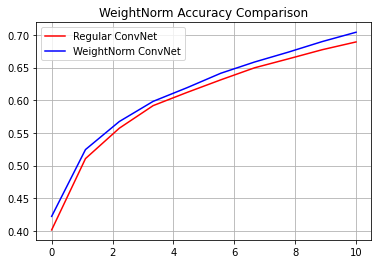

In [11]:
reg_accuracy = reg_history.history['accuracy']
wn_accuracy = wn_history.history['accuracy']

plt.plot(np.linspace(0, epochs,  epochs), reg_accuracy,
             color='red', label='Regular ConvNet')

plt.plot(np.linspace(0, epochs, epochs), wn_accuracy,
         color='blue', label='WeightNorm ConvNet')

plt.title('WeightNorm Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()